# Applying supervised learning to predict student dropout
## **Project Brief**
**Project Overview**

This project applies supervised machine learning to predict whether a student is likely to drop out based on demographic, engagement, and performance data. In the education sector, retaining students is crucial for both financial stability and supporting student success. High dropout rates can lead to lost revenue, reputational challenges, and reduced academic outcomes.
The objective of this project is to build a predictive model that identifies students at risk of dropping out at different stages of their learning journey. By detecting early warning signs, institutions can take proactive measures to improve retention and academic outcomes.

**Business Problem**

Educational institutions face ongoing challenges in maintaining student retention and ensuring academic progression. Understanding the key drivers behind dropout behaviour enables more targeted and effective interventions — such as academic support, engagement programs, or financial assistance.
A data-driven approach allows organisations to:
Identify at-risk students early.
Allocate support resources more efficiently.
Evaluate which engagement and performance factors most influence dropout risk.
By leveraging predictive modelling, institutions can shift from reactive to proactive retention strategies, improving both student outcomes and institutional performance.

**Project Objectives**

Explore and preprocess student data from multiple stages of the academic journey.
Engineer meaningful features (e.g., engagement, performance, demographics).
Train and evaluate supervised learning models (e.g., XGBoost, Neural Networks) to predict dropout likelihood.
Optimise model performance with a focus on minimising false negatives, ensuring that as many at-risk students as possible are identified.
Interpret model outputs to generate actionable insights for retention strategy design.



# **Project Introduction**

#### **Datasets**
This notebook explores the development and evaluation of XGBoost and Neural Network models for predicting student dropout. The analysis is conducted using three distict datasets, which each representing a different stage of the student's academic journey and a potential key stage for identifying those at risk of dropping out.
* Stage 1: Contains only demographic and background information.
* Stage 2: Builds on Stage 1 dataset by including student engagement features: 'AuthorisedAbsenceCount' and 'UnauthorisedAbsenceCount'
* Stage 3: Includes all Stage 1 and Stage 2 features along with academic performance features: 'AssessedModules', 'FailedModules' and 'PassedModules'.

#### **Analysis Goals**
The analysis provides two key comparisons:
1. Baseline vs Tuned Models- for each dataset stage, a baseline model (default hyperparameters) is compared to a tuned model to assess the effectiveness of hyperparameter tuning in improving model performance at each stage.
2. Performance across stages- by evaluating the baseline models across the three stages, the effect of new features on the predictive power of the models can be assessed.

#### **Model evaluation strategy**
The primary business objective is to predict student dropout, with a key focus on identifying as many at-risk students as possible. Missing a potential dropout (i.e. a false negative) can have serious concequences, including lost revenue, reputational damage and missed opportunities for timely intervention. In this context, false positives are less concerning than failing to identify a true dropout case.
* As such, recall will be the priority metric during model tuning, as it directly measures the models ability to capture actual dropouts and reduce false negatives.
* While recall is the focus, it is also important to consider other metrics such as ROC AUC, precision and F1 score to provide a well rounded evaluation of model performance.
* Accuracy may be considered, but only if the dataset is relatively balanced across target classes, as it can be misleading in imbalanced datasets.


# **Set up work-space**

In [ ]:
# Import libraries.
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, classification_report, precision_score, recall_score, f1_score, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.utils.class_weight import compute_class_weight
from sklearn.impute import SimpleImputer
import tensorflow as tf
import tensorflow as tf
import os
from tensorflow import keras
from keras import Sequential
from keras.layers import Dense, Dropout, Input
from keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers
from tensorflow.keras.initializers import GlorotUniform

# **Define Model Functions**

In [ ]:
# Function to control sources of randomness for reproducibility.
def set_seed(seed=42):

    np.random.seed(seed)
    tf.random.set_seed(42)
    tf.keras.utils.set_random_seed(seed)
    random.seed(seed)

set_seed(42)
seed=42

In [ ]:
# Function to evaluate XGBoost models on test dataset.
def evaluate_model(model, X_test, y_test, model_name):
    y_pred = model.predict(X_test)

    a = accuracy_score(y_test, y_pred)
    roc = roc_auc_score(y_test, y_pred)
    r = recall_score(y_test, y_pred)
    p = precision_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    cm_matrix = confusion_matrix(y_test, y_pred)

    evaluation = pd.DataFrame({"Accuracy": [a],
                             "AUC ROC": [roc],
                             "Recall": [r],
                             "Precision": [p],
                             "F1 Score": [f1]},
                            index = [model_name])

    return evaluation, cm_matrix

In [ ]:
# Function to create and train a neural network.
def create_nn_model(X_train, y_train,
                    X_valid, y_valid,
                    optimizer,
                    activation,
                    neuron_layer_1,
                    neuron_layer_2,
                    batch_size,
                    regularizer,
                    callback,
                    class_weight):

    # Create the model.
    model = Sequential()
    model.add(Input(shape=(X_train.shape[1],))) # Input layer.
    model.add(Dense(neuron_layer_1, activation=activation, kernel_regularizer=regularizer)) # Hidden layer 1.
    model.add(Dense(neuron_layer_2, activation=activation, kernel_regularizer=regularizer)) # Hidden layer 2.
    model.add(Dense(1, activation='sigmoid')) # Output layer.

    # Compile the model.
    model.compile(optimizer=optimizer,
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    # Train the model.
    history = model.fit(X_train, y_train,
                        validation_data=(X_valid, y_valid),
                        epochs=50,
                        batch_size=batch_size,
                        callbacks=callback,
                        class_weight=class_weight,
                        verbose=0)

    return model, history

In [ ]:
# Function to evaluate neural network models on test dataset.
def evaluate_nn_model(model, X_test, y_test, model_name):
    y_pred = (model.predict(X_test, verbose=0) > 0.5).astype(int)  # predicts probabilities, applies a threshold to convert to binary label.

    a = accuracy_score(y_test, y_pred)
    roc = roc_auc_score(y_test, y_pred)
    r = recall_score(y_test, y_pred)
    p = precision_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    cm_matrix = confusion_matrix(y_test, y_pred)

    evaluation = pd.DataFrame({"Accuracy": [a],
                             "AUC ROC": [roc],
                             "Recall": [r],
                             "Precision": [p],
                             "F1 Score": [f1]},
                            index = [model_name])

    return evaluation, cm_matrix

In [ ]:
# Function to evaluate neural networks on validation dataset during hyperparameter tuning.
def hyperparameter_evaluation(model, X_valid, y_valid):
    y_pred = (model.predict(X_valid) > 0.5).astype(int) # predicts probabilities, applies a threshold to convert to binary label.

    accuracy = accuracy_score(y_valid, y_pred)
    recall = recall_score(y_valid, y_pred)
    f1 = f1_score(y_valid, y_pred)
    auc = roc_auc_score(y_valid, y_pred)
    prec = precision_score(y_valid, y_pred)

    return accuracy, recall, f1, auc, prec

In [ ]:
# Function to plot loss and accuracy curves.
def plot_curve(history_model, model_name):

    # Plot accuracy for training vs validation data per epoch.
    plt.figure(figsize=(10, 6))
    plt.plot(history_model.history['accuracy'], label='Training Accuracy', color='blue')
    plt.plot(history_model.history['val_accuracy'], label='Validation Accuracy', color='blue', linestyle='--')

    plt.title(f"Training vs Validation Accuracy for Neural Network {model_name}", fontsize=14, fontweight='bold', pad=10)
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Plot loss for training vs validation data per epoch.
    plt.figure(figsize=(10, 6))

    plt.plot(history_model.history['loss'], label='Training Loss', color='red')
    plt.plot(history_model.history['val_loss'], label='Validation Loss', color='red', linestyle='--')

    plt.title(f"Training vs Validation Loss for Neural Network {model_name}")
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

In [ ]:
# Function to plot Confusion matrix.
def plot_confusion_matrix(cm_matrix, title):
    cmfd = ConfusionMatrixDisplay(confusion_matrix=cm_matrix, display_labels=['No', 'Yes'])
    cmfd.plot()
    plt.title(title)
    plt.show()

    return cmfd

In [ ]:
# Function to plot a comparison bar chart.
def plot_bar_comparison(model, model_1_name, model_1_evaluation, model_2_name, model_2_evaluation):
    metrics = ['Accuracy', 'AUC ROC', 'Recall', 'Precision', 'F1 Score']

    # Extract values from evaluation tables.
    model_1_values = model_1_evaluation.values.flatten()
    model_2_values = model_2_evaluation.values.flatten()

    # Define metric location.
    x = np.arange(len(metrics))
    width = 0.35

    # Create bar chart.
    fig, ax = plt.subplots(figsize=(10, 6))
    bars1 = ax.bar(x - width/2, model_1_values, width, label=f'{model_1_name}', color='lightcoral')
    bars2 = ax.bar(x + width/2, model_2_values, width, label= f'{model_2_name}', color='mediumaquamarine')

    # Add labels.
    ax.set_ylabel('Score', fontsize=12, fontweight='bold')
    ax.set_title(f'{model} Model Comparison: {model_1_name} vs {model_2_name}', fontsize=14, fontweight='bold', pad=10)
    ax.set_xticks(x)
    ax.set_xticklabels(metrics, fontsize=11, fontweight='bold')
    ax.set_ylim(0.4, 1)
    ax.legend()

    for bar in bars1 + bars2:
        height = bar.get_height()
        ax.annotate(f'{height:.3f}', xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3), textcoords="offset points", ha='center', va='bottom')


    plt.tight_layout()
    plt.show()

# **1. Stage 1 Data**

The stage 1 dataset includes only the initial demographic and background features available at the start of a student's academic journey. This represents the earlier point at which dropout prediction can be attempted and is based soley on pre-enrolement information.

## **1.1 Pre-processing**

### **1.1.1 View the data**

In [ ]:
# File url.
# file_url = [REDACTED]

# Import the data.
stage_1 = pd.read_csv(file_url)

In [ ]:
# Define variables.
X = stage_1.drop('CompletedCourse', axis=1).copy()
y = stage_1['CompletedCourse'].copy()

In [ ]:
# View shape.
print("Number of features:", X.shape[1])
print("Number of sample:", X.shape[0])

Number of features: 15
Number of sample: 25059


### **1.1.2 Remove features**

In [ ]:
# Drop redundant columns (LearnerCode).
X = X.drop("LearnerCode", axis=1)
print("Number of remaining features", X.shape[1])

Number of remaining features 14


In [ ]:
# Identify datatypes.
X.dtypes.unique()

array([dtype('O'), dtype('bool')], dtype=object)

The dataset contains only object and boolean features i.e. only categorical variables.

In [ ]:
# Drop categorical columns with high cardinality.
high_cardinality_cols = [col for col in X.columns if X[col].nunique() > 200]
X = X.drop(high_cardinality_cols, axis=1)
print("High cardinality columns:", list(high_cardinality_cols))
print("Number of remaining features:", X.shape[1])

High cardinality columns: ['DateofBirth', 'HomeState', 'HomeCity', 'ProgressionDegree']
Number of remaining features: 10


Note: 'DateofBirth' is a datetime feature that will later be converted to a numerical column denoted 'Age' and re-added to the dataset during feature engineering. It has been exluded temporarily for encoding purposes.

In [ ]:
# Drop columns with >50% data missing.
missing_data_cols = X.columns[X.isnull().sum() / X.shape[0] > 0.5]
X = X.drop(missing_data_cols, axis=1)
print("Missing data columns:", list(missing_data_cols))
print("Number of remaining features:", X.shape[1])

Missing data columns: ['DiscountType']
Number of remaining features: 9


### **1.1.3 Encode categorical columns**

In [ ]:
# Determine the type of categorical column (ordinal or nominal) by viewing the unique values.
for col in X.columns:
    print(f"\n{col} unique values:")
    print(X[col].unique())


CentreName unique values:
['ISC_Aberdeen' 'ISC_Cardiff' 'ISC_Dublin' 'ISC_Durham' 'ISC_Holland'
 'ISC_Huddersfield' 'ISC_Kingston' 'ISC_LJMU' 'ISC_Lancaster' 'ISC_Leeds'
 'ISC_Lincoln' 'ISC_London' 'ISC_Online' 'ISC_RHUL' 'ISC_Sheffield'
 'ISC_Strathclyde' 'ISC_Surrey' 'ISC_Sussex' 'ISC_Teesside']

BookingType unique values:
['Agent' 'Direct']

LeadSource unique values:
['Standard Agent Booking' 'Sponsor' 'APD' 'Digital (Web)' 'Referrals'
 'Walk-in' 'Re-enrolment']

Gender unique values:
['Male' 'Female']

Nationality unique values:
['Chinese' 'Iraqi' 'Kenyan' 'British' 'Kazakhstani' 'Taiwanese' 'Lebanese'
 'Kuwaiti' 'Qatari' 'Vietnamese' 'Egyptian' 'Emirati' 'Hong Kong Chinese'
 'Nigerian' 'Indian' 'Myanmarian' 'Singaporean' 'Bahraini' 'Japanese'
 'Bangladeshi' 'Libyan' 'Jordanian' 'Saudi' 'Angolan' 'Namibian'
 'Zimbabwean' 'Ghanaian' 'American' 'Omani' 'Senegalese' 'Brazilian'
 'Ugandan' 'Turkish' 'Mexican' 'Peruvian' 'Mozambican' 'Syrian'
 'Pakistani' 'Mauritanian' 'German' 'Afghan

* The 'CourseLevel' column is ordinal whilst the remaining columns are nominal.
* The ordinal column will be label encoded whilst the remaining columns will be one-hot encoded.

In [ ]:
# Label encode ordinal column 'CourseLevel'.
ordinal_cols = ['CourseLevel']
order = [['Foundation', 'International Year One', 'International Year Two', 'Pre-Masters']]

oe = OrdinalEncoder(categories=order)

ordinal_encoded = oe.fit_transform(X[ordinal_cols])
ordinal_df = pd.DataFrame(ordinal_encoded, columns=['CourseLevel_encoded'], index=X.index)

In [ ]:
# View ordinal encoded features.
ordinal_df.head()

,CourseLevel_encoded
0,3.0
1,0.0
2,2.0
3,2.0
4,3.0


In [ ]:
# One hot encode nominal columns.
nominal_cols = [col for col in X.columns if col not in ordinal_cols]

ohe = OneHotEncoder(drop= 'first', sparse_output=False, handle_unknown='ignore')
ohe_encoded = ohe.fit_transform(X[nominal_cols])
ohe_cols = ohe.get_feature_names_out(nominal_cols)

nominal_df = pd.DataFrame(ohe_encoded, columns=ohe_cols, index=X.index)

In [ ]:
# View nominal encoded features.
nominal_df.head()

In [ ]:
# Create encoded dataframe of nominal and ordinal features.
X_encoded = pd.concat([ordinal_df, nominal_df], axis=1)
X_encoded.head()

In [ ]:
# Shape of encoded dataframe.
print("Number of features:", X_encoded.shape[1])
print("Number of samples:", X_encoded.shape[0])

Number of features: 388
Number of samples: 25059


### **1.1.4 Feature engineering**

In [ ]:
# Convert 'DateofBirth' column to datetime.
stage_1['DateofBirth'] = pd.to_datetime(stage_1['DateofBirth'], dayfirst=True)

# Convert DOB to age and add feature to X_encoded.
X_encoded['Age'] = (pd.to_datetime('today') - stage_1['DateofBirth']).dt.days // 365

print("Number of features:", X_encoded.shape[1])

Number of features: 389


In [ ]:
# Rename CompletedCourse to DroppedOut and convert to binary values.
# For CompletedCourse= Yes, DroppedOut= 0, for CompletedCourse= No, DroppedOut= 1
y= y.rename('DroppedOut').map({'Yes': 0, 'No': 1}).astype(int)

print("Target values:", y.unique())

Target values: [0 1]


The target feature 'CompletedCourse' was changed to 'DroppedOut' and was mapped accordingly (For CompletedCourse= Yes, DroppedOut= 0, for CompletedCourse= No, DroppedOut= 1) to better align with the goals of the project and allow a more intuative interpretation.

### **1.1.5 Target feature balance**

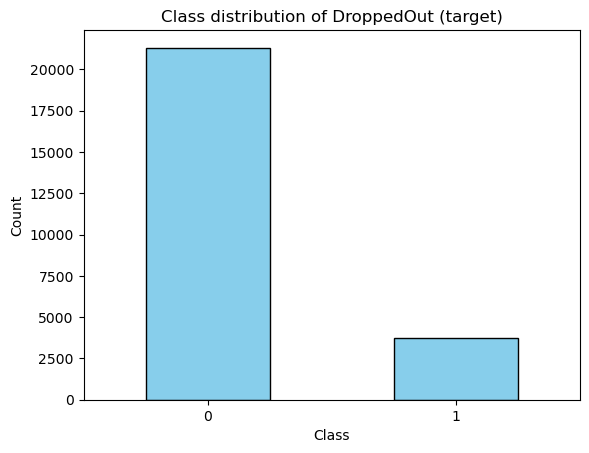

In [ ]:
# View target feature distribution.
y.value_counts().sort_index().plot(kind= 'bar', color= 'skyblue', edgecolor= 'black')

plt.title('Class distribution of DroppedOut (target)')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

In [ ]:
# View class proportions.
y.value_counts(normalize=True)

DroppedOut
0    0.850194
1    0.149806
Name: proportion, dtype: float64

Visualisation of the class distribution of the target variable (DroppedOut) and calculation of the class proportions indicate the dataset is highly unbalanced, with 85% of the observations belonging to Class 0 (did not drop out) and only 15% belonging to Class 1 (dropped out). As Class 1 is underepresented, it should be noted that accuracy metrics may be deceptively high and other metrics should be implemented when evaluating the model to address the imbalance.

### **1.1.6 Split the data**

In [ ]:
# Split the data into training and test set.
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, stratify=y, random_state=seed)

## **1.2 XGBoost**

### **1.2.1 XGBoost (Baseline Model 1)**

To establish a performance benchmark, a baseline XGBoost model was created for the Stage 1 dataset, which contains only the initial demographic and background features. This model was trained uisng default hyperparameters, with the exception of the scale_pos_weight parameter used to account for class imbalance in the target variable, to assess how well XGBoost performs using minimal information and configuration, providing a baseline for comparison with more complex models.

Evaluation focused primarily on recall, in allignment with the business goals, however additional metrics such as precision, F1 score and ROC AUC were also consdered to provide a broader evaluation of the baseline performance.

**Key features of the Baseline Model 1:**
1. **scale_pos_weight:** This parameter is implemented to address class imbalance.
2. **Default Hyperparameters**
3. **Training Data:** Stage 1 dataset

In [ ]:
# Calculate scale_pos_weight for stage 1 data.
num_negatives = (y_train == 0).sum()
num_positives = (y_train == 1).sum()
scale_pos_weight = num_negatives / num_positives

In [ ]:
# Set seed.
set_seed(42)

In [ ]:
# Instantiate baseline XBGoost model on stage 1 data with scale_pos_weight.
xgb_model_1 = XGBClassifier(scale_pos_weight=scale_pos_weight,
                            random_state=seed,
                            n_jobs=1)

# Train on training dataset and evaluate model on test dataset.
xgb_model_1.fit(X_train, y_train)
xgb_1_evaluation, xgb_1_confusion_matrix = evaluate_model(xgb_model_1, X_test, y_test, 'XGBoost (Model 1)')

# View evaluation metrics.
xgb_1_evaluation

,Accuracy,AUC ROC,Recall,Precision,F1 Score
XGBoost (Model 1),0.857143,0.820006,0.766977,0.515667,0.616702


* **Recall:** Indicates 76.7 % of actual dropouts are correctly identified (key success metric).
* **Accuracy:** 85.7 % of predictions are correct, however this can be a misleading metric due to class imbalance.
* **AUC ROC:** AUC ROC > 0.8 is typically considered strong so model shows good overall discrimination between dropouts and non-dropouts
* **Precision:** 51.6 % of students predicted as dropouts are actually dropouts. This implies a relatively high false positive rate, which is arguably acceptable in the business context as it preferable to be over cautious than miss an actual dropout case.
* **F1 Score:** Resonable score of 0.6 considering recall is being prioritised.

**Overall** This is a strong starting point for model tuning.

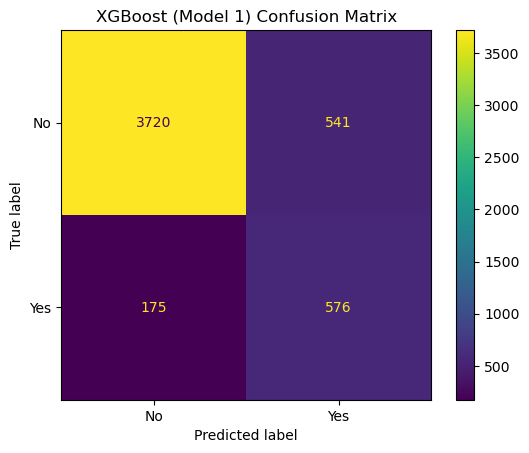

In [ ]:
# View confusion matrix.
xgb_1_cmfd = plot_confusion_matrix(xgb_1_confusion_matrix, title='XGBoost (Model 1) Confusion Matrix')

* **True Negatives** = 3720, the model correctly predicted 3720 cases of students not dropping out.
* **False Negatives** = 175, the model missed 175 cases student drop out- this is the key factor to decrease so dropout cases are not missed.
* **False Positive** = 541, the model identified 541 cases where it predicted the student would drop out but they didn't, this may have to be lowered if it is problematic to intervene unecessarily.
* **True Positives** = 576, the model correctly predicted 576 cases of student drop out.


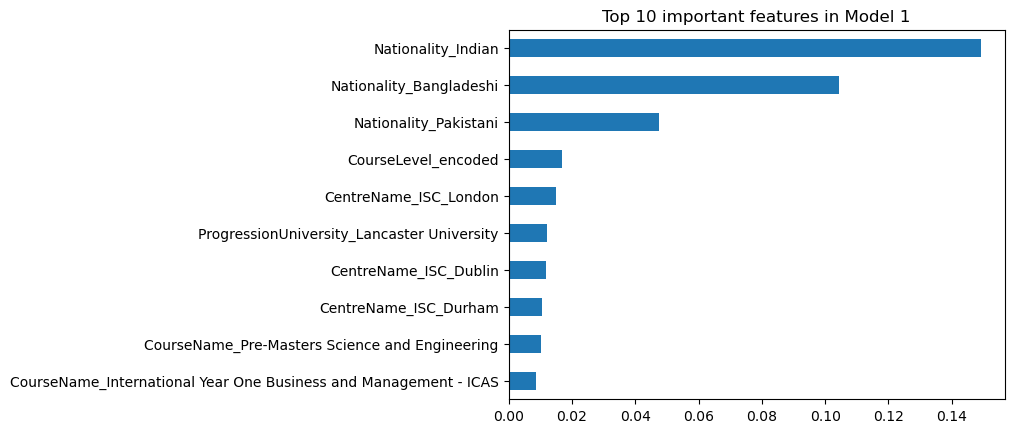

In [ ]:
# Extract feature importances for Model 1.
feature_importance = pd.Series(xgb_model_1.feature_importances_, index=X_train.columns).sort_values()

# View plot of top 10 importance features for readability.
feature_importance.iloc[-10:].plot.barh()
plt.title('Top 10 important features in Model 1')
plt.show()

The feature importance plot for Model 1 indicates that the most influential variables in predicting student dropout were the nationality categories: 'Indian', 'Bangladeshi' and 'Pakistani'. This suggests that students from these demographics contributed more significantly to the model's predictions. However, this also raises important considerations around potential bias as reliance on nationality could lead to unintended discriminatory outcomes.  

### **1.2.2 XGBoost (Tuned Model 2)- Best Recall**

Building on the baseline, a tuned XGBoost model was developed using the Stage 1 dataset to explore whether hyperparameter optimisation could improve dropout prediction performance. A grid search was conducted to identify the best performing combination of hyperparameters of max_depth, learning_rate and n_estimators, with a focus on maximising recall. The performance was evaluated using recall, as well as supporting metrics precision, F1 score and ROC AUC to assess whether tuning offered a meaningful improvement.

**Key features of the Tuned Model 2:**
1. **scale_pos_weight:** This parameter is implemented to address class imbalance.
2. **Tuned Hyperparameters:** Optimised for recall score.
3. **Training Data:** Stage 1 dataset

In [ ]:
# Set seed.
set_seed(42)

In [ ]:
# Instantiate XBGoost model 2 with scale_pos_weight.
xgb_model_2 = XGBClassifier(scale_pos_weight=scale_pos_weight,
                            random_state=seed,
                            n_jobs=1)

In [ ]:
# Tune XGBoost hyperparameters on stage 1 dataset: learning rate, max depth and number of estimators.
# Define parameter grid of parameters and respective values to test.
param_grid = {'learning_rate': [0.01, 0.05, 0.1],
              'max_depth': [3, 5, 7],
              'n_estimators': [200, 500, 700]}

# Define cross validation.
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)

# Run grid search with recall set as scoring metric.
grid = GridSearchCV(estimator=xgb_model_2,
                    param_grid=param_grid,
                    scoring='recall',
                    cv=cv,
                    n_jobs=-1)

# Fit to training data.
grid.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, feature_weights=None,
                                     gamma=None, grow_polic...
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=1, num_parallel_tree=None, ...),
             n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.05, 0.1],
                         'max_depth': [3, 5, 7],
                         'n_estimators': [200, 500, 700]},
             scoring='recall')

In [ ]:
# View the best results.
print("Best Parameters:", grid.best_params_)
print("Best Recall Score", grid.best_score_)
xgb_model_2 = grid.best_estimator_

Best Parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200}
Best Recall Score 0.7782151968940655


A grid search of learning rate, max depth and n_estimators, with recall set as the scoring method, identified that the best combination of hyperparameter values is 0.1, 3 and 200 respectively. Implementing these optimised hyperparameters increased recall from 76.7 % in the baseline model to 77.8% (evaluated on the validation dataset).

In [ ]:
# Evaluate the best model on the test data.
xgb_2_evaluation, xgb_2_confusion_matrix = evaluate_model(xgb_model_2, X_test, y_test, 'XGBoost (Model 2)')
xgb_2_evaluation

,Accuracy,AUC ROC,Recall,Precision,F1 Score
XGBoost (Model 2),0.834796,0.810703,0.776298,0.469027,0.584754


* **Accuracy:** 83.5 % of predictions are correct, however this can be a misleading metric due to class imbalance.
* **AUC (ROC):** AUC > 0.8 is typically considered strong so model shows good overall discrimination between dropouts and non-dropouts.
* **Recall:** Indicates 77.6 % of actual dropouts are correctly identified (key success metric).
* **Precision:** 46.9 % of students predicted as dropouts are actually dropouts, indicating a high false positive rate.
* **F1 Score:** A score of 0.58 reflects the weaker precision value.

**Overall** Model has high recall (good for catching dropout cases) with the trade-off of lower precision which means more students are being flagged incorrectly as dropouts. This could be acceptable if false positives are less concerning than missing actual dropout cases.

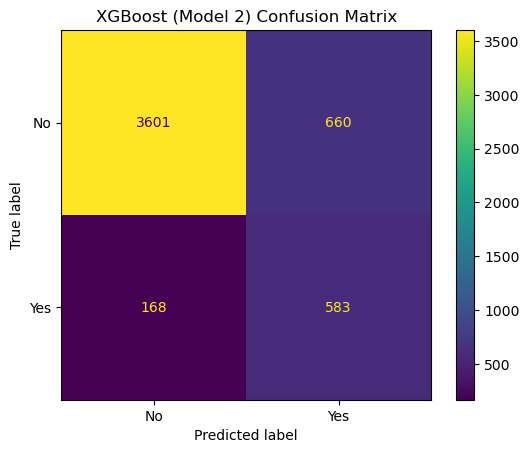

In [ ]:
# View confusion matrix.
xgb_2_cmfd = plot_confusion_matrix(xgb_2_confusion_matrix, title='XGBoost (Model 2) Confusion Matrix')

* **True Negatives** = 3601, the model correctly predicted 3601 cases of students not dropping out.
* **False Negatives** = 168, the model missed 168 cases student drop out- this is the key factor to decrease so dropout cases are not missed.
* **False Positive** = 660, the model identified 660 cases where it predicted the student would drop out but they didn't, this may have to be lowered if it is problematic to intervene unecessarily.
* **True Positives** = 583, the model correctly predicted 583 cases of student drop out.

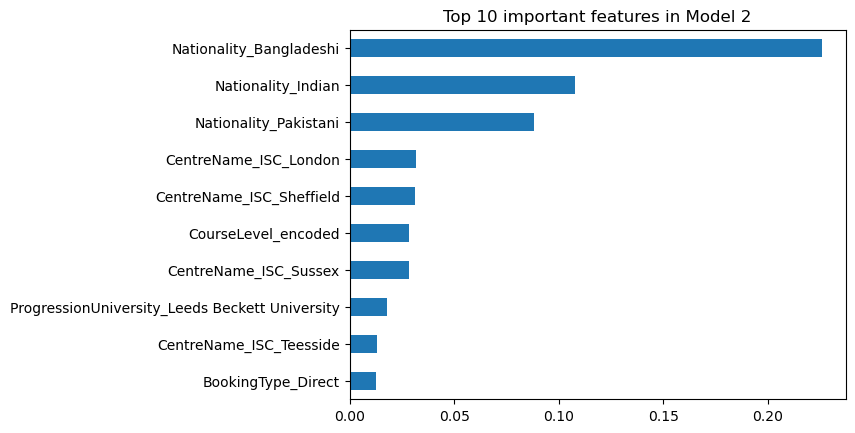

In [ ]:
# Extract feature importances for Model 2.
feature_importance_2 = pd.Series(xgb_model_2.feature_importances_, index=X_train.columns).sort_values()

# View plot of top 20 importance features for readability.
feature_importance_2.iloc[-10:].plot.barh()
plt.title('Top 10 important features in Model 2')
plt.show()

The feature importance plot for Model 2 (optimised for recall) indicates that the same features as Model 1 are the most influential in predicting student recall, namely the nationality categories: 'Indian', 'Bangladeshi' and 'Pakistani', albeit in a slightly different order. As with Model 1, potential bias should be considered. Sheffield in the Centre Name cateogory appears to contribute more to the Model 2 predictions compared to Model 1.

### **1.2.3 XGBoost Baseline vs Tuned Model (Stage 1)**

To assess the impact of hyperparameter optimisation, the performance of the tuned XGBoost model (Model 2) was compared against the baseline model (Model 1) using the Stage 1 dataset, which is the most limited dataset in terms of predictive information. The comparison focuses on key evaluation metrics including recall, precision, F1 score and ROC AUC to determine whether hyperparameter tuning lead to a meaningful increase in performance.

**Models:**
* **XGBoost Model 1** = XGBoost baseline model trained on stage 1 data
* **XGBoost Model 2** = XGBoost tuned model (optimised Recall) trained on stage 1 data

In [ ]:
# View summary evaluation metrics for XGBooost models 1 (baseline) and 2 (tuned) for comparison.
xgb_comparison_stage_1 = pd.concat([xgb_1_evaluation, xgb_2_evaluation])
xgb_comparison_stage_1

,Accuracy,AUC ROC,Recall,Precision,F1 Score
XGBoost (Model 1),0.857143,0.820006,0.766977,0.515667,0.616702
XGBoost (Model 2),0.834796,0.810703,0.776298,0.469027,0.584754


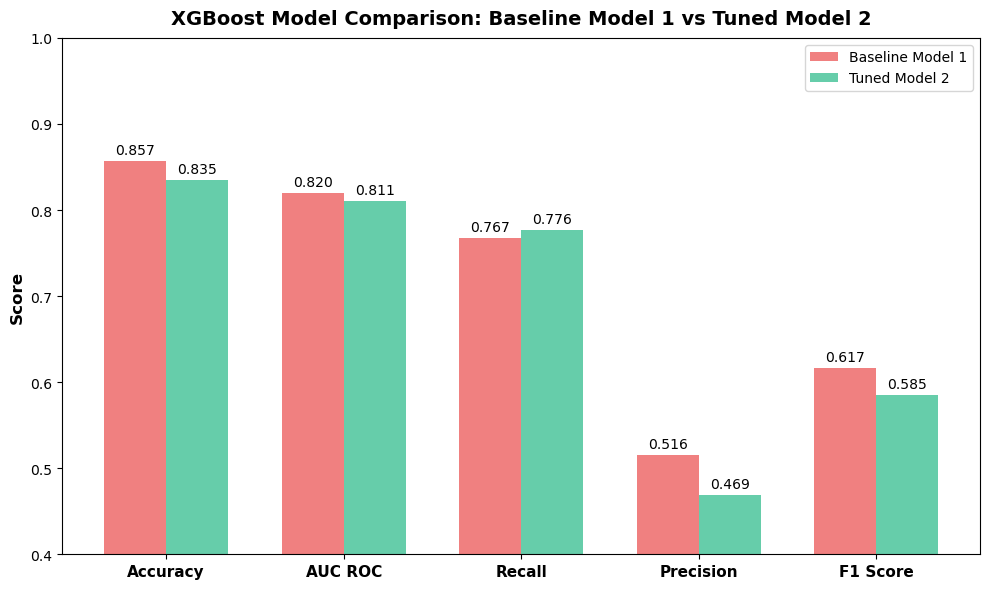

In [ ]:
# View summary evaluation metrics as a bar plot for comparison.
plot_bar_comparison(model= 'XGBoost',
                    model_1_name='Baseline Model 1',
                    model_1_evaluation=xgb_1_evaluation,
                    model_2_name='Tuned Model 2',
                    model_2_evaluation=xgb_2_evaluation)

* Model 2 achieved a slightly higher recall score (77.6% vs 76.6%), although the difference is marginal and may not be practically significant.
* Model 1 performed slightly better across the other performance metrics, especially precision, with only a minor trade-off in recall
* Overall, hyperparameter tuning in this instance did not lead to a significant improvement in recall performance and sacraficed precision.

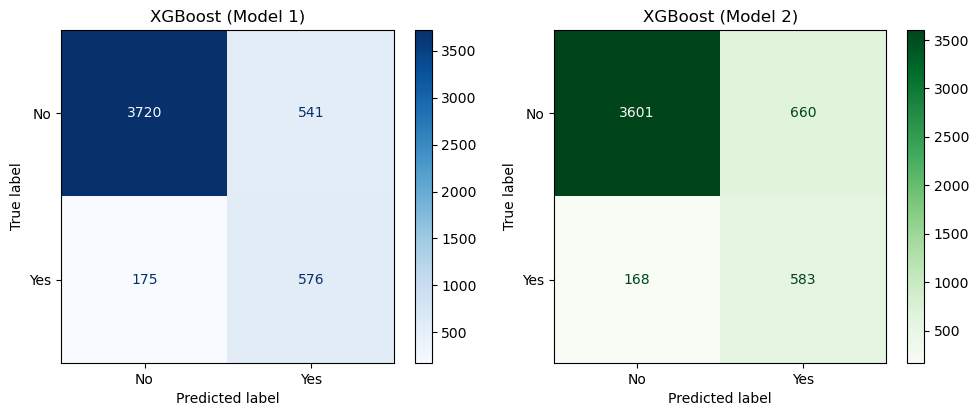

In [ ]:
# Compare confusion matrix for XGBooost models 1 (baseline) and 2 (tuned) for comparison.
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

ConfusionMatrixDisplay(
    confusion_matrix=xgb_1_confusion_matrix,
    display_labels=['No', 'Yes']
).plot(ax=axes[0], cmap='Blues')
axes[0].set_title('XGBoost (Model 1)')

ConfusionMatrixDisplay(
    confusion_matrix=xgb_2_confusion_matrix,
    display_labels=['No', 'Yes']
).plot(ax=axes[1], cmap='Greens')
axes[1].set_title('XGBoost (Model 2)')

plt.tight_layout()
plt.show()

* Model 2 (tuned) gave fewer false negatives (168), which in the business context is key to reduce, compared to model 1 (175), meaning Model 2 missed fewer dropout cases, although the difference is very minor.
* Model 1 (baseline) gave fewer false positives (541) compared to Model 2 (660), meaning Model 1 predicted fewer students as dropout cases when they actually were not dropouts. Depending on the expense of early intervention when it is unecessary, this may not necessarily be a negative if recall is optimised.

## **1.3 Neural Networks**

### **1.3.1 Preprocessing**

In [ ]:
# Split training dataset into training and validation.
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, stratify=y_train, random_state=seed)

In [ ]:
# Standardise the data.
std = StandardScaler()

X_train = std.fit_transform(X_train)
X_valid = std.transform(X_valid)
X_test = std.transform(X_test)

### **1.3.2 Neural Network (Baseline Model 1)**

To establish a benchmark for student dropout prediction using a deep learning approach, a baseline neural network was developed using the Stage 1 dataset. The model was trained using default parameters with the exception of class weighting to address the imbalance of the target variable, l2 regularisation and early stopping to reduce the risk of overfitting. Evaluation focused primarily on recall, but other key metrics such as F1 score, ROC AUC and precision were also considered.

**Key features of the baseline model:**
1. **Class weighting:** Included to address class imbalance by assigning higher importance to the minority class (in this case Class 1, student dropouts).
2. **L2 regularisation:** Included to penalise large weights to reduce overfitting and improve generalisation.
3. **Early Stopping:** Set to monitor the performance of the validation dataset and to halt training when no further improvement occurs to prevent overfitting and save computational resources.
4. **Training Data:** Stage 1 data

In [ ]:
# Compute class weights.
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weights = {0: class_weights[0], 1: class_weights[1]}

# Define early stopping callback.
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Define regulariser.
l2_regularizer=regularizers.l2(0.001)

In [ ]:
# Set seed.
set_seed(42)

In [ ]:
# Create baseline neural network (Model 1).
nn_model_1, history_1 = create_nn_model(X_train, y_train,
                                        X_valid, y_valid,
                                        optimizer='adam',
                                        activation='relu',
                                        neuron_layer_1=128,
                                        neuron_layer_2=64,
                                        batch_size=32,
                                        regularizer=l2_regularizer,
                                        callback=early_stopping,
                                        class_weight=class_weights)

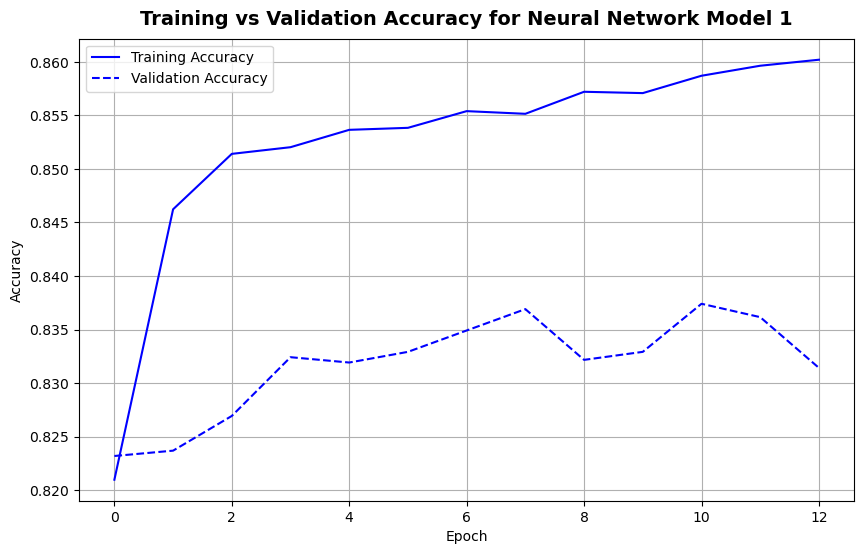

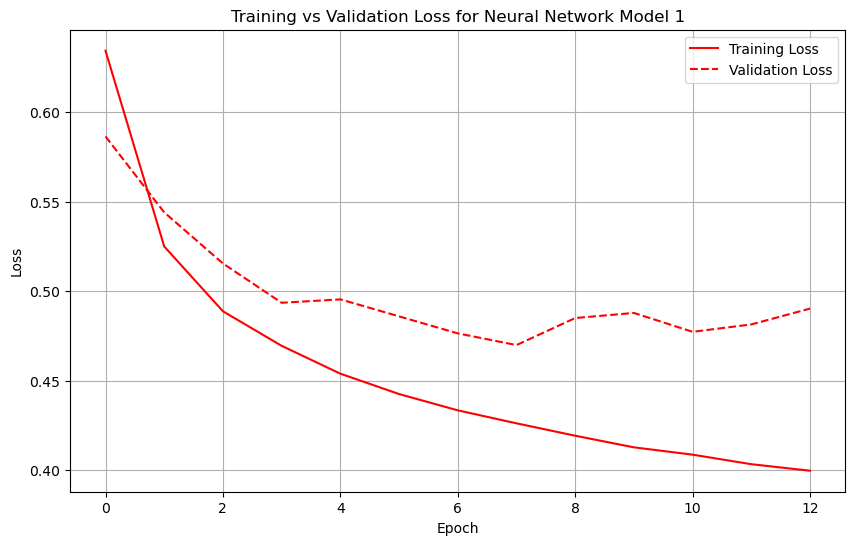

In [ ]:
# Plot loss and accuracy curves for Model 1.
plot_curve(history_1, model_name= 'Model 1')

Training accuracy increases dramatically followed by a slow increase over epochs which is as expected as the model learns the training data. In contrast, the validation accuracy shows a slight increase, followed by a sharper decline and appears to fluctuate considerably, indicating a high level of noise or instability in the validation performance.

While Training loss slowly decreases over epochs which is as expected as the model learns the training data, the validation loss initially decreases before reaching a plateau, indicating limited further improvement.

Overall the model achieves higher training accuracy compared to validation accuracy and lower training loss than validation loss. This may indicate overfitting, where the model performs well on the training data, but cannot generalise well to unseen data.

In [ ]:
# Evaluate the performance of Model 1 on the test data.
nn_1_evaluation, nn_1_confusion_matrix = evaluate_nn_model(nn_model_1, X_test, y_test, model_name='Neural Network (Model 1)')

# View evaluation metrics.
nn_1_evaluation

,Accuracy,AUC ROC,Recall,Precision,F1 Score
Neural Network (Model 1),0.841381,0.816769,0.781625,0.481938,0.596242


* **Accuracy:** Accuracy is high (84.1%) although this may be misleading due to class imbalance.
* **Recall:** Recall is reasonably high at 78.2 %, meaning the model correctly identifies 78.2% of actual student dropouts
* **Precision:** Precision is 48.2 % which indciates that just under half of the predicted dropouts are correct, resulting in a higher number of false positives.
* **F1 Score:** Reflects a moderate balance between recall and precision.
* **AUC ROC:** Score is > 0.80 showing a strong ability to distinguish between dropouts and non-dropouts.

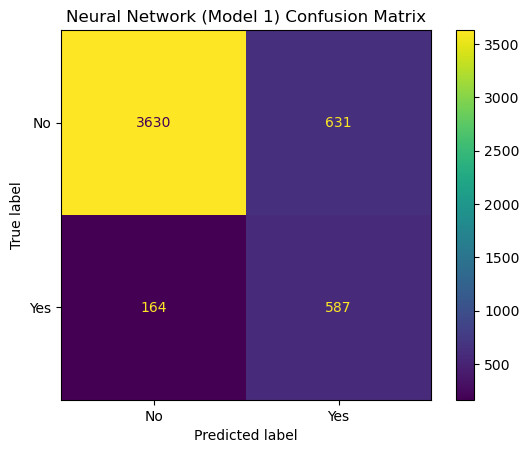

In [ ]:
# View Model 1 confusion matrix.
nn_1_cfmd = plot_confusion_matrix(nn_1_confusion_matrix, title='Neural Network (Model 1) Confusion Matrix')

* **True Negatives** = 3630, the model correctly predicted 3630 cases of students not dropping out.
* **False Negatives** = 164, the model missed 164 cases student drop out.
* **False Positive** = 631, the model identified 631 cases where it predicted the student would drop out but they didn't.
* **True Positives** = 587, the model correctly predicted 587 cases of student drop out.

### **1.3.3 Hyperparameter Tuning**

Hyperparameter tuning was performed using a validation dataset, allowing for the selection of the best performing model configuration based on recall optimisation. The parameters to be optimised includes optimizers, hidden layer activation functions, number of neurons in hidden layer 1 and 2, and the batch size.

In [ ]:
# Set seed.
set_seed(42)

In [ ]:
# Define hyperparameter ranges to test.
optimizers = ['adam', 'rmsprop']
activations = ['relu', 'tanh']
neuron_1 = [128, 64, 32]
neuron_2 = [64, 32, 16]
batch_sizes = [32, 64, 128]

results = []

# Create a for loop for each hyperparameter vector.
for o in optimizers:
    for act in activations:
        for n1 in neuron_1:
            for n2 in neuron_2:
                for bs in batch_sizes:
                    tuned_model, tuned_history = create_nn_model(X_train, y_train,
                                                                 X_valid, y_valid,
                                                                 optimizer=o,
                                                                 activation=act,
                                                                 neuron_layer_1=n1,
                                                                 neuron_layer_2=n2,
                                                                 batch_size = bs,
                                                                 regularizer=l2_regularizer,
                                                                 callback=early_stopping,
                                                                 class_weight=class_weights)

                    # Evaluate the models on the validation data.
                    accuracy, recall, f1, auc, prec = hyperparameter_evaluation(tuned_model, X_valid, y_valid)

                    # Add the evaluation metrics of each model to results.
                    results.append({'Optimizer': o,
                                    'Activation': act,
                                    'Layer 1 Neurons': n1,
                                    'Layer 2 Neurons': n2,
                                    'Batch size': bs,
                                    'Recall': recall,
                                    'Precision': prec,
                                    'Accuracy': accuracy,
                                    'F1 Score': f1,
                                    'ROC AUC': auc})

126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 326us/step
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 328us/step
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 331us/step
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 316us/step
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 323us/step
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 320us/step
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 324us/step
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 318us/step
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 317us/step
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 495us/step
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 300us/step
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 300us/step
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 300us/step
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 302us/step
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 300us/step
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 301us/step
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 291us/step
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 298us/step
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 291us/step
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 293us/step
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 294us/step
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 294us/step
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 288us/step
126/126 ━━━

In [ ]:
# Convert results to a dataframe.
results_df = pd.DataFrame(results)

# Find the parameter combinations corresponding to the highest value of each metric.
best_accuracy = results_df.loc[results_df['Accuracy'].idxmax()]
best_recall = results_df.loc[results_df['Recall'].idxmax()]
best_f1 = results_df.loc[results_df['F1 Score'].idxmax()]
best_auc = results_df.loc[results_df['ROC AUC'].idxmax()]
best_prec = results_df.loc[results_df['Precision'].idxmax()]

# Create a summary table with the best parameters and metric values.
results_summary = pd.DataFrame([best_accuracy, best_recall, best_f1, best_auc, best_prec],
                               index=['Best Accuracy', 'Best Recall', 'Best F1 Score', 'Best ROC AUC', 'Best Precision'])

# View results
results_summary

,Optimizer,Activation,Layer 1 Neurons,Layer 2 Neurons,Batch size,Recall,Precision,Accuracy,F1 Score,ROC AUC
Best Accuracy,rmsprop,relu,64,64,32,0.742097,0.512644,0.855611,0.606390,0.808860
Best Recall,rmsprop,tanh,128,16,64,0.760399,0.477534,0.839401,0.586650,0.806864
Best F1 Score,rmsprop,relu,64,64,32,0.742097,0.512644,0.855611,0.606390,0.808860
Best ROC AUC,rmsprop,relu,64,64,32,0.742097,0.512644,0.855611,0.606390,0.808860
Best Precision,rmsprop,relu,32,64,64,0.732113,0.512821,0.855611,0.603153,0.804748


The parameter combination that achieves the highest recall is:
* Optimizer = rmsprop
* Activation Function = tanh
* Layer 1 neurons = 128
* Layer 2 neurons = 16
* Batch size = 64

Recall is highest at 76.0 %, meaning nearly 80% of student dropout cases are identified, although it does sacrifice some precision (47.8%) and F1 score (0.59).

### **1.3.4 Neural Network (Tuned Model 2)- Best Recall**

The best combination of parameters identified during hyperparameter tuning were then implemented in a second neural network model, which was then evaluated on an unseen test dataset to provide an unbiased assessment of its generalisation performance.

**Key features of the Model 2:**
1. **Baseline model features:** Class weighting, L2 regularisation and early stopping.
2. **Tuned parameters:** Includes the tuned hyperparameters that have the best recall score, whilst still maintaining good value of other metrics
3. **Training Data**: Stage 1 Data.

In [ ]:
# Extract the results of the grid search that gave the highest recall.
best_recall_optimizer = best_recall['Optimizer']
best_recall_activation = best_recall['Activation']
best_recall_l1_neurons = best_recall['Layer 1 Neurons']
best_recall_l2_neurons = best_recall['Layer 2 Neurons']
best_recall_bs = best_recall['Batch size']

In [ ]:
# Set seed.
set_seed(42)

In [ ]:
 # Create and train model on parameters that gave highest recall.
nn_model_2, history_2 = create_nn_model(X_train, y_train,
                                        X_valid, y_valid,
                                        optimizer=best_recall_optimizer,
                                        activation=best_recall_activation,
                                        neuron_layer_1=best_recall_l1_neurons,
                                        neuron_layer_2=best_recall_l2_neurons,
                                        batch_size=best_recall_bs,
                                        regularizer=l2_regularizer,
                                        callback=early_stopping,
                                        class_weight= class_weights)

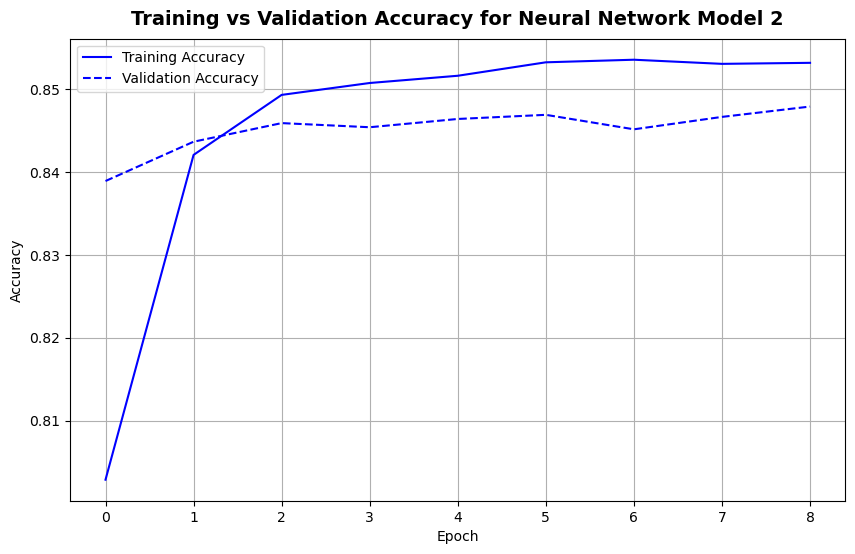

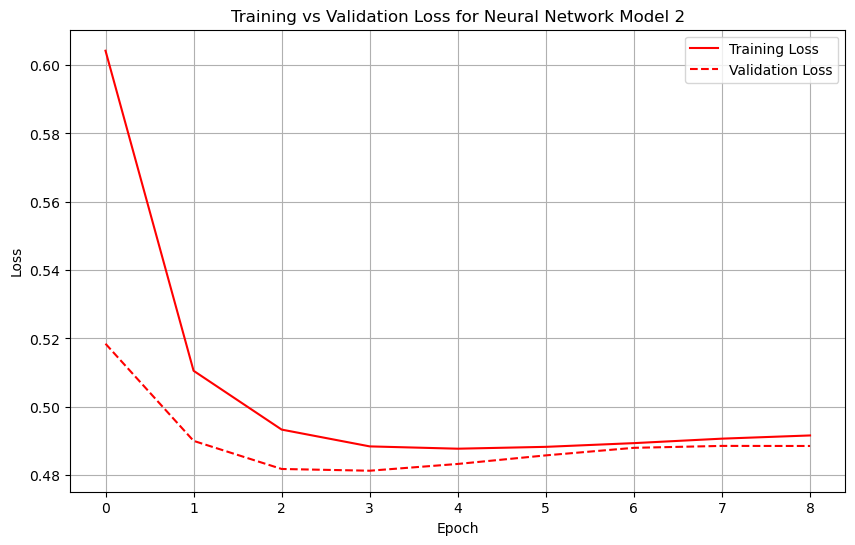

In [ ]:
# Plot loss and accuracy curves for tuned model.
plot_curve(history_2, model_name= 'Model 2')

The accuracy and loss plots show notable improvement over the baseline model. Validation accuracy is now much closer to the training accuracy, indicating better generalisation. However, it appears to plateau after a certain point, suggesting limited further gains.

Validation loss decreases intially, reflecting improvement performance, but then begins to slightly increase, potentially indicating the onset of overfitting. In addition, the training loss plateaus, indicating the model has mostly finished learning from the data.

In [ ]:
# Evaluate the tuned model on the test data.
nn_2_evaluation, nn_2_confusion_matrix = evaluate_nn_model(nn_model_2, X_test, y_test, model_name='Neural Network (Model 2)')
nn_2_evaluation

,Accuracy,AUC ROC,Recall,Precision,F1 Score
Neural Network (Model 2),0.841381,0.817317,0.782956,0.481967,0.596651


* **Accuracy:** Accuracy is high (84.1%) although this may be misleading.
* **Recall:** Recall is reasonably high at 78.2 %, meaning the model correctly identifies 78.2% of actual student dropouts
* **Precision:** Precision is 48.2 % which indciates that just under half of the predicted dropouts are correct, resulting in a higher number of false positives.
* **F1 Score:** Reflects a moderate balance between recall and precision.
* **AUC ROC:** Score is > 0.80 showing a strong ability to distinguish between dropouts and non-dropouts.

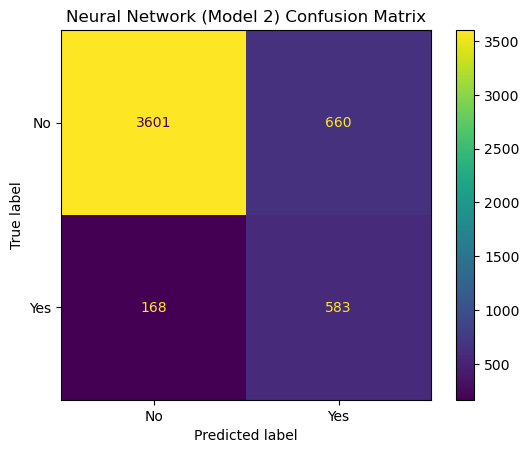

In [ ]:
# Plot confusion matrix.
xgb_2_cmfd = plot_confusion_matrix(xgb_2_confusion_matrix, title='Neural Network (Model 2) Confusion Matrix')

* **True Negatives** = 3601, the model correctly predicted 3658 cases of students not dropping out.
* **False Negatives** = 168, the model missed 168 cases student drop out.
* **False Positive** = 660, the model identified 660 cases where it predicted the student would drop out but they didn't.
* **True Positives** = 583, the model correctly predicted 583 cases of student drop out.

### **1.3.5 Neural Network Baseline vs Tuned Model (Stage 1)**

To evaluate the impact of hyperparameter tuning on model performance, the tuned neural network model (Model 2) was compared to its corresponding baseline version (Model 1) to determine if tuning led to meaningful improvements in model performance using the Stage 1 datasets.

**Models:**
* Neural Network Model 1 = Neural Network baseline model trained on stage 1 data
* Neural Network Model 2 = Neural Network tuned model (Recall optimised) trained on stage 1 data

In [ ]:
# View summary evaluation metrics for Neural Network model 1 (baseline) and 2 (tuned) for comparison.
nn_comparison_stage_1 = pd.concat([nn_1_evaluation, nn_2_evaluation])
nn_comparison_stage_1

,Accuracy,AUC ROC,Recall,Precision,F1 Score
Neural Network (Model 1),0.841381,0.816769,0.781625,0.481938,0.596242
Neural Network (Model 2),0.841381,0.817317,0.782956,0.481967,0.596651


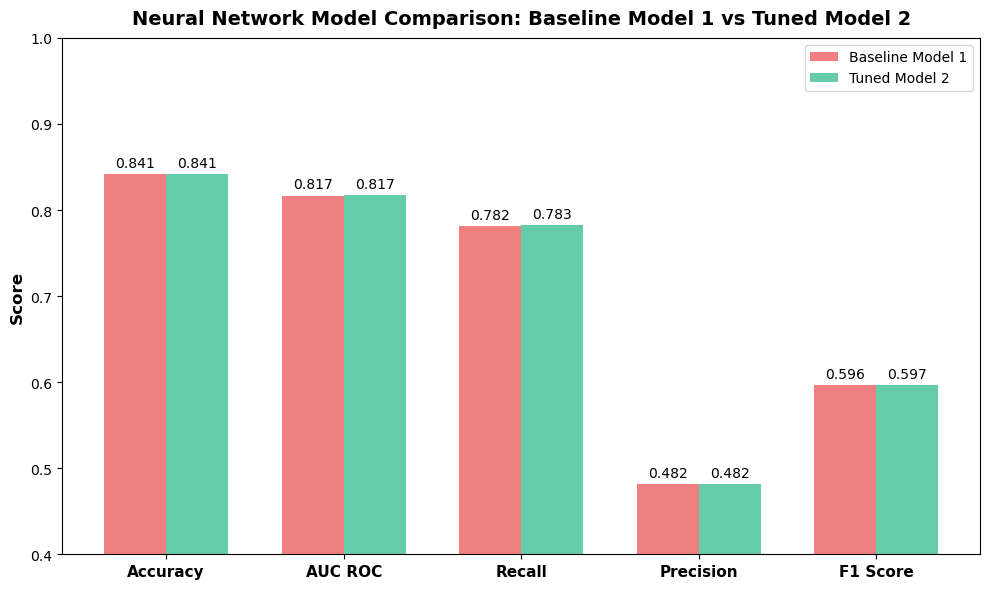

In [ ]:
# View summary evaluation metrics as a bar plot for comparison.
plot_bar_comparison(model= 'Neural Network',
                    model_1_name='Baseline Model 1',
                    model_1_evaluation=nn_1_evaluation,
                    model_2_name='Tuned Model 2',
                    model_2_evaluation=nn_2_evaluation)

* Model 2 outperforms Model 1 on every metric, however the differences are not large enough to be considered statistically different.

**Overall:** Model performance for recall (and the other metrics evaluated) was not significantly improved following hyperparameter tuning, suggesting either the baseline parameters were already suitable or different hyperparameter ranges need to be tested.

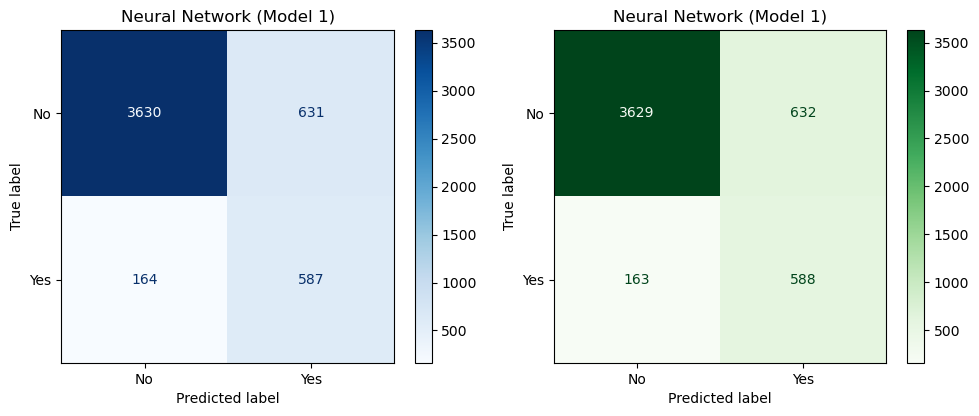

In [ ]:
# Compare confusion matrix for Neural Network model 1 (baseline) and 2 (tuned) for comparison.
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

ConfusionMatrixDisplay(
    confusion_matrix=nn_1_confusion_matrix,
    display_labels=['No', 'Yes']
).plot(ax=axes[0], cmap='Blues')
axes[0].set_title('Neural Network (Model 1)')

ConfusionMatrixDisplay(
    confusion_matrix=nn_2_confusion_matrix,
    display_labels=['No', 'Yes']
).plot(ax=axes[1], cmap='Greens')
axes[1].set_title('Neural Network (Model 1)')

plt.tight_layout()
plt.show()

* Model 1 and 2 gave extremely similar results and as such are not statistically different enough to be considered significant.

## **1.4 Stage 1 Conclusions**

The Stage 1 analysis focused on predicting student dropout using only the intial demongraphic background features available at the start of the academic journey. Both XGBoost and neural network models were evaluated in their baseline and tuned formed to assess their predictive performance.
* Hyperparameter tuning led to modest improvement in recall for the XGBoost model, but at the cost of a slight decrease in other performance metrics. Hyperparameter tuning did not have a significant effect on the Neural Network suggesting either the baseline metrics were already suitable or different ranges of hyperparameters need to be tested.
* The neural network models outperformed the XGBoost models in terms of recall (78%) whilst maintaining a good overall performance.
* The performance of all models in Stage 1 was limited by the restrictive feature set, highlighting the challenge of accurate early prediction when only background data is available.

# **2. Stage 2 Data**

The Stage 2 dataset builds upon the Stage 1 dataset by including additional student engagement data, specifically the features 'AuthorisedAbsenceCount' and 'UnauthorisedAbsenceCount'. These features reflect student attendence and are available mid-way through the student's academic journey, offering a more informed basis for predicting student dropout risk.

## **2.1 Pre-processing**

### **2.1.1 View the data**

In [ ]:
# File url.
file_url_2 = "https://drive.google.com/uc?id=1vy1JFQZva3lhMJQV69C43AB1NTM4W-DZ"

# Import the data.
stage_2 = pd.read_csv(file_url_2)

In [ ]:
# View the data.
stage_2.head()

,CentreName,LearnerCode,BookingType,LeadSource,DiscountType,DateofBirth,Gender,Nationality,HomeState,HomeCity,CourseLevel,CourseName,IsFirstIntake,CompletedCourse,ProgressionDegree,ProgressionUniversity,AuthorisedAbsenceCount,UnauthorisedAbsenceCount
0,ISC_Aberdeen,2284932,Agent,Standard Agent Booking,NaN,13/01/1998,Male,Chinese,Jianye District; Jiangsu Province,Nanjing,Pre-Masters,Business and Law Pre-Masters,True,Yes,Msc Econ Accounting and Investment Management,University of Aberdeen,NaN,NaN
1,ISC_Aberdeen,2399500,Agent,Standard Agent Booking,NaN,12/2/1998,Male,Chinese,NaN,Xi'an,Foundation,Life Sciences Undergraduate Foundation Programme,False,Yes,BSc Biological Sciences,University of Aberdeen,93.0,5.0
2,ISC_Aberdeen,2424946,Agent,Standard Agent Booking,NaN,7/4/2000,Male,Chinese,NaN,Chengdu,International Year Two,Business Management and Finance International ...,False,Yes,MA Finance,University of Aberdeen,92.0,6.0
3,ISC_Aberdeen,2426583,Agent,Standard Agent Booking,NaN,18/05/1999,Male,Chinese,NaN,LIUYANG CITY ;CHANGSHA,International Year Two,Business Management and Finance International ...,True,Yes,MA Business Management,University of Aberdeen,67.0,15.0
4,ISC_Aberdeen,2434674,Agent,Standard Agent Booking,NaN,19/04/1996,Male,Chinese,NaN,Xiamen,Pre-Masters,Business and Law Pre-Masters,True,Yes,MSc International Business Management,University of Aberdeen,NaN,NaN


In [ ]:
# Define variables.
X_2 = stage_2.drop('CompletedCourse', axis=1).copy()
y_2 = stage_2['CompletedCourse'].copy()

In [ ]:
# View shape.
print("Number of features:", X_2.shape[1])
print("Number of sample:", X_2.shape[0])

Number of features: 17
Number of sample: 25059


### **2.1.2 Remove features**

In [ ]:
# Drop redundant columns (LearnerCode).
X_2 = X_2.drop("LearnerCode", axis=1)
print("Number of remaining features", X_2.shape[1])

Number of remaining features 16


In [ ]:
# Identify datatypes.
X_2.dtypes.unique()

array([dtype('O'), dtype('bool'), dtype('float64')], dtype=object)

The Stage 2 dataset contains objects and boolean columns (categorical), and float columns (numerical) which must be pre-processed differently, i.e the categorical columns need to be encoded

In [ ]:
# Identify numerical columns.
numerical_cols = X_2.select_dtypes(include=['int', 'float']).columns
print("Numerical columns:/n", list(numerical_cols))

Numerical columns:/n ['AuthorisedAbsenceCount', 'UnauthorisedAbsenceCount']


In [ ]:
# Identify categorical columns.
categorical_cols_2 = X_2.select_dtypes(include=['object', 'bool']).columns
print("Categorical columns:\n", list(categorical_cols_2))

Categorical columns:
 ['CentreName', 'BookingType', 'LeadSource', 'DiscountType', 'DateofBirth', 'Gender', 'Nationality', 'HomeState', 'HomeCity', 'CourseLevel', 'CourseName', 'IsFirstIntake', 'ProgressionDegree', 'ProgressionUniversity']


In [ ]:
# Drop cateogorical columns with high cardinality.
high_cardinality_cols_2 = [col for col in categorical_cols_2 if X_2[col].nunique() > 200]
X_2 = X_2.drop(high_cardinality_cols_2, axis=1)
print("High cardinality columns:", list(high_cardinality_cols_2))
print("Number of remaining features:", X_2.shape[1])

High cardinality columns: ['DateofBirth', 'HomeState', 'HomeCity', 'ProgressionDegree']
Number of remaining features: 12


In [ ]:
# Drop columns with >50% data missing.
missing_data_cols_2 = X_2.columns[X_2.isnull().sum() / X_2.shape[0] > 0.5]
X_2 = X_2.drop(missing_data_cols_2, axis=1)
print("Missing data columns:", list(missing_data_cols_2))
print("Number of remaining features:", X_2.shape[1])

Missing data columns: ['DiscountType']
Number of remaining features: 11


### **2.1.3 Encode categorical columns**

In [ ]:
# Label encode ordinal column 'CourseLevel'.
ordinal_cols_2 = ['CourseLevel']
order = [['Foundation', 'International Year One', 'International Year Two', 'Pre-Masters']]

oe = OrdinalEncoder(categories=order)

ordinal_encoded = oe.fit_transform(X_2[ordinal_cols_2])
ordinal_df_2 = pd.DataFrame(ordinal_encoded, columns=['CourseLevel_encoded'], index=X_2.index)

In [ ]:
# One hot encode nominal columns.
ord_num_cols = set(ordinal_cols_2) | set(numerical_cols)

nominal_cols_2 = [col for col in X_2 if col not in ord_num_cols]

ohe = OneHotEncoder(drop= 'first', sparse_output=False, handle_unknown='ignore')
ohe_encoded = ohe.fit_transform(X_2[nominal_cols_2])
ohe_cols_2 = ohe.get_feature_names_out(nominal_cols_2)

nominal_df_2 = pd.DataFrame(ohe_encoded, columns=ohe_cols_2, index=X_2.index)

In [ ]:
# Combine encoded categorical columns with the numerical columns in a new dataframe.
numerical_df = X_2[numerical_cols]

X_encoded_2 = pd.concat([numerical_df, ordinal_df_2, nominal_df_2], axis=1)
X_encoded_2.head()

In [ ]:
# Shape of encoded dataframe.
print("Number of features:", X_encoded_2.shape[1])
print("Number of samples:", X_encoded_2.shape[0])

Number of features: 390
Number of samples: 25059


### **2.1.4 Missing values**

In [ ]:
# Identify features with missing values.
missing_cols = X_encoded_2.columns[X_encoded_2.isnull().sum()>0]
missing_cols

Index(['AuthorisedAbsenceCount', 'UnauthorisedAbsenceCount'], dtype='object')

In [ ]:
# View percentage of missing values in these features.
number_missing = X_encoded_2[missing_cols].isnull().sum()
percent_missing = (((X_encoded_2[missing_cols].isnull().sum())/X_encoded_2.shape[0])*100)

print("Number of Missing Values:")

for col in missing_cols:
    print(f"{col}: {number_missing[col]} ({percent_missing[col]:.2f}%)")


Number of Missing Values:
AuthorisedAbsenceCount: 208 (0.83%)
UnauthorisedAbsenceCount: 208 (0.83%)


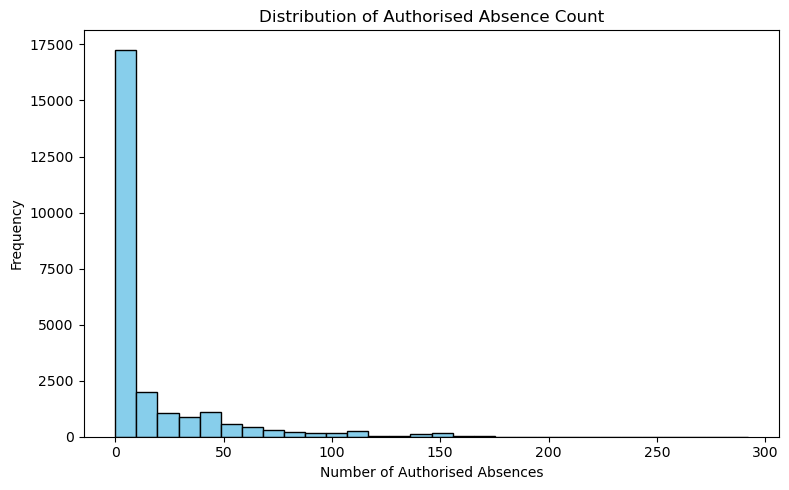

In [ ]:
# View distribution of Authorised Absence Count.
plt.figure(figsize=(8,5))
plt.hist(X_encoded_2['AuthorisedAbsenceCount'], bins=30, color='skyblue', edgecolor='black')
plt.title('Distribution of Authorised Absence Count')
plt.xlabel('Number of Authorised Absences')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

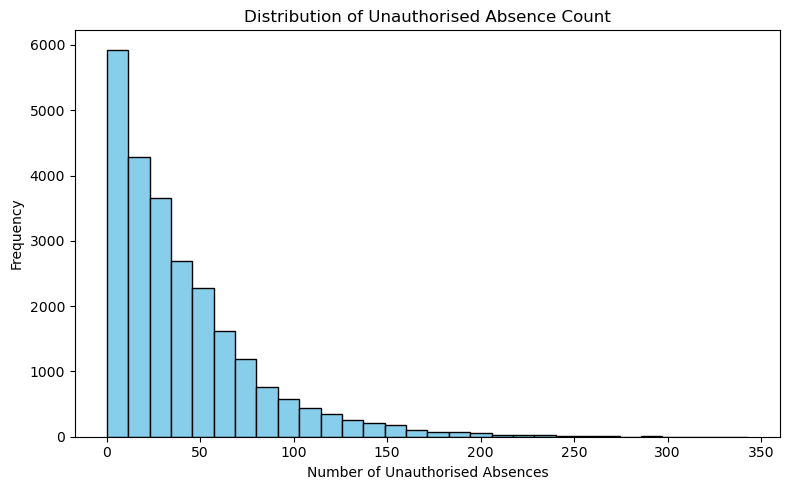

In [ ]:
# View distribution of Unauthorised absence count.
plt.figure(figsize=(8,5))
plt.hist(X_encoded_2['UnauthorisedAbsenceCount'], bins=30, color='skyblue', edgecolor='black')
plt.title('Distribution of Unauthorised Absence Count')
plt.xlabel('Number of Unauthorised Absences')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

Both 'AuthorisedAbsence' and 'UnauthorisedAbsence' show a right-skewed distribution and so the missing values will be imputed with the median value.

In [ ]:
# Impute missing values with median value.
median_imputer = SimpleImputer(strategy='median')

X_encoded_2[missing_cols] = median_imputer.fit_transform(X_encoded_2[missing_cols])

In [ ]:
# Verify the absence of missing values.
X_encoded_2.isnull().values.any()

False

### **2.1.5 Feature engineering**

In [ ]:
# Convert 'DateofBirth' column to datetime.
stage_2['DateofBirth'] = pd.to_datetime(stage_2['DateofBirth'], dayfirst=True)

# Convert DOB to age and add feature to X_encoded.
X_encoded_2['Age'] = (pd.to_datetime('today') - stage_2['DateofBirth']).dt.days // 365

print("Number of features:", X_encoded_2.shape[1])

Number of features: 391


In [ ]:
# Rename CompletedCourse to DroppedOut and convert to binary values.
# For CompletedCourse= Yes, DroppedOut= 0, for CompletedCourse= No, DroppedOut= 1
y_2= y_2.rename('DroppedOut').map({'Yes': 0, 'No': 1}).astype(int)

print("Target values:", y_2.unique())

Target values: [0 1]


As with the stage 1 data, the target feature 'CompletedCourse' was changed to 'DroppedOut' and was mapped accordingly (For CompletedCourse= Yes, DroppedOut= 0, for CompletedCourse= No, DroppedOut= 1) to better align with the goals of the project and allow more intuative interpretation.

### **2.1.6 Split the data**

In [ ]:
# Split the data into training and test set.
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X_encoded_2, y_2, test_size=0.2, stratify= y_2, random_state=seed)

## **2.2 XGBoost**

### **2.2.1 XGBoost (Baseline Model 3)**

To build on the findings from Stage 1, a baseline model was developed uisng the Stage 2 dataset. The model was trained using default hyperparameters, with the exception of the adjusted scale_pos_weight parameter to address class imbalance. This baseline serves as a new performance benchmark, allowing the evaluation of how the inclusion of engagement features impacts model performance.

**Key features of the Baseline Model 3:**
1. **scale_pos_weight:** This parameter is implemented to address class imbalance.
2. **Default Hyperparameters**
3. **Training Data:** Stage 2 dataset

In [ ]:
# Set seed.
set_seed(42)

In [ ]:
# Instantiate baseline XBGoost model on stage 2 data with scale_pos_weight.
xgb_model_3 = XGBClassifier(scale_pos_weight=scale_pos_weight,
                            random_state=seed,
                            n_jobs=1)

# Train on training dataset and evaluate model on test dataset.
xgb_model_3.fit(X_train_2, y_train_2)
xgb_3_evaluation, xgb_3_confusion_matrix = evaluate_model(xgb_model_3, X_test_2, y_test_2, 'XGBoost (Model 3)')

# View evaluation metrics.
xgb_3_evaluation

,Accuracy,AUC ROC,Recall,Precision,F1 Score
XGBoost (Model 3),0.87929,0.851678,0.81225,0.56797,0.668493


* **Accuracy:** Accuracy is high (87.9%) showing the model makes correct predictions nearly 88% of the time, although this may be misleading due to the class imbalance.
* **Recall:** Recall is high (81.2%) meaning it identifies 81% of all actual student dropouts.
* **Precision:** Precision indicates that over half (56.8%) of students flagged are actual dropout cases, keeping false positives at a reasonable level, while still catching most dropouts.
* **AUC:** AUC ROC is >0.8 showing the model has strong discriminatory ability.
* **F1 score:** Shows a good balance between recall and precision.

**Overall** This is a strong starting point for model tuning.

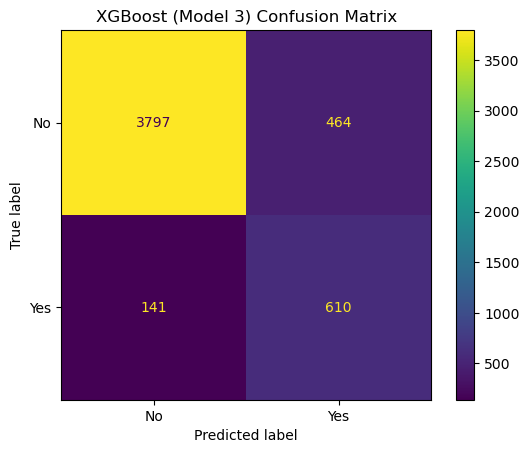

In [ ]:
# View confusion matrix.
xgb_3_cfmd = plot_confusion_matrix(xgb_3_confusion_matrix, title='XGBoost (Model 3) Confusion Matrix')

* **True Negatives** = 3797, the model correctly predicted 3797 cases of students not dropping out.
* **False Negatives** = 141, the model missed 141 cases student drop out- this is the key factor to decrease so dropout cases are not missed.
* **False Positive** = 464, the model identified 464 cases where it predicted the student would drop out but they didn't.
* **True Positives** = 610, the model correctly predicted 610 cases of student drop out.

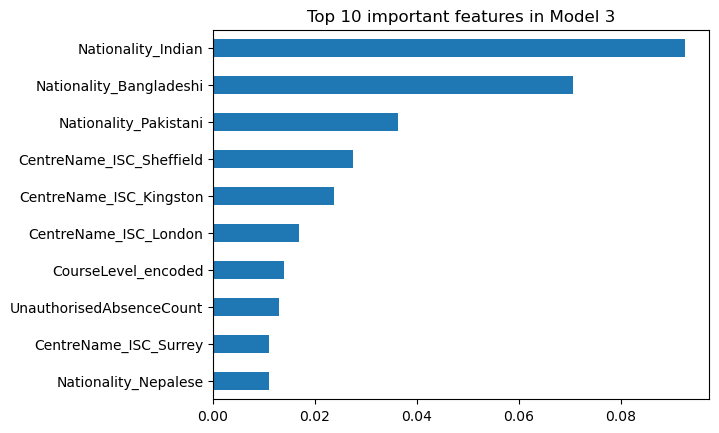

In [ ]:
# Extract feature importances for model 3.
feature_importance_3 = pd.Series(xgb_model_3.feature_importances_, index=X_train_2.columns).sort_values()

# View plot of top 10 importance features for readability.
feature_importance_3.iloc[-10:].plot.barh()
plt.title('Top 10 important features in Model 3')
plt.show()

In Model 3, the most influential features for predicting student dropout were 'Nationality_Bangladeshi', 'Nationality_Indian' and 'Nationality_Pakistani', similar to Model 1 and 2. This could raise concerns for potential bias in the model and may require further investigation into the fairness and ethical implications of using certain demographic features in predictive models.

Unauthorised absence count is also in the top 10 important features indicating that the new feature included in the stage 2 dataset has strong influence on the model's predictions.

### **2.2.4 XGBoost Stage 1 vs Stage 2 Baseline Model Comparison**

To assess the impact of additional student engagement features on dropout prediction, the baseline models trained on Stage 1 and Stage 2 datasets were compared. The baseline models (same architecture) were selected for this comparison to remove the potential effects of hyperparameter tuning on model performance so the effects of additional features could be evaluated in isolation.

**Models:**
* **XGBoost Model 1** = XGBoost baseline model trained on stage 1 data
* **XGBoost Model 3** = XGBoost baseline model trained on stage 2 data

In [ ]:
# View summary evaluation metrics for XGBooost models 3 (baseline) and 4 (tuned) for comparison.
xgb_model_comparison_stage_1_2 = pd.concat([xgb_1_evaluation, xgb_3_evaluation])
xgb_model_comparison_stage_1_2

,Accuracy,AUC ROC,Recall,Precision,F1 Score
XGBoost (Model 1),0.857143,0.820006,0.766977,0.515667,0.616702
XGBoost (Model 3),0.879290,0.851678,0.812250,0.567970,0.668493


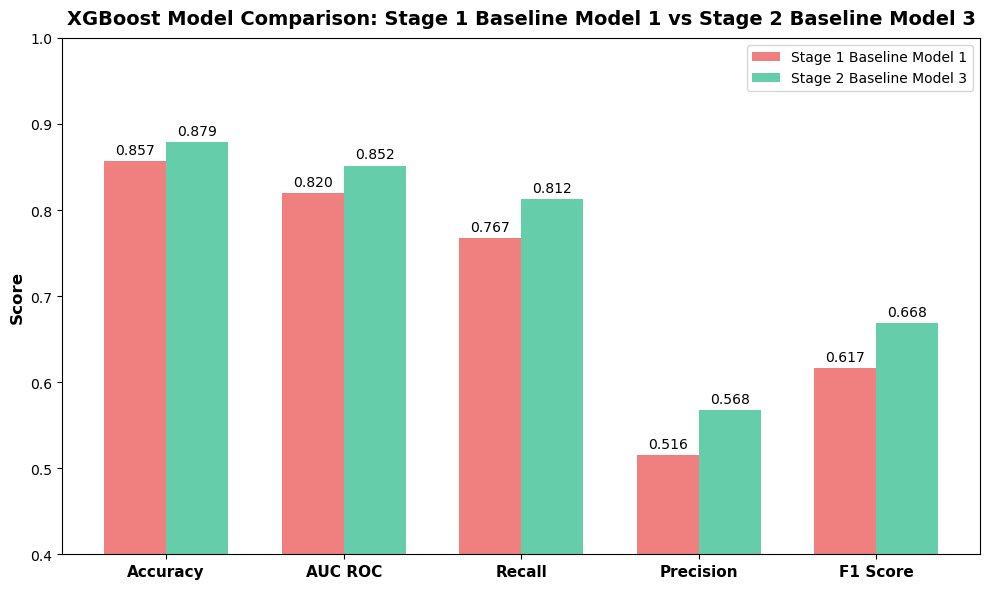

In [ ]:
# View summary evaluation metrics as a bar plot for comparison.
plot_bar_comparison(model= 'XGBoost',
                    model_1_name ='Stage 1 Baseline Model 1',
                    model_1_evaluation=xgb_1_evaluation,
                    model_2_name= 'Stage 2 Baseline Model 3',
                    model_2_evaluation=xgb_3_evaluation)

* Model 3 (trained on stage 2 data) provides a notable improvement to all performance metrics including recall (76.7% to 81.2%)
* Typically, increasing recall leads to lower precision due to the likelihood of more false positives, however, model 3 improved both recall and precision. This is a strong sign of a improved predictive power from the Stage 2 features.

The performance difference between the Stage 1 and Stage 2 baseline models can be attributed to the additional information available in the Stage 2 dataset, specifically the inclusion of the student engagement features: 'AuthorisedAbsenceCount' and 'UnauthorisedAbsenceCount'. These features provide insight into the student's attendance behaviour, offering a more direct insight into student disengagement, which is a strong predictor of dropout. In contrast, the Stage 1 dataset includes only background information which are indirect predictors of dropout and do not reflect actual student actions or fully capture risk.

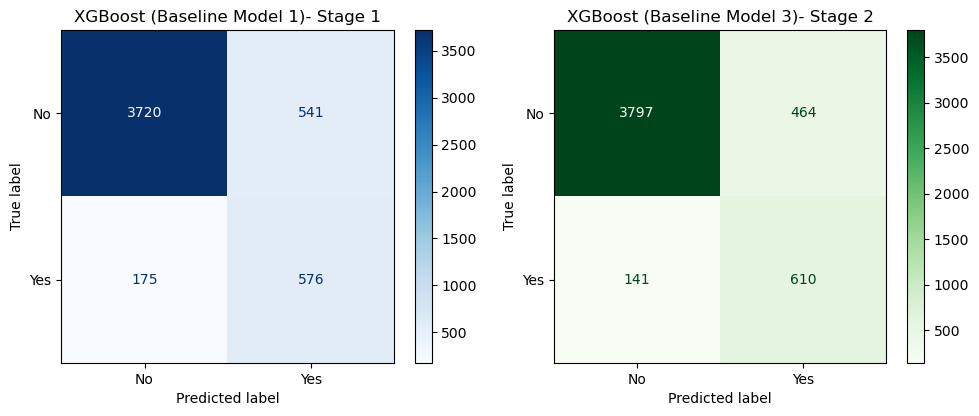

In [ ]:
# Compare confusion matrix for XGBooost models 1 (baseline- stage 1 data) and 3 (baseline- stage 2 data) for comparison.
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

ConfusionMatrixDisplay(
    confusion_matrix=xgb_1_confusion_matrix,
    display_labels=['No', 'Yes']
).plot(ax=axes[0], cmap='Blues')
axes[0].set_title('XGBoost (Baseline Model 1)- Stage 1')

ConfusionMatrixDisplay(
    confusion_matrix=xgb_3_confusion_matrix,
    display_labels=['No', 'Yes']
).plot(ax=axes[1], cmap='Greens')
axes[1].set_title('XGBoost (Baseline Model 3)- Stage 2')

plt.tight_layout()
plt.show()

* Model 2 gave better and more correct results across all predictions, with more true positives and negatives and fewer false positives and false negatives.

### **2.2.2 XGBoost (Tuned Model 4)- Best Recall**

Building on the Stage 2 baseline model, a tuned XGBoost model was developed to explore whether optimising hyperparameters could further improve dropout prediction performance. The hyperparameters tuned included learning_rate, max_depth and n_estimators and once the best performing configuration was identified, the model was evaluated on an unseen test set to assess generalisation performance.

**Key features of the Tuned Model 2:**
1. **scale_pos_weight:** This parameter is implemented to address class imbalance.
2. **Tuned Hyperparameters:** Optimised for recall score.
3. **Training Data:** Stage 2 dataset

In [ ]:
# Set seed.
set_seed(42)

In [ ]:
# Instantiate XBGoost model 4 with scale_pos_weight.
xgb_model_4 = XGBClassifier(scale_pos_weight=scale_pos_weight,
                            random_state=seed,
                            n_jobs=1)

In [ ]:
# Tune XGBoost hyperparameters on stage 2 dataset: learning rate, max depth and number of estimators.
# Define parameter grid of parameters and respective values to test.
param_grid = {'learning_rate': [0.01, 0.05, 0.1],
              'max_depth': [3, 5, 7],
              'n_estimators': [200, 500, 700]}

# Run grid search with recall set as scoring metric.
grid_2 = GridSearchCV(estimator=xgb_model_4,
                      param_grid=param_grid,
                      scoring='recall',
                      cv=cv,
                      n_jobs=-1)

# Fit to training data.
grid_2.fit(X_train_2, y_train_2)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, feature_weights=None,
                                     gamma=None, grow_polic...
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=1, num_parallel_tree=None, ...),
             n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.05, 0.1],
                         'max_depth': [3, 5, 7],
                         'n_estimators': [200, 500, 700]},
             scoring='recall')

In [ ]:
# View the best results.
print("Best Parameters:", grid_2.best_params_)
print("Best Recall Score", grid_2.best_score_)
xgb_model_4 = grid_2.best_estimator_

Best Parameters: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 500}
Best Recall Score 0.8171680532445924


* A grid search of learning rate, max depth and n_estimators, with recall set as the scoring method, identified that the best combination of hyperparameter values is 0.05, 3 and 500 respectively.
* Implementing these optimised hyperparameters increased recall from 79.2% in the baseline model to 81.7% (evaluated on the validation dataset).

In [ ]:
# Evaluate the best model on the test data.
xgb_4_evaluation, xgb_4_confusion_matrix = evaluate_model(xgb_model_4, X_test_2, y_test_2, 'XGBoost (Model 4)')
xgb_4_evaluation

,Accuracy,AUC ROC,Recall,Precision,F1 Score
XGBoost (Model 4),0.859737,0.842372,0.817577,0.520339,0.63594


* **Accuracy:** 86.0 % of predictions are correct, however this can be a misleading metric due to class imbalance
* **AUC (ROC):** AUC > 0.8 is typically considered strong so model shows good overall discrimination between dropouts and non-dropouts
* **Recall:** Indicates 81.8 % of actual dropouts are correctly identified (key success metric)
* **Precision:** 52.0 % of students predicted as dropouts are actually dropouts.
* **F1 Score:** Resonable score of 0.64 considering recall is being prioritised.

**Overall** Model has high recall (good for catching dropout cases) with the trade-off of lower precision which means more students are being flagged incorrectly as dropouts. This could be acceptable if false positives are less concerning.

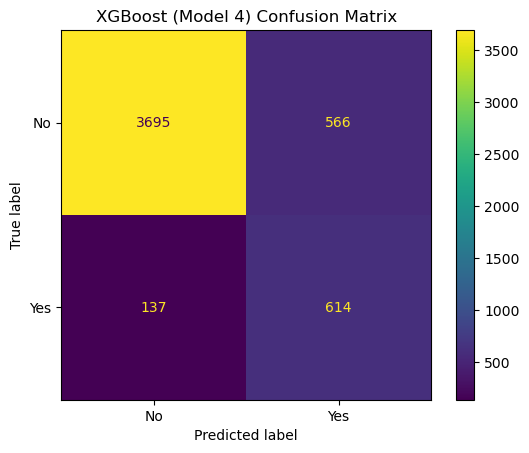

In [ ]:
# View confusion matrix.
xgb_4_cfmd = plot_confusion_matrix(xgb_4_confusion_matrix, title='XGBoost (Model 4) Confusion Matrix')

* **True Negatives** = 3695, the model correctly predicted 3695 cases of students not dropping out.
* **False Negatives** = 137, the model missed 172 cases student drop out- this is the key factor to decrease so dropout cases are not missed.
* **False Positive** = 566, the model identified 566 cases where it predicted the student would drop out but they didn't.
* **True Positives** = 614, the model correctly predicted 614 cases of student drop out.

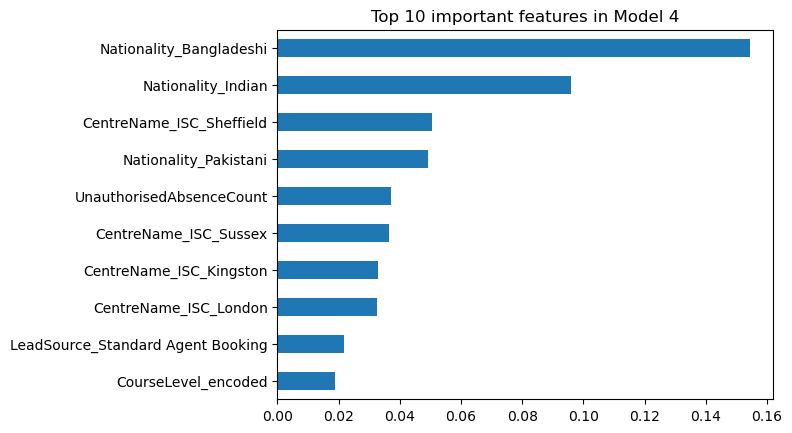

In [ ]:
# Extract feature importances for model 4.
feature_importance_4 = pd.Series(xgb_model_4.feature_importances_, index=X_train_2.columns).sort_values()

# View plot of top 10 importance features for readability.
feature_importance_4.iloc[-10:].plot.barh()
plt.title('Top 10 important features in Model 4')
plt.show()

Model 4 has slightly different feature importance rankings with Sheffield in the Centre Name cateogory and the new feature: UnauthorisedAbsenceCount being ranked higher, indicating they are more influential in the predictions of Model 4.

### **2.2.3 XGBoost Baseline vs Tuned Model (Stage 2)**

To evaluate the effectiveness of hyperparameter tuning, the performance of the tuned XGboost (Model 4) was compared against the baseline model (Model 3) trained on the Stage 2 dataset. The key objective of this comparison is to assess whether optimising model parameters lead to a improvement in model performance when predicting student dropout.

**Models:**
* **XGBoost Model 3** = XGBoost baseline model trained on stage 2 data
* **XGBoost Model 4** = XGBoost tuned model (optimised Recall) trained on stage 2 data

In [ ]:
# View summary evaluation metrics for XGBooost models 3 (baseline) and 4 (tuned) for comparison.
xgb_comparison_stage_2 = pd.concat([xgb_3_evaluation, xgb_4_evaluation])
xgb_comparison_stage_2

,Accuracy,AUC ROC,Recall,Precision,F1 Score
XGBoost (Model 3),0.879290,0.851678,0.812250,0.567970,0.668493
XGBoost (Model 4),0.859737,0.842372,0.817577,0.520339,0.635940


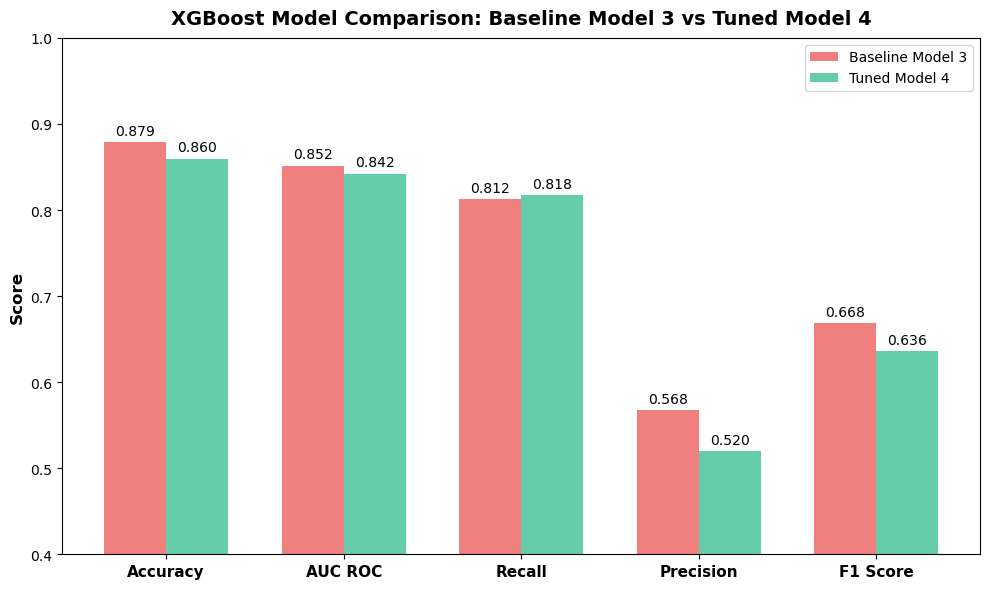

In [ ]:
# View summary evaluation metrics as a bar plot for comparison.
plot_bar_comparison(model= 'XGBoost',
                    model_1_name ='Baseline Model 3',
                    model_1_evaluation=xgb_3_evaluation,
                    model_2_name='Tuned Model 4',
                    model_2_evaluation=xgb_4_evaluation)

* Model 4 has the highest recall (81.8%) which maximises dropout detection, however the gain is only marginal, suggesting tuning did not significantly improve catching dropouts.
* Model 3 has slightly higher metric scores over accuracy, precision and F1 score, with precision being notably higher, suggesting fewer false positives.
* Overall, hyperparameter tuning lead to modest improvements in recall for Model 4 however sacrified precious and balance. As Model 3 outperformed Model 4 on all other metrics, the tuned Model doesn't justify the trade-offs for slightly increased recall.

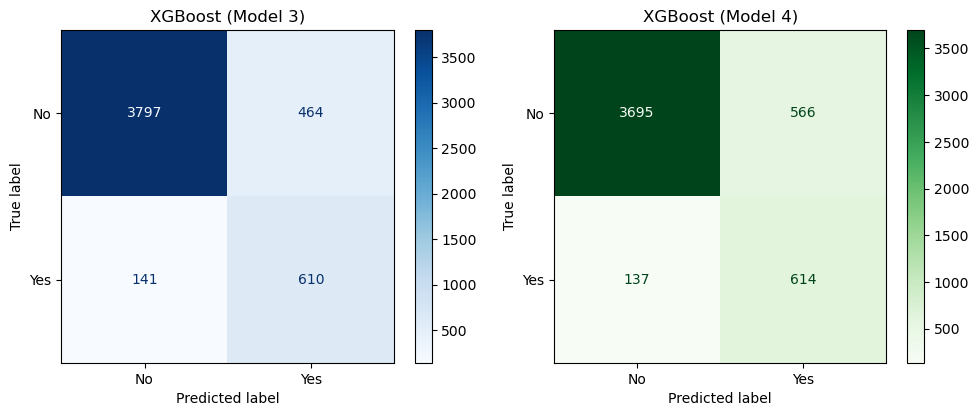

In [ ]:
# Compare confusion matrix for XGBooost models 3 (baseline) and 4 (tuned) for comparison.
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

ConfusionMatrixDisplay(
    confusion_matrix=xgb_3_confusion_matrix,
    display_labels=['No', 'Yes']
).plot(ax=axes[0], cmap='Blues')
axes[0].set_title('XGBoost (Model 3)')

ConfusionMatrixDisplay(
    confusion_matrix=xgb_4_confusion_matrix,
    display_labels=['No', 'Yes']
).plot(ax=axes[1], cmap='Greens')
axes[1].set_title('XGBoost (Model 4)')

plt.tight_layout()
plt.show()

* Model 4 (tuned) gave fewer false negatives (137), which is key to reduce, compare to model 1 (141), meaning Model 2 missed fewer dropout cases, although the difference is very minor.
* Model 3 (baseline) gave fewer false positives (464) compared to Model 2 (566), meaning Model 1 predicted fewer students as dropout cases when they actually were not dropouts. Depending on the expense of early intervention when it is unecessary, this may not necessarily be a negative.

## **2.3 Neural Networks**

### **2.3.1 Preprocessing**

In [ ]:
# Split training dataset into training and validation.
X_train_2, X_valid_2, y_train_2, y_valid_2 = train_test_split(X_train_2, y_train_2, test_size=0.2, stratify= y_train_2, random_state=seed)

In [ ]:
# Standardise the data.
std = StandardScaler()

X_train_2 = std.fit_transform(X_train_2)
X_valid_2 = std.transform(X_valid_2)
X_test_2 = std.transform(X_test_2)

### **2.3.2 Neural Network (Baseline Model 3)**

A baseline neural network model was developed using the Stage 2 dataset which included an expanded set of input features. This increase in dimensionality was accounted for by passing the X_train_2 dataset into the neural network creation function which can dynamically calculate the input shape based on feature dimensions. The model was trained using default parameters with the exception of class weighting to address the imbalance of the target variable, l2 regularisation and early stopping to reduce the risk of overfitting. Evaluation focused primarily on recall, but other key metrics such as F1 score, ROC AUC and precision were also considered.

**Key features of the baseline model:**
1. **Class weighting:** Included to address class imbalance by assigning higher importance to the minority class (in this case Class 1, student dropouts).
2. **L2 regularisation:** Included to penalise large weights to reduce overfitting and improve generalisation.
3. **Early Stopping:** Set to monitor the performance of the validation dataset and to halt training when no further improvement occurs to prevent overfitting and save computational resources.
4. **Training Data:** Stage 2 data

In [ ]:
# Set seed.
set_seed(42)

In [ ]:
# Create baseline neural network (Model 3).
nn_model_3, history_3 = create_nn_model(X_train_2, y_train_2,
                                        X_valid_2, y_valid_2,
                                        optimizer= 'adam',
                                        activation = 'relu',
                                        neuron_layer_1=16,
                                        neuron_layer_2=16,
                                        batch_size=128,
                                        regularizer=l2_regularizer,
                                        callback=early_stopping,
                                        class_weight=class_weights)

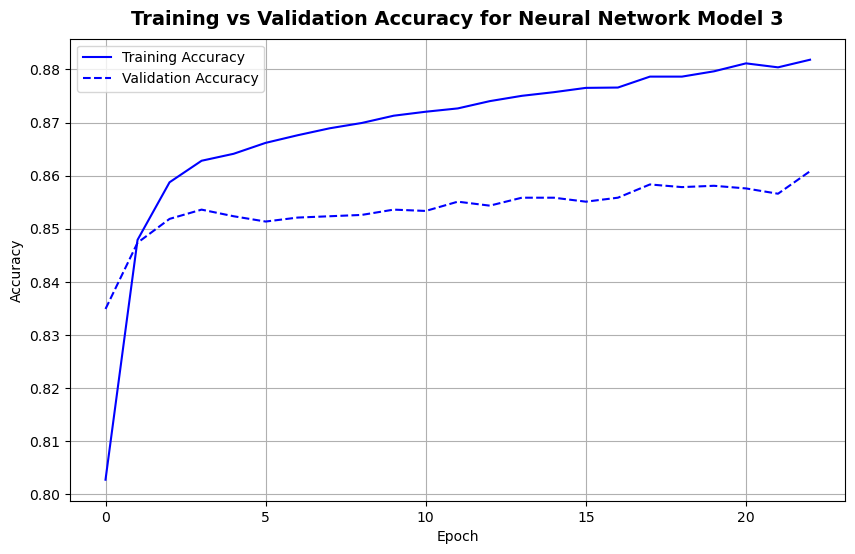

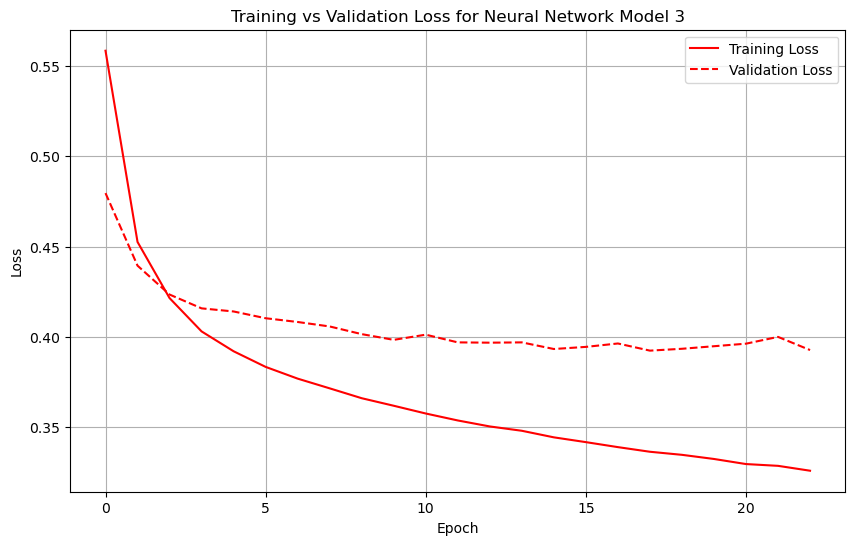

In [ ]:
# Plot loss and accuracy curves for Model 3.
plot_curve(history_3, model_name= 'Model 3')

Increasing training accuracy and decreasing training loss suggests the model is still learning the training data, however, divergence of the validation accuracy and loss from the training accuracy and loss suggested that the model is overfitting, and not performing as well on unseen data.

In [ ]:
# Evaluate the performance of Model 3 on the test data.
nn_3_evaluation, nn_3_confusion_matrix = evaluate_nn_model(nn_model_3, X_test_2, y_test_2, model_name='Neural Network (Model 3)')

# View evaluation metrics.
nn_3_evaluation

,Accuracy,AUC ROC,Recall,Precision,F1 Score
Neural Network (Model 3),0.86233,0.843897,0.817577,0.526135,0.64025


* **Recall:** High recall (81.8%) suggests that nearlu 82% of dropouts are correctly identified.
* **Precision:** Precision (52.5%) is reasonable considering recall is being prioritied.
* **F1 Score:** 0.64 suggests a reasonable balance between precision and recall considering recall is being prioritised.
* **AUC ROC:** Score is > 0.8 suggesting the model has strong discriminatory power being dropouts and non-dropouts.

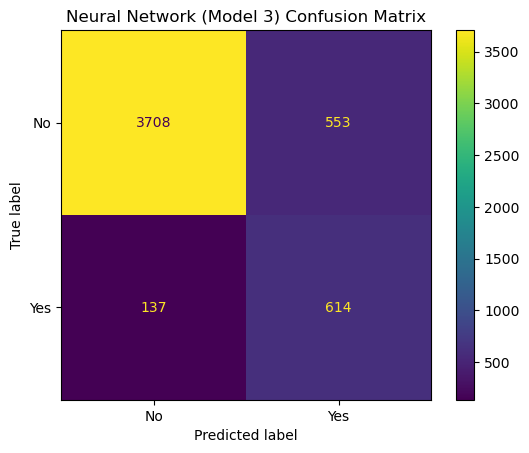

In [ ]:
# View Model 4 confusion matrix.
nn_3_cfmd = plot_confusion_matrix(nn_3_confusion_matrix, title='Neural Network (Model 3) Confusion Matrix')

* **True Negatives** = 3708, the model correctly predicted 3708 cases of students not dropping out.
* **False Negatives** = 137, the model missed 137 cases student drop out- this is the key factor to decrease so dropout cases are not missed.
* **False Positive** = 553, the model identified 553 cases where it predicted the student would drop out but they didn't.
* **True Positives** = 614, the model correctly predicted 614 cases of student drop out.

### **2.3.3 Neural Network Stage 1 vs Stage 2 Baseline Model Comparison**

To explore the effect of additional features in the training dataset on the neural network models, the performance of the baseline models trained on stage 1 data and stage 2 data were compared. The baseline models (same architecture) were selected for this comparison to remove the potential effects of hyperparameter tuning leading to different model architectures.

**Models:**
* Neural Network Model 1 = Neural Network baseline model trained on stage 1 data
* Neural Network Model 3 = Neural Network baseline model trained on stage 2 data

In [ ]:
# View summary evaluation metrics for models 3 and 4 for comparison.
nn_comparison_stage_1_2 = pd.concat([nn_1_evaluation, nn_3_evaluation])
nn_comparison_stage_1_2

,Accuracy,AUC ROC,Recall,Precision,F1 Score
Neural Network (Model 1),0.841381,0.816769,0.781625,0.481938,0.596242
Neural Network (Model 3),0.862330,0.843897,0.817577,0.526135,0.640250


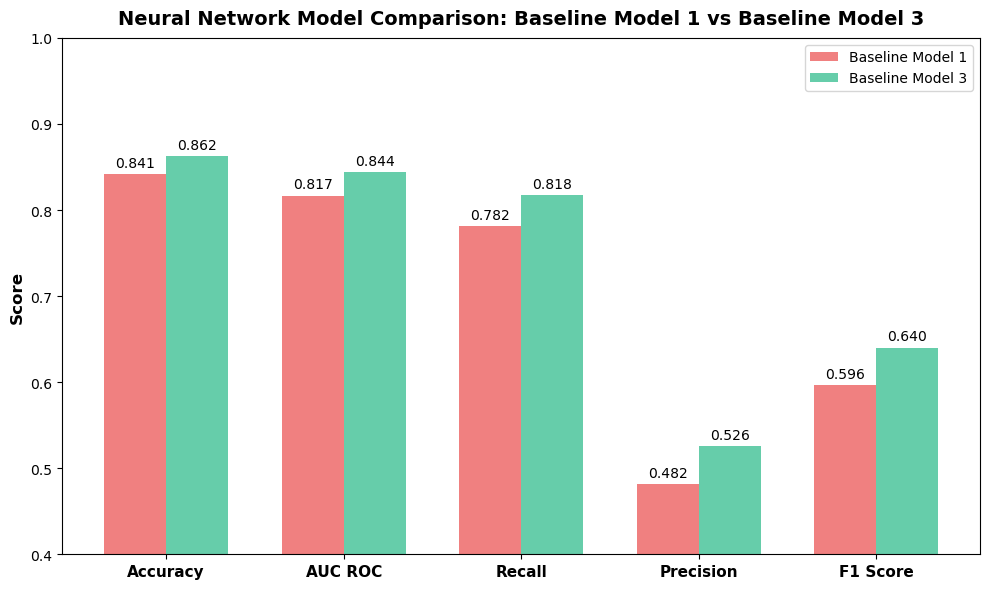

In [ ]:
# View summary evaluation metrics as a bar plot for comparison.
plot_bar_comparison(model= 'Neural Network',
                    model_1_name='Baseline Model 1',
                    model_1_evaluation=nn_1_evaluation,
                    model_2_name='Baseline Model 3',
                    model_2_evaluation=nn_3_evaluation)

* Stage 2 baseline model outperformed Stage 1 baseline model across key metrics, particularly recall (81.8% vs 78.2%), indicating improved sensitivity to identifying at-risk students.
* Other metrics such as F1 score, ROC AUC and accuracy also showed improvement, suggesting the model was able to balance dropout detection with good predictive accuracy.

As discussed when comparing the XGBoost baseline models of Stage 1 vs Stage 2, the improved performance of the Stage 2 neural network baseline model can be attributed to the inclusion of the behavioural engagement data as these features provide greater predictive power of student dropout risk compared to the background pre-enrolement information contained in Stage 1 that do not provide details of student actions and so are weaker predictors of dropout.

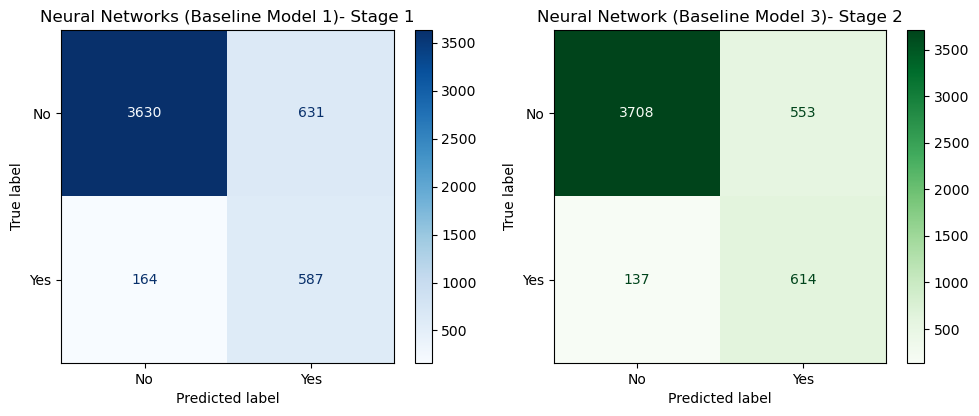

In [ ]:
# Compare confusion matrix for Neural Network models 1 (baseline- stage 1 data) and 3 (baseline- stage 2 data) for comparison.
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

ConfusionMatrixDisplay(
    confusion_matrix=nn_1_confusion_matrix,
    display_labels=['No', 'Yes']
).plot(ax=axes[0], cmap='Blues')
axes[0].set_title('Neural Networks (Baseline Model 1)- Stage 1')

ConfusionMatrixDisplay(
    confusion_matrix=nn_3_confusion_matrix,
    display_labels=['No', 'Yes']
).plot(ax=axes[1], cmap='Greens')
axes[1].set_title('Neural Network (Baseline Model 3)- Stage 2')

plt.tight_layout()
plt.show()

* Model 3 outperformed Model 1, giving more correct predictions (true positives and negatives) and fewer incorrect predictions (false negatives and positives)

### **2.3.4 Hyperparameter Tuning**

To improve the performance of the baseline model trained on stage 2 data, hyperperameter tuning was carried out on the choice of optimizer, activation functions, number of neurons in hidden layer 1 and 2, and the batch size.

In [ ]:
# Set seed.
set_seed(42)

In [ ]:
# Define hyperparameter ranges to test.
optimizers = ['adam', 'rmsprop']
activations = ['relu', 'tanh']
neuron_1 = [128, 64, 32]
neuron_2 = [64, 32, 16]
batch_sizes = [32, 64, 128]

results_2 = []

# Create a for loop for each hyperparameter vector.
for o in optimizers:
    for act in activations:
        for n1 in neuron_1:
            for n2 in neuron_2:
                for bs in batch_sizes:
                    tuned_model, tuned_history = create_nn_model(X_train_2, y_train_2,
                                                                 X_valid_2, y_valid_2,
                                                                 optimizer=o,
                                                                 activation=act,
                                                                 neuron_layer_1=n1,
                                                                 neuron_layer_2=n2,
                                                                 batch_size = bs,
                                                                 regularizer=l2_regularizer,
                                                                 callback=early_stopping,
                                                                 class_weight=class_weights)

                    # Evaluate the models on the validation data.
                    accuracy, recall, f1, auc, prec = hyperparameter_evaluation(tuned_model, X_valid_2, y_valid_2)

                    # Add evaluation metrics of each model to results_2
                    results_2.append({'Optimizer': o,
                                      'Activation': act,
                                      'Layer 1 Neurons': n1,
                                      'Layer 2 Neurons': n2,
                                      'Batch size': bs,
                                      'Recall': recall,
                                      'Accuracy': accuracy,
                                      'F1 Score': f1,
                                      'ROC AUC': auc,
                                      'Precision': prec})

126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 333us/step
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 328us/step
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 346us/step
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 322us/step
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 320us/step
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 326us/step
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 317us/step
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 309us/step
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 323us/step
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 303us/step
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 317us/step
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 306us/step
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 307us/step
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 300us/step
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 313us/step
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 299us/step
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 296us/step
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 378us/step
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 289us/step
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 289us/step
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 292us/step
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 290us/step
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 286us/step
126/126 ━━━

In [ ]:
# Convert results to a dataframe.
results_2_df = pd.DataFrame(results_2)

# Find the parameter combinations corresponding to the highest value of each metric.
best_accuracy_2 = results_2_df.loc[results_2_df['Accuracy'].idxmax()]
best_recall_2 = results_2_df.loc[results_2_df['Recall'].idxmax()]
best_f1_2 = results_2_df.loc[results_2_df['F1 Score'].idxmax()]
best_auc_2 = results_2_df.loc[results_2_df['ROC AUC'].idxmax()]
best_prec_2 = results_2_df.loc[results_2_df['Precision'].idxmax()]

# Create a summary table with the best parameters and metric values.
results_summary_2 = pd.DataFrame([best_accuracy_2, best_recall_2, best_f1_2, best_auc_2, best_prec_2],
                                 index=['Best Accuracy', 'Best Recall', 'Best F1 Score', 'Best ROC AUC', 'Best Precision'])

# View results
results_summary_2

,Optimizer,Activation,Layer 1 Neurons,Layer 2 Neurons,Batch size,Recall,Accuracy,F1 Score,ROC AUC,Precision
Best Accuracy,adam,relu,32,16,128,0.770383,0.863840,0.629076,0.825350,0.531573
Best Recall,rmsprop,tanh,32,16,128,0.800333,0.844638,0.606940,0.826391,0.488821
Best F1 Score,adam,relu,32,16,128,0.770383,0.863840,0.629076,0.825350,0.531573
Best ROC AUC,rmsprop,tanh,32,16,128,0.800333,0.844638,0.606940,0.826391,0.488821
Best Precision,adam,relu,32,16,128,0.770383,0.863840,0.629076,0.825350,0.531573


* Highest recall gives a solid recall score (80.0%) meaning the model rarely misses a positive case.
* Best ROC AUC also gave the same parameter combination and indicating the model has strong class discriminatory power.
* Precision is moderate for the highest recall parameters (48.9%) which can be considered acceptable in the buisness context.

### **2.3.5 Neural Network (Tuned Model 4)- Best Recall**

The best combination of parameters identified during hyperparameter tuning were then implemented in a second neural network model, which was then evaluated on an unseen test dataset to provide an unbiased assessment of its generalisation performance.

**Key features of the Model 4:**
1. **Baseline model features:** Class weighting, L2 regularisation and early stopping.
2. **Tuned parameters:** Includes the tuned hyperparameters that have the best recall score, whilst still maintaining good value of other metrics
3. **Trained on stage 2 data**

In [ ]:
# Extract the best results of the grid search based on highest recall.
best_recall_optimizer_2 = best_recall_2['Optimizer']
best_recall_activation_2 = best_recall_2['Activation']
best_recall_l1_neurons_2 = best_recall_2['Layer 1 Neurons']
best_recall_l2_neurons_2 = best_recall_2['Layer 2 Neurons']
best_recall_bs_2 = best_recall_2['Batch size']

In [ ]:
# Set seed.
set_seed(42)

In [ ]:
 # Create and train model on parameters that gave highest recall.
nn_model_4, history_4 = create_nn_model(X_train_2, y_train_2,
                                        X_valid_2, y_valid_2,
                                        optimizer=best_recall_optimizer_2,
                                        activation=best_recall_activation_2,
                                        neuron_layer_1=best_recall_l1_neurons_2,
                                        neuron_layer_2=best_recall_l2_neurons_2,
                                        batch_size=best_recall_bs_2,
                                        regularizer=l2_regularizer,
                                        callback=early_stopping,
                                        class_weight= class_weights)

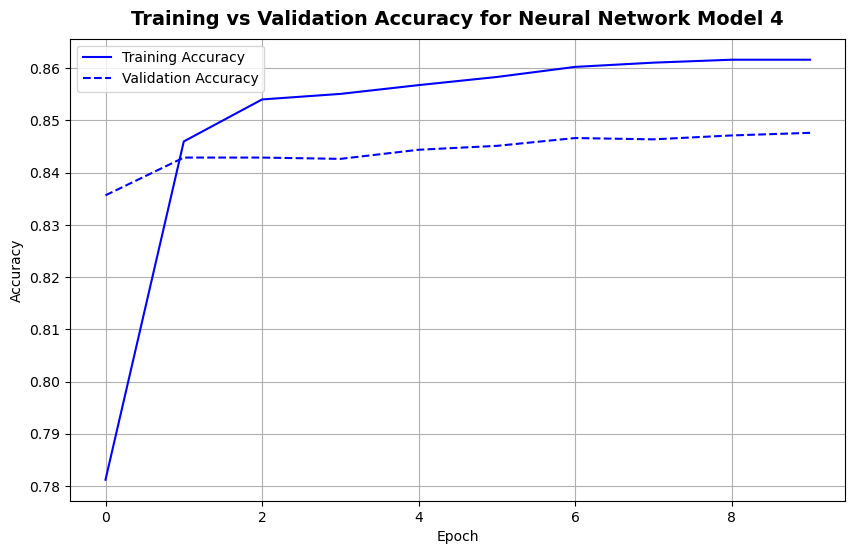

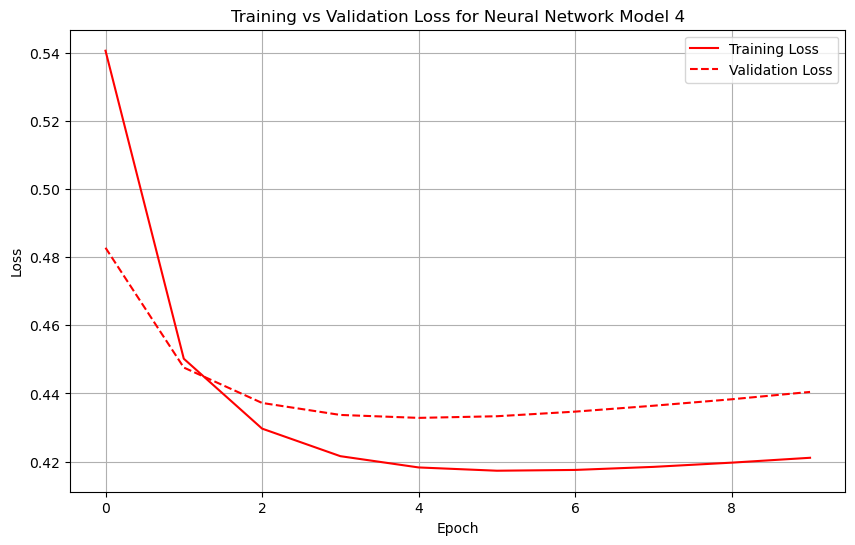

In [ ]:
# Plot loss and accuracy curves for tuned model.
plot_curve(history_4, model_name= 'Model 4')

The model appears to be exhibiting early signs of overfitting with the minor divergence trend observed for both validation accuracy and loss. The training accuracy also appears to plataeu and the training loss starts to slightly increase also suggesting the model is starting to overfit and no further performance gains are being achieved.

In [ ]:
# Evaluate the tuned model on the test data.
nn_4_evaluation, nn_4_confusion_matrix = evaluate_nn_model(nn_model_4, X_test_2, y_test_2, model_name='Neural Network (Model 4)')
nn_4_evaluation

,Accuracy,AUC ROC,Recall,Precision,F1 Score
Neural Network (Model 4),0.849761,0.837053,0.818908,0.499188,0.620272


* **Accuracy:** is strong (85.0%) but could be misleadingly high due to dataset imbalance.
* **Recall:** Strong recall performance (81.9%), in line with the top performing models so far.
* **Precision:** Precision is moderate (50.0%) indicating roughly half of the predicted dropouts are correct.
* **ROC AUC:** Score is > 0.8 suggesting good discriminative power.
* **F1 Score:** Shows reasonable balance.

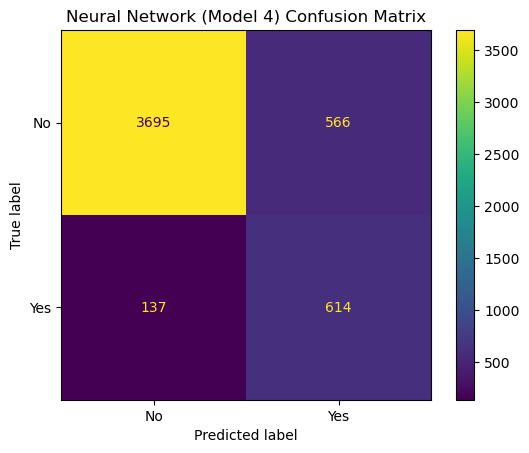

In [ ]:
# Plot confusion matrix.
xgb_4_cmfd = plot_confusion_matrix(xgb_4_confusion_matrix, title='Neural Network (Model 4) Confusion Matrix')

* **True Negatives** = 3695, the model correctly predicted 3695 cases of students not dropping out.
* **False Negatives** = 137, the model missed 137 cases student drop out- this is the key factor to decrease so dropout cases are not missed.
* **False Positive** = 566, the model identified 566 cases where it predicted the student would drop out but they didn't.
* **True Positives** = 614, the model correctly predicted 614 cases of student drop out.

### **2.3.5 Neural Network Baseline vs Tuned Model (Stage 2)**

To evaluate the impact of hyperparameter tuning on model performance, the tuned neural network model (Model 4) was compared to its corresponding baseline version (Model 3) to determine if tuning led to meaningful improvements in model performance using the Stage 1 datasets.

**Models:**
* Neural Network Model 3 = Neural Network baseline model trained on stage 2 data
* Neural Network Model 4 = Neural Network tuned model (Recall optimised) trained on stage 2 data

In [ ]:
# View summary evaluation metrics for models 3 and 4 for comparison.
nn_3_comparison = pd.concat([nn_3_evaluation, nn_4_evaluation])
nn_3_comparison

,Accuracy,AUC ROC,Recall,Precision,F1 Score
Neural Network (Model 3),0.862330,0.843897,0.817577,0.526135,0.640250
Neural Network (Model 4),0.849761,0.837053,0.818908,0.499188,0.620272


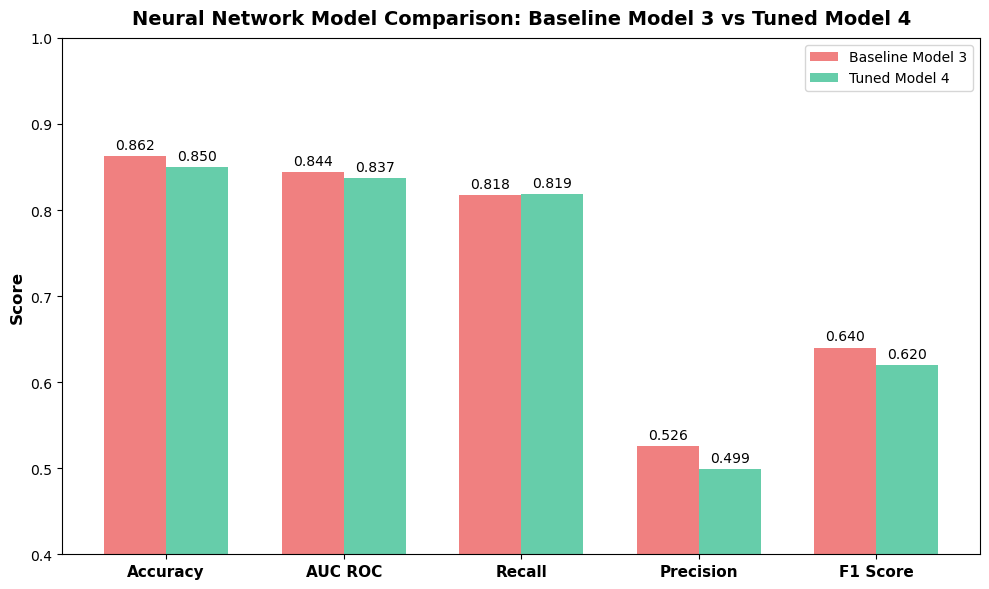

In [ ]:
# View summary evaluation metrics as a bar plot for comparison.
plot_bar_comparison(model= 'Neural Network',
                    model_1_name='Baseline Model 3',
                    model_1_evaluation=nn_3_evaluation,
                    model_2_name='Tuned Model 4',
                    model_2_evaluation=nn_4_evaluation)

* Model 4 has slightly higher recall (81.9% vs 81.8%) but the difference is statistically negligible. This comes with a trade-off in precision and F1 score.
* Model 3 has better AUC ROC indicating a more stable decision boundary across different thresholds.

**Overall:** Model performance was not improved following hyperparameter tuning suggesting either the baseline hyperparameters were suitable or different hyperparameter ranges need to be tested.

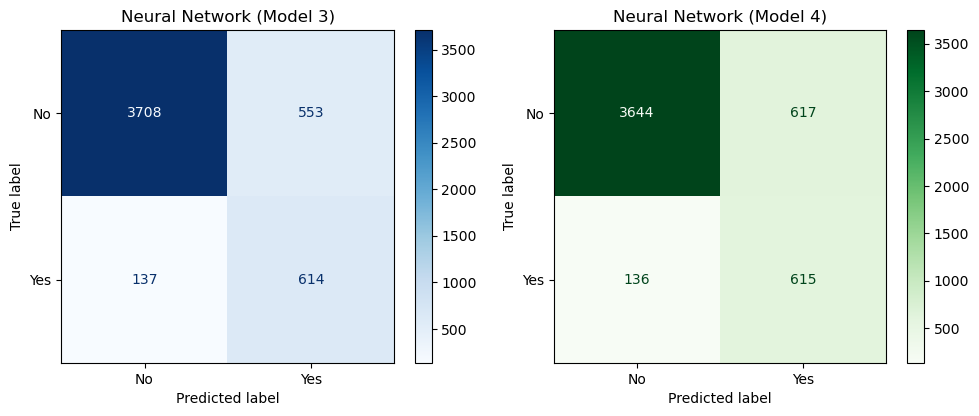

In [ ]:
# Compare confusion matrix for Neural Network models 3 (baseline) and 4 (tuned) for comparison.
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

ConfusionMatrixDisplay(
    confusion_matrix=nn_3_confusion_matrix,
    display_labels=['No', 'Yes']
).plot(ax=axes[0], cmap='Blues')
axes[0].set_title('Neural Network (Model 3)')

ConfusionMatrixDisplay(
    confusion_matrix=nn_4_confusion_matrix,
    display_labels=['No', 'Yes']
).plot(ax=axes[1], cmap='Greens')
axes[1].set_title('Neural Network (Model 4)')

plt.tight_layout()
plt.show()

* Model 3 gave fewer false positives (553 vs 617) and more correct predictions (true positives and negatives), while giving a similar false negative count to Model 4.

## **2.4 Stage 2 Conclusions**

The Stage 2 dataset introduced key student engagement features: 'AuthorisedAbsenceCount' and 'UnauthorisedAbsenceCount' to assess whether the inclusion of additional predictive features could enhance dropout prediction performance. Both neural networks and XGBoost models were evaluated in their baseline and tuned forms to measure the impact of these additional features and hyperparameter optimisation.
* `The addition of attendence based engagement features in the Stage 2 dataset led to a notable improvement in performance across both XGBoost and Neural network baseline models (compared to Stage 1), particuarly in recall, the primary business metric for identifying at-risk students. This confirms that feature quality is a key driving of performance in dropout prediction.
* Hyperparameter tuning lead to modest gains in recall and at the expense of overall balance suggesting either the baseline parameters were already well suited or different hyperparameter ranges should be tested.

# **3. Stage 3 Data**

The Stage 3 dataset includes all the features from Stages 1 and 2, supplemented with academic performance data such as assessment results, specifically the features 'AssessedModules', 'PassedModules' and 'FailedModules'. This represents the most comprehensive view of a student's progress and is typically available later in the academic year. While it gives the most informed dropout predictions, this information is typically only available close to when a student may dropout.

## **3.1 Pre-processing**

### **3.1.1 View the data**

In [ ]:
# File url.
file_url_3 = "https://drive.google.com/uc?id=18oyu-RQotQN6jaibsLBoPdqQJbj_cV2-"

# Import the data.
stage_3 = pd.read_csv(file_url_3)

In [ ]:
# View the data.
stage_3.head()

,CentreName,LearnerCode,BookingType,LeadSource,DiscountType,DateofBirth,Gender,Nationality,HomeState,HomeCity,...,CourseName,IsFirstIntake,CompletedCourse,AssessedModules,PassedModules,FailedModules,ProgressionDegree,ProgressionUniversity,AuthorisedAbsenceCount,UnauthorisedAbsenceCount
0,ISC_Aberdeen,2284932,Agent,Standard Agent Booking,NaN,13/01/1998,Male,Chinese,Jianye District; Jiangsu Province,Nanjing,...,Business and Law Pre-Masters,True,Yes,4.0,4.0,0.0,Msc Econ Accounting and Investment Management,University of Aberdeen,NaN,NaN
1,ISC_Aberdeen,2399500,Agent,Standard Agent Booking,NaN,12/2/1998,Male,Chinese,NaN,Xi'an,...,Life Sciences Undergraduate Foundation Programme,False,Yes,7.0,7.0,0.0,BSc Biological Sciences,University of Aberdeen,93.0,5.0
2,ISC_Aberdeen,2424946,Agent,Standard Agent Booking,NaN,7/4/2000,Male,Chinese,NaN,Chengdu,...,Business Management and Finance International ...,False,Yes,8.0,8.0,0.0,MA Finance,University of Aberdeen,92.0,6.0
3,ISC_Aberdeen,2426583,Agent,Standard Agent Booking,NaN,18/05/1999,Male,Chinese,NaN,LIUYANG CITY ;CHANGSHA,...,Business Management and Finance International ...,True,Yes,8.0,8.0,0.0,MA Business Management,University of Aberdeen,67.0,15.0
4,ISC_Aberdeen,2434674,Agent,Standard Agent Booking,NaN,19/04/1996,Male,Chinese,NaN,Xiamen,...,Business and Law Pre-Masters,True,Yes,4.0,4.0,0.0,MSc International Business Management,University of Aberdeen,NaN,NaN


In [ ]:
# Define variables.
X_3 = stage_3.drop('CompletedCourse', axis=1).copy()
y_3 = stage_3['CompletedCourse'].copy()

In [ ]:
# View shape.
print("Number of features:", X_3.shape[1])
print("Number of sample:", X_3.shape[0])

Number of features: 20
Number of sample: 25059


### **3.1.2 Remove features**

In [ ]:
# Drop redundant columns (LearnerCode).
X_3 = X_3.drop("LearnerCode", axis=1)
print("Number of remaining features", X_3.shape[1])

Number of remaining features 19


In [ ]:
# Identify datatypes.
X_3.dtypes.unique()

array([dtype('O'), dtype('bool'), dtype('float64')], dtype=object)

In [ ]:
# Identify numerical columns.
numerical_cols_3 = X_3.select_dtypes(include=['int', 'float']).columns
print("Numerical columns:/n", list(numerical_cols_3))

Numerical columns:/n ['AssessedModules', 'PassedModules', 'FailedModules', 'AuthorisedAbsenceCount', 'UnauthorisedAbsenceCount']


In [ ]:
# Identify categorical columns.
categorical_cols_3 = X_3.select_dtypes(include=['object', 'bool']).columns
print("Categorical columns:\n", list(categorical_cols_3))

Categorical columns:
 ['CentreName', 'BookingType', 'LeadSource', 'DiscountType', 'DateofBirth', 'Gender', 'Nationality', 'HomeState', 'HomeCity', 'CourseLevel', 'CourseName', 'IsFirstIntake', 'ProgressionDegree', 'ProgressionUniversity']


In [ ]:
# Drop cateogorical columns with high cardinality.
high_cardinality_cols_3 = [col for col in categorical_cols_3 if X_3[col].nunique() > 200]
X_3 = X_3.drop(high_cardinality_cols_3, axis=1)
print("High cardinality columns:", list(high_cardinality_cols_3))
print("Number of remaining features:", X_3.shape[1])

High cardinality columns: ['DateofBirth', 'HomeState', 'HomeCity', 'ProgressionDegree']
Number of remaining features: 15


In [ ]:
# Drop columns with >50% data missing.
missing_data_cols_3 = X_3.columns[X_3.isnull().sum() / X_3.shape[0] > 0.5]
X_3 = X_3.drop(missing_data_cols_3, axis=1)
print("Missing data columns:", list(missing_data_cols_3))
print("Number of remaining features:", X_3.shape[1])

Missing data columns: ['DiscountType']
Number of remaining features: 14


### **3.1.3 Encode categorical columns**

In [ ]:
# Label encode ordinal column 'CourseLevel'.
ordinal_cols_3 = ['CourseLevel']
order = [['Foundation', 'International Year One', 'International Year Two', 'Pre-Masters']]

oe = OrdinalEncoder(categories=order)

ordinal_encoded_3 = oe.fit_transform(X_3[ordinal_cols_3])
ordinal_df_3 = pd.DataFrame(ordinal_encoded_3, columns=['CourseLevel_encoded'], index=X_3.index)

In [ ]:
# One hot encode nominal columns.
ord_num_cols_3 = set(ordinal_cols_3) | set(numerical_cols_3)

nominal_cols_3 = [col for col in X_3 if col not in ord_num_cols_3]

ohe = OneHotEncoder(drop= 'first', sparse_output=False, handle_unknown='ignore')
ohe_encoded_3 = ohe.fit_transform(X_3[nominal_cols_3])
ohe_cols_3 = ohe.get_feature_names_out(nominal_cols_3)

nominal_df_3 = pd.DataFrame(ohe_encoded_3, columns=ohe_cols_3, index=X_3.index)

In [ ]:
# Combine encoded categorical columns with the numerical columns in a new dataframe.
numerical_df_3 = X_3[numerical_cols_3]

X_encoded_3 = pd.concat([numerical_df_3, ordinal_df_3, nominal_df_3], axis=1)
X_encoded_3.head()

In [ ]:
# Shape of encoded dataframe.
print("Number of features:", X_encoded_3.shape[1])
print("Number of samples:", X_encoded_3.shape[0])

Number of features: 393
Number of samples: 25059


### **3.1.4 Missing values**

In [ ]:
# Identify features with missing values.
missing_cols_3 = X_encoded_3.columns[X_encoded_3.isnull().sum()>0]
missing_cols_3

Index(['AssessedModules', 'PassedModules', 'FailedModules',
       'AuthorisedAbsenceCount', 'UnauthorisedAbsenceCount'],
      dtype='object')

In [ ]:
# View percentage of missing values in these features.
number_missing_3 = X_encoded_3[missing_cols_3].isnull().sum()
percent_missing_3 = (((X_encoded_3[missing_cols_3].isnull().sum())/X_encoded_3.shape[0])*100)

print("Number of Missing Values:")

for col in missing_cols_3:
    print(f"{col}: {number_missing_3[col]} ({percent_missing_3[col]:.2f}%)")

Number of Missing Values:
AssessedModules: 2231 (8.90%)
PassedModules: 2231 (8.90%)
FailedModules: 2231 (8.90%)
AuthorisedAbsenceCount: 208 (0.83%)
UnauthorisedAbsenceCount: 208 (0.83%)


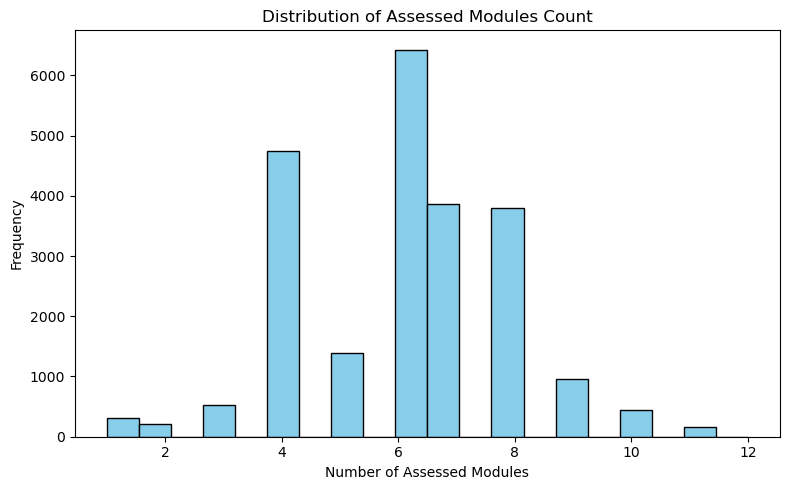

In [ ]:
# View distribution of AssessedModules.
plt.figure(figsize=(8,5))
plt.hist(X_encoded_3['AssessedModules'], bins=20, color='skyblue', edgecolor='black')
plt.title('Distribution of Assessed Modules Count')
plt.xlabel('Number of Assessed Modules')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

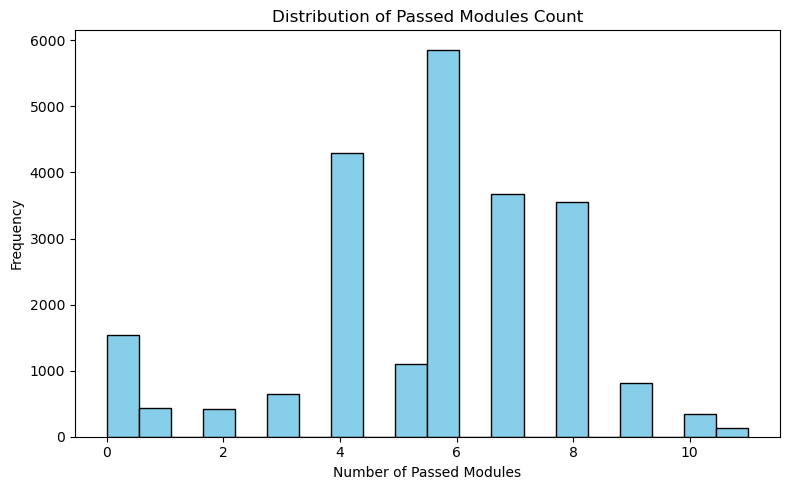

In [ ]:
# View distribution of Passed Modules.
plt.figure(figsize=(8,5))
plt.hist(X_encoded_3['PassedModules'], bins=20, color='skyblue', edgecolor='black')
plt.title('Distribution of Passed Modules Count')
plt.xlabel('Number of Passed Modules')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

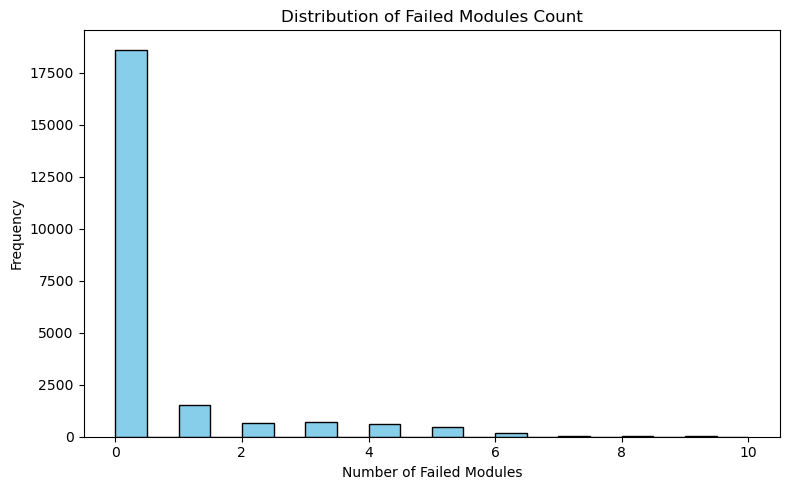

In [ ]:
# View distribution of Failed Modules.
plt.figure(figsize=(8,5))
plt.hist(X_encoded_3['FailedModules'], bins=20, color='skyblue', edgecolor='black')
plt.title('Distribution of Failed Modules Count')
plt.xlabel('Number of Failed Modules')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

The distribution of assessed and passed modules appears approximately normal, while the failed modules feature is right-skewed. Given this skewness, missing values in the failed modules feature were imputed using the median, which is more robust to outliers. For consistency, assessed and passed modules were also imputed with their respective median values. As performed previously for Stage 2, AuthorisedAbsenceCount and UnauthorisedAbsenceCount were also imputed with the median values.

In [ ]:
# Impute missing values with median value.
median_imputer = SimpleImputer(strategy='median')

X_encoded_3[missing_cols_3] = median_imputer.fit_transform(X_encoded_3[missing_cols_3])

In [ ]:
# Verify the absence of missing values.
X_encoded_2.isnull().values.any()

False

### **3.1.5 Feature engineering**

In [ ]:
# Convert 'DateofBirth' column to datetime.
stage_3['DateofBirth'] = pd.to_datetime(stage_3['DateofBirth'], dayfirst=True)

# Convert DOB to age and add feature to X_encoded.
X_encoded_3['Age'] = (pd.to_datetime('today') - stage_3['DateofBirth']).dt.days // 365

print("Number of features:", X_encoded_3.shape[1])

Number of features: 394


In [ ]:
# Rename CompletedCourse to DroppedOut and convert to binary values.
# For CompletedCourse= Yes, DroppedOut= 0, for CompletedCourse= No, DroppedOut= 1
y_3= y_3.rename('DroppedOut').map({'Yes': 0, 'No': 1}).astype(int)

print("Target values:", y_3.unique())

Target values: [0 1]


As with the stage 1 and 2 data, the target feature 'CompletedCourse' was changed to 'DroppedOut' and was mapped accordingly (For CompletedCourse= Yes, DroppedOut= 0, for CompletedCourse= No, DroppedOut= 1) to better align with the goals of the project and allow more intuative interpretation.

### **3.1.6 Split the data**

In [ ]:
# Split the data into training and test set.
X_train_3, X_test_3, y_train_3, y_test_3 = train_test_split(X_encoded_3, y_3, test_size=0.2, stratify=y_3, random_state=seed)

## **3.2 XGBoost**

### **3.2.1 XGBoost (Baseline Model 5)**

To establish a benchmark for performance on the Stage 3 dataset, a baseline XGBoost model was developed using default hyperparameters, with the exception of the scale_pos_weight parameter. This model serves a as a reference point for evaluating the predictive value of the Stage 3 features and the potential impact of hyperparameter tuning. Model performance was primarily assessed using recall to reflect the business priority but also included consideration of other metrics such as precision, F1 score and ROC AUC.

**Key features of the Baseline Model 5:**
1. **scale_pos_weight:** This parameter is implemented to address class imbalance.
2. **Default Hyperparameters**
3. **Training Data:** Stage 3 dataset

In [ ]:
# Set seed.
set_seed(42)

In [ ]:
# Instantiate baseline XBGoost model on stage 5 data with scale_pos_weight.
xgb_model_5 = XGBClassifier(scale_pos_weight=scale_pos_weight,
                            random_state=seed,
                            n_jobs=1)

# Train model on training dataset and evaluate model on test dataset.
xgb_model_5.fit(X_train_3, y_train_3)
xgb_5_evaluation, xgb_5_confusion_matrix = evaluate_model(xgb_model_5, X_test_3, y_test_3, 'XGBoost (Model 5)')

# View evaluation metrics.
xgb_5_evaluation

,Accuracy,AUC ROC,Recall,Precision,F1 Score
XGBoost (Model 5),0.962889,0.947462,0.925433,0.842424,0.88198


* **Accuracy:** Very high at 96.3 % suggesting reliable classification, although this could be misleading due to the imbalanced dataset.
* **Recall:** Very high recall (92.5%), ideal for minimising false negatives.
* **ROC AUC:** Very high suggesting near-perfect class separability.
* **Precision:** Very high (84.2%) suggesting that 84% of flagged students are actual dropout cases, indicating very few false positives are generated.
* **F1 Score:** Very high balance (0.88) confirming the model is sensitive and reliable.

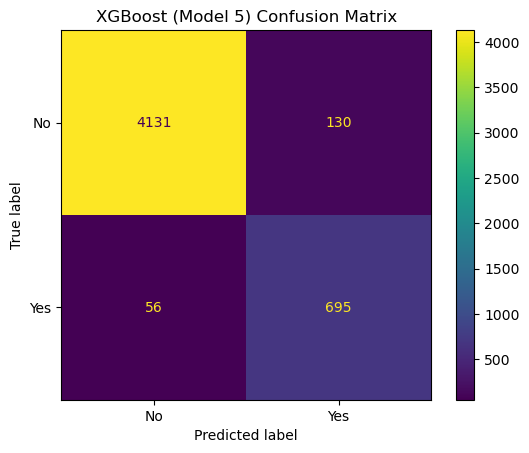

In [ ]:
# View confusion matrix.
xgb_5_cfmd = plot_confusion_matrix(xgb_5_confusion_matrix, title='XGBoost (Model 5) Confusion Matrix')

* **True Negatives** = 4131, the model correctly predicted 4131 cases of students not dropping out.
* **False Negatives** = 56, the model only missed 56 cases student drop out- this is the key factor to decrease so dropout cases are not missed.
* **False Positive** = 130, the model identified 130 cases where it predicted the student would drop out but they didn't.
* **True Positives** = 685, the model correctly predicted 614 cases of student drop out.

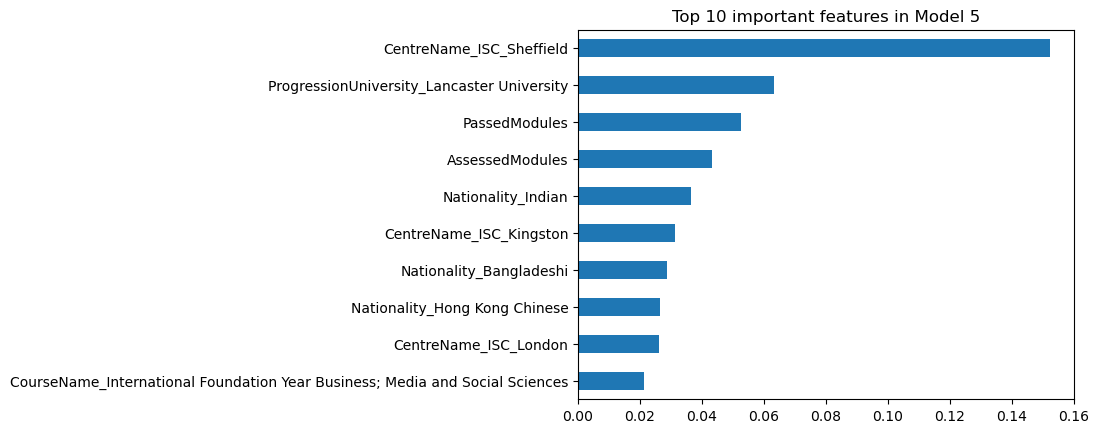

In [ ]:
# Extract feature importances for model 5.
feature_importance_5 = pd.Series(xgb_model_5.feature_importances_, index=X_train_3.columns).sort_values()

# View plot of top 10 importance features for readability.
feature_importance_5.iloc[-10:].plot.barh()
plt.title('Top 10 important features in Model 5')
plt.show()

Feature importance plot indicates the Stage 3 features 'PassedModules' and 'AssessedModules' have a strong influence over the model's predictions. The plot also shows that Sheffield in the Centre Name category is the most influential, followed by Lancaster University as the progression University.

### **3.2.2 XGBoost Stage 2 vs Stage 3 Baseline Model Comparison**

To explore the effect of additional features in the training dataset on the XGBoost models, the performance of the baseline models trained on stage 2 data and stage 3 data were compared. The baseline models (same architecture) were selected for this comparison to remove the potential effects of hyperparameter tuning leading to different model architectures.

**Models:**
* **XGBoost Model 3** = XGBoost baseline model trained on stage 2 data
* **XGBoost Model 5** = XGBoost baseline model trained on stage 3 data

In [ ]:
# View summary evaluation metrics for XGBooost models 3 (baseline) and 4 (tuned) for comparison.
xgb_model_comparison_stage_2_3 = pd.concat([xgb_3_evaluation, xgb_5_evaluation])
xgb_model_comparison_stage_2_3

,Accuracy,AUC ROC,Recall,Precision,F1 Score
XGBoost (Model 3),0.879290,0.851678,0.812250,0.567970,0.668493
XGBoost (Model 5),0.962889,0.947462,0.925433,0.842424,0.881980


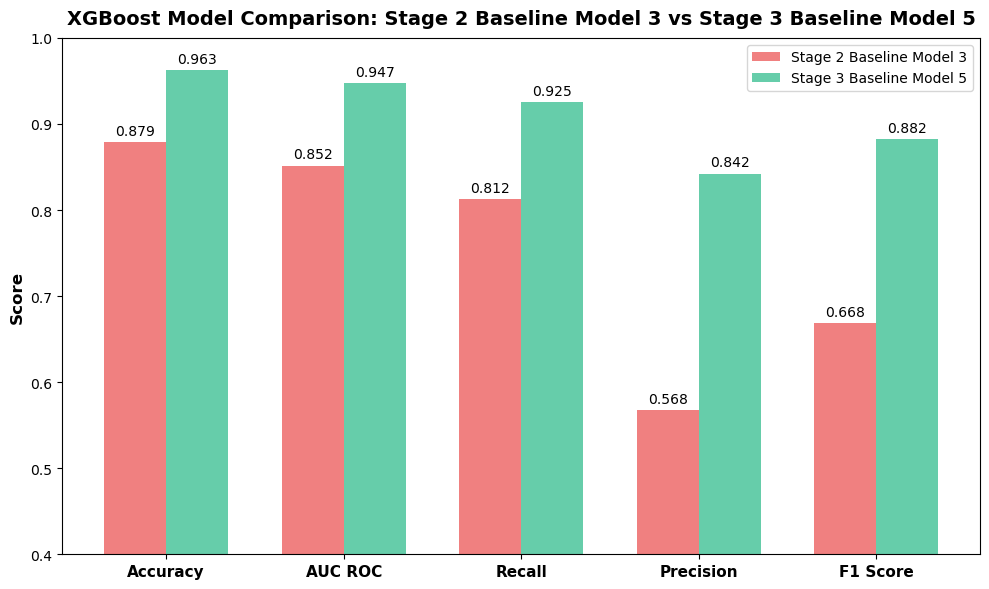

In [ ]:
# View summary evaluation metrics as a bar plot for comparison.
plot_bar_comparison(model= 'XGBoost',
                    model_1_name ='Stage 2 Baseline Model 3',
                    model_1_evaluation=xgb_3_evaluation,
                    model_2_name= 'Stage 3 Baseline Model 5',
                    model_2_evaluation=xgb_5_evaluation)

To evaluate the impact of additional features on the dropout prediction, baseline models trained on Stage 2 and Stage 3 datasets were compared. While Stage 2 included demographic and student engagement data, Stage 3 introduced key academic performance indicators- namely the number of assessed, passed and failed modules.
* The Stage 3 baseline model demonstrated the largest improvement in overall performance of the XGBoost models, when compared to the stage 2 baseline model, with significant increases in recall, F1 score, ROC AUC and especially precision (84.2% vs 56.8%). This suggests that more flagged students are actual dropout cases.

The performance improvements in Stage 3 are primarily driven by the inclusion of the academic performance indicators which provide direct information of student success or failure. Unlike engagement data, academic results such as failed module counts are stronger indicators of academic risk, making them highly predictive of dropout. These features offer quantitative evidence of academic progress meaning the models can learn strong patterns with students who are likely to withdraw. In contrast, the Stage 2 enagagement features are more indirect and may be influenced by external factors such as illness or personal circumstance which do not necessarily lead to student dropout.

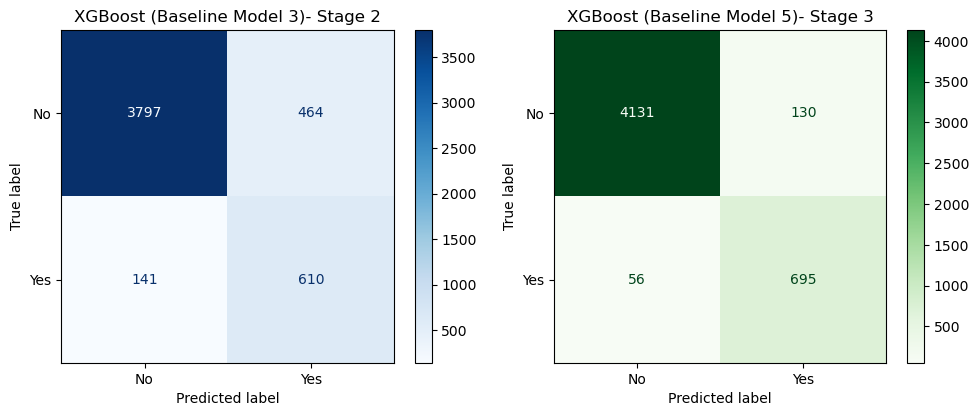

In [ ]:
# Compare confusion matrix for XGBooost models 3 (baseline- stage 2 data) and 5 (baseline- stage 3 data) for comparison.
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

ConfusionMatrixDisplay(
    confusion_matrix=xgb_3_confusion_matrix,
    display_labels=['No', 'Yes']
).plot(ax=axes[0], cmap='Blues')
axes[0].set_title('XGBoost (Baseline Model 3)- Stage 2')

ConfusionMatrixDisplay(
    confusion_matrix=xgb_5_confusion_matrix,
    display_labels=['No', 'Yes']
).plot(ax=axes[1], cmap='Greens')
axes[1].set_title('XGBoost (Baseline Model 5)- Stage 3')

plt.tight_layout()
plt.show()

Model 5 significantly outperforms Model 3 with more correct predictions (true positive and negative) and fewer incorrect predictions (false negative and positive).

### **3.2.3 XGBoost (Tuned Model 6)- Best Recall**

Building on the Stage 3 baseline model, a tuned XGBoost model was developed to explore whether optimising hyperparameters could further improve dropout prediction performance. The hyperparameters tuned included learning_rate, max_depth and n_estimators and once the best performing configuration was identified, the model was evaluated on an unseen test set to assess generalisation performance.

**Key features of the Tuned Model 6:**
1. **scale_pos_weight:** This parameter is implemented to address class imbalance.
2. **Tuned Hyperparameters:** Optimised for recall score.
3. **Training Data:** Stage 3 dataset

In [ ]:
# Set seed.
set_seed(42)

In [ ]:
# Instantiate XBGoost model 6 with scale_pos_weight.
xgb_model_6 = XGBClassifier(scale_pos_weight=scale_pos_weight,
                            random_state=seed,
                            n_jobs=1)

In [ ]:
# Tune XGBoost hyperparameters on stage 3 dataset: learning rate, max depth and number of estimators.
# Define parameter grid of parameters and respective values to test.
param_grid = {'learning_rate': [0.01, 0.05, 0.1],
              'max_depth': [3, 5, 7],
              'n_estimators': [200, 500, 700]}

# Run grid search with recall set as scoring metric.
grid_3 = GridSearchCV(estimator=xgb_model_6,
                      param_grid=param_grid,
                      scoring='recall',
                      cv=cv,
                      n_jobs=-1)

# Fit to training data.
grid_3.fit(X_train_3, y_train_3)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, feature_weights=None,
                                     gamma=None, grow_polic...
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=1, num_parallel_tree=None, ...),
             n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.05, 0.1],
                         'max_depth': [3, 5, 7],
                         'n_estimators': [200, 500, 700]},
             scoring='recall')

In [ ]:
# View the best results.
print("Best Parameters:", grid_3.best_params_)
print("Best Recall Score", grid_3.best_score_)
xgb_model_6 = grid_3.best_estimator_

Best Parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200}
Best Recall Score 0.9470438158624515


* A grid search of learning rate, max depth and n_estimators, with recall set as the scoring method, identified that the best combination of hyperparameter values is 0.1, 3 and 200 respectively.
* Implementing these optimised hyperparameters increased recall to 94.7% (evaluated on the validation dataset).

In [ ]:
# Evaluate the best model on the test data.
xgb_6_evaluation, xgb_6_confusion_matrix = evaluate_model(xgb_model_6, X_test_3, y_test_3, 'XGBoost (Model 6)')
xgb_6_evaluation

,Accuracy,AUC ROC,Recall,Precision,F1 Score
XGBoost (Model 6),0.940942,0.943329,0.946738,0.735264,0.827707


* **Accuracy:** Very high- indicating 94.1% of predictions are correct, however this metric can be misleading for an imbalanced dataset.
* **Recall:** Very high at 94.7 % alligning well with business goal of minimising false negatives.
* **Precision:** Reasonable at 73.5% considering the value of Recall.
* **F1 Score:** High at 0.83 confirming a well balanced trade off between recall and precision.
* **AUC ROC:** Very strong indicating good separation between dropouts and non-dropout classes across thresholds.

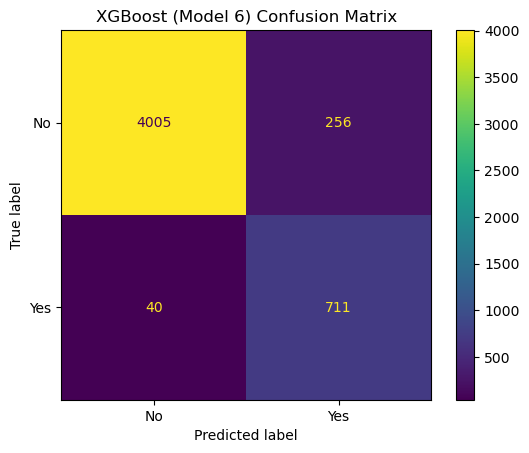

In [ ]:
# View confusion matrix.
xgb_6_cfmd = plot_confusion_matrix(xgb_6_confusion_matrix, title='XGBoost (Model 6) Confusion Matrix')

* **True Negatives** = 4005, the model correctly predicted 4005 cases of students not dropping out.
* **False Negatives** = 40, the model only missed 40 cases student drop out- this is the key factor to decrease so dropout cases are not missed.
* **False Positive** = 256, the model identified 130 cases where it predicted the student would drop out but they didn't.
* **True Positives** = 711, the model correctly predicted 614 cases of student drop out.

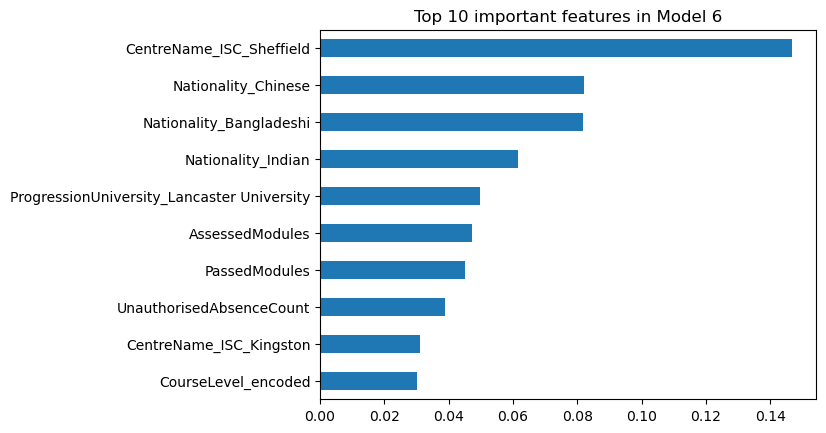

In [ ]:
# Extract feature importances for model 6.
feature_importance_6 = pd.Series(xgb_model_6.feature_importances_, index=X_train_3.columns).sort_values()

# View plot of top 10 importance features for readability.
feature_importance_6.iloc[-10:].plot.barh()
plt.title('Top 10 important features in Model 6')
plt.show()

The most important features in Model 6 include Sheffield in the Centre Name category, Chinese, Bangladeshi and Indian in the nationality category and three features introduced in the Stage 2 and 3 dataset: 'AssessedModules', 'PassedModules' and 'UnauthorisedAbsenceCount'. These features have the greater influence on the models predictions.

### **3.2.4 XGBoost Baseline vs Tuned Model Comparison (Stage 3)**

To evaluate the effectiveness of hyperparameter tuning, the performance of the tuned XGboost (Model 6) was compared against the baseline model (Model 5) trained on the Stage 3 dataset. The key objective of this comparison is to assess whether optimising model parameters lead to a improvement in model performance when predicting student dropout.

**Models:**
* **XGBoost Model 5** = XGBoost baseline model trained on stage 3 data
* **XGBoost Model 6** = XGBoost tuned model (optimised Recall) trained on stage 3 data

In [ ]:
# View summary evaluation metrics for XGBooost models 5 (baseline) and 6 (tuned) for comparison.
xgb_comparison_stage_3 = pd.concat([xgb_5_evaluation, xgb_6_evaluation])
xgb_comparison_stage_3

,Accuracy,AUC ROC,Recall,Precision,F1 Score
XGBoost (Model 5),0.962889,0.947462,0.925433,0.842424,0.881980
XGBoost (Model 6),0.940942,0.943329,0.946738,0.735264,0.827707


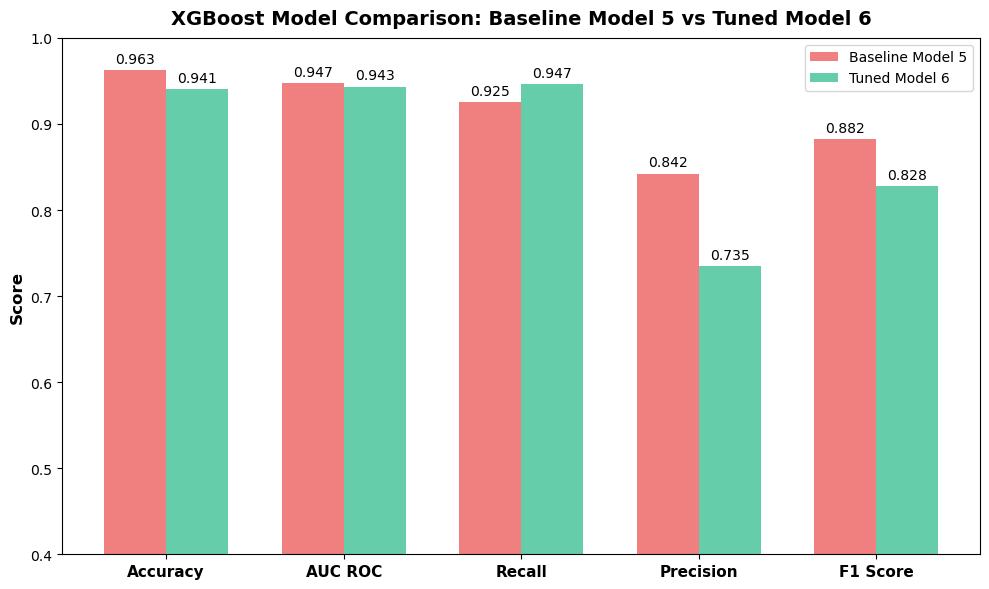

In [ ]:
# View summary evaluation metrics as a bar plot for comparison.
plot_bar_comparison(model= 'XGBoost',
                    model_1_name ='Baseline Model 5',
                    model_1_evaluation=xgb_5_evaluation,
                    model_2_name='Tuned Model 6',
                    model_2_evaluation=xgb_6_evaluation)

* Hyperparameter tuning boosted Recall (improved from 92.5% to 94.7%) however, this came at a cost to precision, which dropped significantly (94.% to 73.5%) and F1 Score. This suggests the tuned model flags more at risk-students but more of those are false positives.
* AUC ROC was also slightly lower in the tuned model suggesting reduced overall separability between classes.

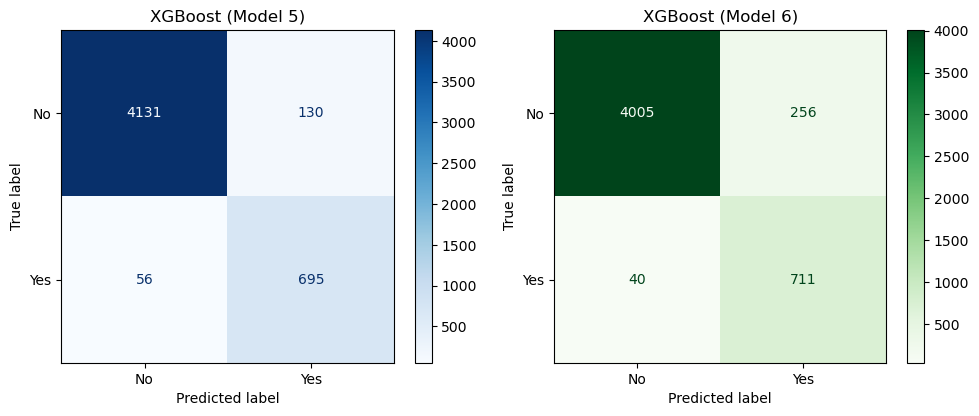

In [ ]:
# Compare confusion matrix for XGBooost models 5 (baseline) and 6 (tuned) for comparison.
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

ConfusionMatrixDisplay(
    confusion_matrix=xgb_5_confusion_matrix,
    display_labels=['No', 'Yes']
).plot(ax=axes[0], cmap='Blues')
axes[0].set_title('XGBoost (Model 5)')

ConfusionMatrixDisplay(
    confusion_matrix=xgb_6_confusion_matrix,
    display_labels=['No', 'Yes']
).plot(ax=axes[1], cmap='Greens')
axes[1].set_title('XGBoost (Model 6)')

plt.tight_layout()
plt.show()

 * Model 6 has fewer false negatives (40 vs 56) but has greater false positives (256 vs 130), indicating an uneven trade-off where the small increase in recall has resulted in a large decrease in precision.

## **3.3 Neural Networks**

### **3.3.1 Preprocessing**

In [ ]:
# Split training dataset into training and validation.
X_train_3, X_valid_3, y_train_3, y_valid_3 = train_test_split(X_train_3, y_train_3, test_size=0.2, stratify=y_train_3, random_state=seed)

In [ ]:
# Standardise the data.
std = StandardScaler()

X_train_3 = std.fit_transform(X_train_3)
X_valid_3 = std.transform(X_valid_3)
X_test_3 = std.transform(X_test_3)

### **3.3.2 Neural Network (Baseline Model 5)**

A baseline neural network model was developed using the Stage 3 dataset which included an expanded set of input features. This increase in dimensionality was accounted for by passing the X_train_3 dataset into the neural network creation function which can dynamically calculate the input shape based on feature dimensions. The model was trained using default parameters with the exception of class weighting to address the imbalance of the target variable, l2 regularisation and early stopping to reduce the risk of overfitting. Evaluation focused primarily on recall, but other key metrics such as F1 score, ROC AUC and precision were also considered.

**Key features of the baseline model:**
1. **Class weighting:** Included to address class imbalance by assigning higher importance to the minority class (in this case Class 1, student dropouts).
2. **L2 regularisation:** Included to penalise large weights to reduce overfitting and improve generalisation.
3. **Early Stopping:** Set to monitor the performance of the validation dataset and to halt training when no further improvement occurs to prevent overfitting and save computational resources.
4. **Training Data:** Stage 3 data

In [ ]:
# Set seed.
set_seed(42)

In [ ]:
# Create baseline neural network (Model 5).
nn_model_5, history_5 = create_nn_model(X_train_3, y_train_3,
                                        X_valid_3, y_valid_3,
                                        optimizer= 'adam',
                                        activation = 'relu',
                                        neuron_layer_1=16,
                                        neuron_layer_2=16,
                                        batch_size=128,
                                        regularizer=l2_regularizer,
                                        callback=early_stopping,
                                        class_weight=class_weights)

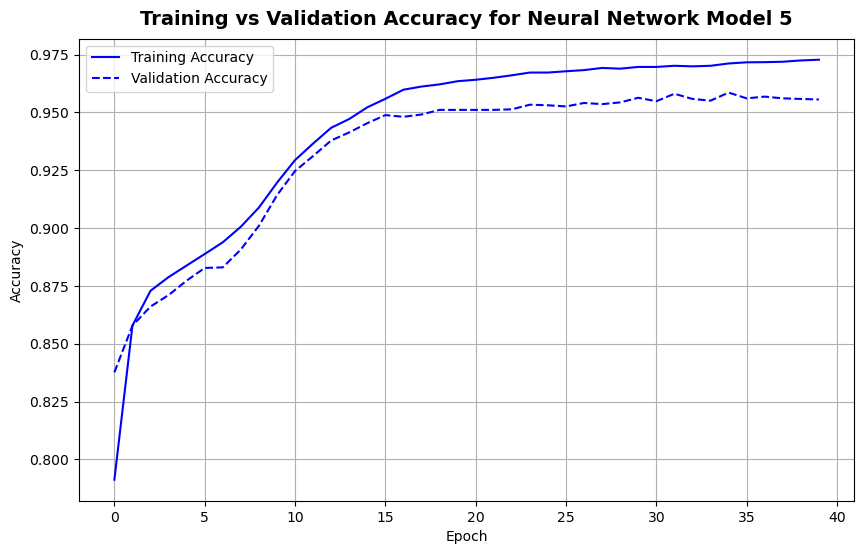

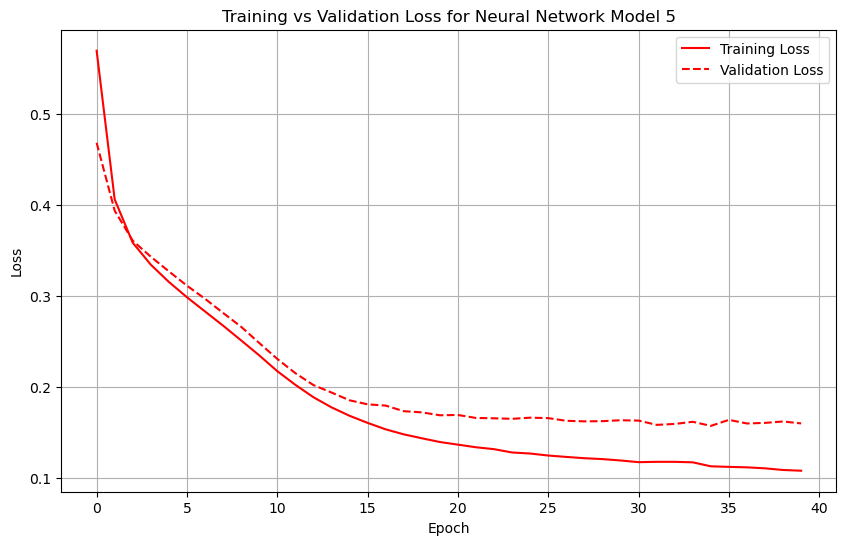

In [ ]:
# Plot loss and accuracy curves for Model 5.
plot_curve(history_5, model_name= 'Model 5')

Throughout training, both training and validation accuracy and loss closely track each other, indicating good generalisation. However, towards the end of training, a slight divergence appears as validation performance begins to plateau, while training accuracy continues to improve and training loss continues to decrease. This potentially indicates the start of overfitting.

In [ ]:
# Evaluate the performance of Model 5 on the test data.
nn_5_evaluation, nn_5_confusion_matrix = evaluate_nn_model(nn_model_5, X_test_3, y_test_3, model_name='Neural Network (Model 5)')

# View evaluation metrics.
nn_5_evaluation

,Accuracy,AUC ROC,Recall,Precision,F1 Score
Neural Network (Model 5),0.95431,0.928157,0.890812,0.819853,0.853861


* **Accuracy:** Very high at 95.4 % suggesting reliable classification, although this could be misleading due to the imbalanced dataset.
* **Recall:** Very high recall (89.1%), ideal for minimising false negatives.
* **ROC AUC:** Very high suggesting near-perfect class separability (0.93).
* **Precision:** Very high (82.0%) suggesting that 82% of flagged students are actual dropout cases, indicating very few false positives are generated.
* **F1 Score:** Very high balance (0.85) confirming the model is sensitive and reliable.

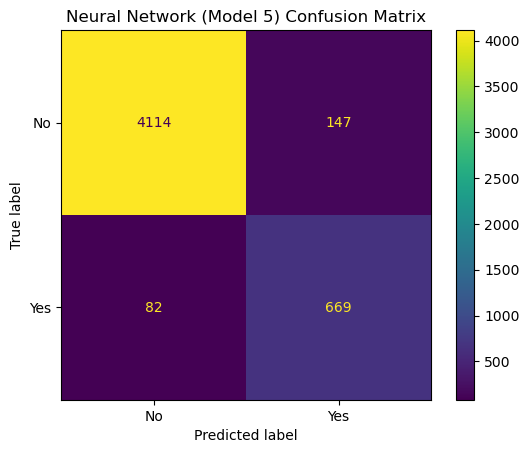

In [ ]:
# View Model 5 confusion matrix.
nn_5_cfmd = plot_confusion_matrix(nn_5_confusion_matrix, title='Neural Network (Model 5) Confusion Matrix')

* **True Negatives** = 4114, the model correctly predicted 4114 cases of students not dropping out.
* **False Negatives** = 82, the model only missed 82 cases student drop out- this is the key factor to decrease so dropout cases are not missed.
* **False Positive** = 147, the model identified 147 cases where it predicted the student would drop out but they didn't.
* **True Positives** = 669, the model correctly predicted 614 cases of student drop out.

### **3.3.3 Neural Network Stage 2 vs Stage 3 Baseline Model Comparison**

**Models:**
* Neural Network Model 3 = Neural Network baseline model trained on stage 3 data
* Neural Network Model 5 = Neural Network baseline model trained on stage 5 data

In [ ]:
# View summary evaluation metrics for models 3 and 4 for comparison.
nn_comparison_stage_2_3 = pd.concat([nn_3_evaluation, nn_5_evaluation])
nn_comparison_stage_2_3

,Accuracy,AUC ROC,Recall,Precision,F1 Score
Neural Network (Model 3),0.86233,0.843897,0.817577,0.526135,0.640250
Neural Network (Model 5),0.95431,0.928157,0.890812,0.819853,0.853861


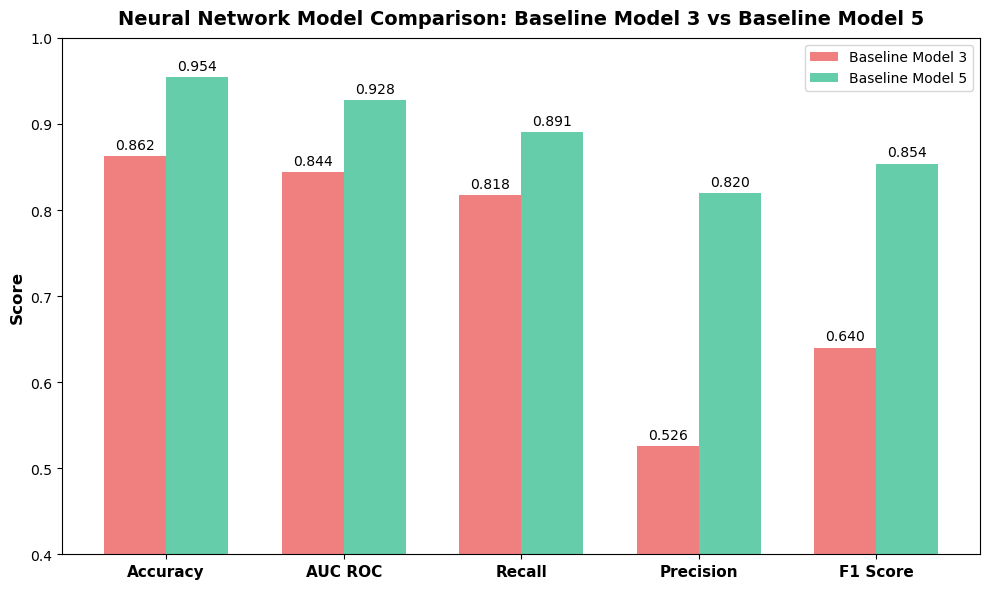

In [ ]:
# View summary evaluation metrics as a bar plot for comparison.
plot_bar_comparison(model= 'Neural Network',
                    model_1_name='Baseline Model 3',
                    model_1_evaluation=nn_3_evaluation,
                    model_2_name='Baseline Model 5',
                    model_2_evaluation=nn_5_evaluation)

To evaluate the impact of additional features on the dropout prediction, baseline models trained on Stage 2 and Stage 3 datasets were compared. While Stage 2 included demographic and student engagement data, Stage 3 introduced key academic performance indicators- namely the number of assessed, passed and failed modules.
* The Stage 3 baseline model demonstrated the largest improvement in overall performance compared to the stage 2 baseline model, with notable increases across all metrics, especially precision (52.6% to 82.0%) and excellent recall (89.1%)

As discussed when evaluating the stage 2 vs stage 3 baseline XGBoost models, the performance the performance improvements in Stage 3 are primarily driven by the inclusion of the academic performance indicators which provide the strong signals of student success or failure, hence provided the greater predictive power for student dropout. While stage 2 engagement data is useful, it is a much weaker signal of student dropout as it can be influenced by external factors not related to dropping out.

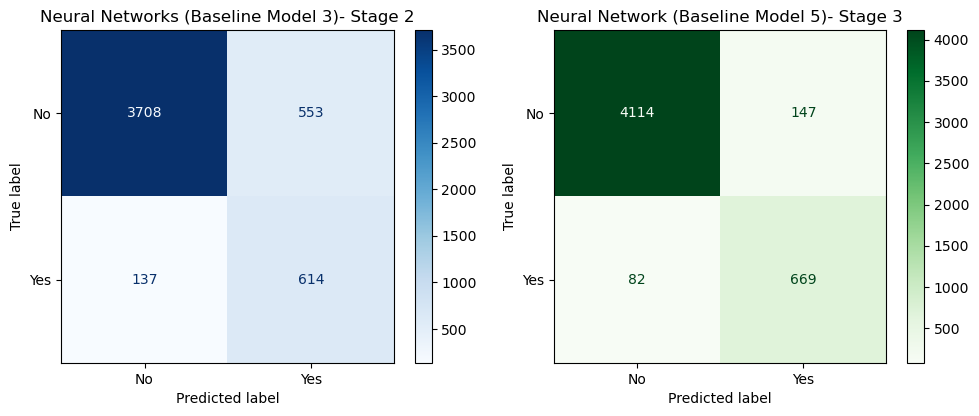

In [ ]:
# Compare confusion matrix for Neural Network models 3 (baseline- stage 2 data) and 5 (baseline- stage 3 data) for comparison.
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

ConfusionMatrixDisplay(
    confusion_matrix=nn_3_confusion_matrix,
    display_labels=['No', 'Yes']
).plot(ax=axes[0], cmap='Blues')
axes[0].set_title('Neural Networks (Baseline Model 3)- Stage 2')

ConfusionMatrixDisplay(
    confusion_matrix=nn_5_confusion_matrix,
    display_labels=['No', 'Yes']
).plot(ax=axes[1], cmap='Greens')
axes[1].set_title('Neural Network (Baseline Model 5)- Stage 3')

plt.tight_layout()
plt.show()

Model 5 outperformed Model 3 with a greater number of correct predictions (true positive and negative) and fewer incorrect predictions (false negative and positive)

### **3.3.4 Hyperparameter Tuning**

To improve the performance of the baseline model trained on stage 3 data, hyperperameter tuning was carried out on the choice of optimizer, activation functions, number of neurons in hidden layer 1 and 2, and the batch size.

In [ ]:
# Set seed.
set_seed(42)

In [ ]:
# Define hyperparameter ranges to test.
optimizers = ['adam', 'rmsprop']
activations = ['relu', 'tanh']
neuron_1 = [128, 64, 32]
neuron_2 = [64, 32, 16]
batch_sizes = [32, 64, 128]

results_3 = []

# Create a for loop for each hyperparameter vector.
for o in optimizers:
    for act in activations:
        for n1 in neuron_1:
            for n2 in neuron_2:
                for bs in batch_sizes:
                    tuned_model, tuned_history = create_nn_model(X_train_3, y_train_3,
                                                                 X_valid_3, y_valid_3,
                                                                 optimizer=o,
                                                                 activation=act,
                                                                 neuron_layer_1=n1,
                                                                 neuron_layer_2=n2,
                                                                 batch_size = bs,
                                                                 regularizer=l2_regularizer,
                                                                 callback=early_stopping,
                                                                 class_weight=class_weights)

                    # Evaluate the models on the validation data.
                    accuracy, recall, f1, auc, prec = hyperparameter_evaluation(tuned_model, X_valid_3, y_valid_3)

                    # Add evaluation metrics of each model to results_2
                    results_3.append({'Optimizer': o,
                                      'Activation': act,
                                      'Layer 1 Neurons': n1,
                                      'Layer 2 Neurons': n2,
                                      'Batch size': bs,
                                      'Recall': recall,
                                      'Accuracy': accuracy,
                                      'F1 Score': f1,
                                      'ROC AUC': auc,
                                      'Precision': prec})

126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 339us/step
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 330us/step
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 330us/step
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 319us/step
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 319us/step
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 332us/step
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 312us/step
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 327us/step
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 341us/step
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 312us/step
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 306us/step
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 313us/step
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 313us/step
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 305us/step
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 313us/step
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 305us/step
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 304us/step
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 317us/step
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 295us/step
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 291us/step
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 305us/step
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 495us/step
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 288us/step
126/126 ━━━

In [ ]:
# Convert results to a dataframe.
results_3_df = pd.DataFrame(results_3)

# Find the parameter combinations corresponding to the highest value of each metric.
best_accuracy_3 = results_3_df.loc[results_3_df['Accuracy'].idxmax()]
best_recall_3 = results_3_df.loc[results_3_df['Recall'].idxmax()]
best_f1_3 = results_3_df.loc[results_3_df['F1 Score'].idxmax()]
best_auc_3 = results_3_df.loc[results_3_df['ROC AUC'].idxmax()]
best_prec_3 = results_3_df.loc[results_3_df['Precision'].idxmax()]

# Create a summary table with the best parameters and metric values.
results_summary_3 = pd.DataFrame([best_accuracy_3, best_recall_3, best_f1_3, best_auc_3, best_prec_3],
                                 index=['Best Accuracy', 'Best Recall', 'Best F1 Score', 'Best ROC AUC', 'Best Precision'])

# View results
results_summary_3

,Optimizer,Activation,Layer 1 Neurons,Layer 2 Neurons,Batch size,Recall,Accuracy,F1 Score,ROC AUC,Precision
Best Accuracy,adam,relu,128,64,128,0.906822,0.961845,0.876911,0.939184,0.848910
Best Recall,rmsprop,relu,64,64,64,0.938436,0.955362,0.863045,0.948391,0.798867
Best F1 Score,rmsprop,relu,128,32,128,0.931780,0.960848,0.877056,0.948876,0.828402
Best ROC AUC,rmsprop,relu,128,32,128,0.931780,0.960848,0.877056,0.948876,0.828402
Best Precision,adam,relu,128,64,128,0.906822,0.961845,0.876911,0.939184,0.848910


* Highest recall gives a solid recall score (93.8%) meaning the model rarely misses a positive case, while still maintaining good performance over the other evaluation metrics.

### **3.3.5 Neural Network (Tuned Model 6)- Best Recall**

The best combination of parameters identified during hyperparameter tuning were then implemented in a second neural network model, which was then evaluated on an unseen test dataset to provide an unbiased assessment of its generalisation performance.

**Key features of the Model 6:**
1. **Baseline model features:** Class weighting, L2 regularisation and early stopping.
2. **Tuned parameters:** Includes the tuned hyperparameters that have the best recall score, whilst still maintaining good value of other metrics
3. **Trained on stage 3 data**

In [ ]:
# Extract the best results of the grid search based on highest recall.
best_recall_optimizer_3 = best_recall_3['Optimizer']
best_recall_activation_3 = best_recall_3['Activation']
best_recall_l1_neurons_3 = best_recall_3['Layer 1 Neurons']
best_recall_l2_neurons_3 = best_recall_3['Layer 2 Neurons']
best_recall_bs_3 = best_recall_3['Batch size']

In [ ]:
# Set seed.
set_seed(42)

In [ ]:
 # Create and train model on parameters that gave highest recall.
nn_model_6, history_6 = create_nn_model(X_train_3, y_train_3,
                                        X_valid_3, y_valid_3,
                                        optimizer=best_recall_optimizer_3,
                                        activation=best_recall_activation_3,
                                        neuron_layer_1=best_recall_l1_neurons_3,
                                        neuron_layer_2=best_recall_l2_neurons_3,
                                        batch_size=best_recall_bs_3,
                                        regularizer=l2_regularizer,
                                        callback=early_stopping,
                                        class_weight= class_weights)

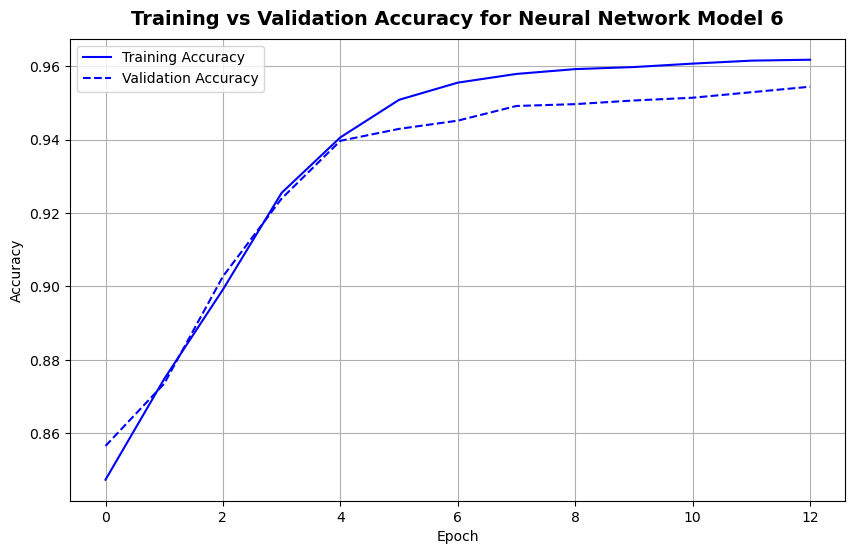

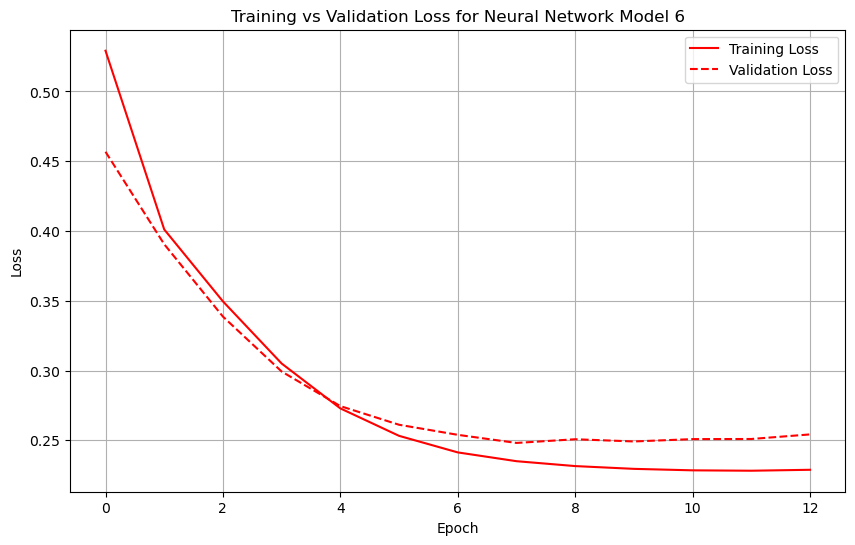

In [ ]:
# Plot loss and accuracy curves for tuned model.
plot_curve(history_6, model_name= 'Model 6')

As seen with the baseline model trained on stage 3 data, both training and validation accuracy and loss closely track each other, indicating good generalisation. However, towards the end of training, a slight divergence appears as validation performance begins to plateau, while training accuracy continues to improve and training loss continues to decrease. This potentially indicates the start of overfitting.

In [ ]:
# Evaluate the tuned model on the test data.
nn_6_evaluation, nn_6_confusion_matrix = evaluate_nn_model(nn_model_6, X_test_3, y_test_3, model_name='Neural Network (Model 6)')
nn_6_evaluation

,Accuracy,AUC ROC,Recall,Precision,F1 Score
Neural Network (Model 6),0.947925,0.937564,0.92277,0.773438,0.84153


* **Accuracy:** Very high at 95.8 % suggesting reliable classification, although this could be misleading due to the imbalanced dataset.
* **Recall:** Very high recall (92.3%), ideal for minimising false negatives.
* **ROC AUC:** Very high suggesting near-perfect class separability (0.94).
* **Precision:** Reasonably high (77.3%) suggesting that 77% of flagged students are actual dropout cases, indicating very few false positives are generated.
* **F1 Score:** Very high balance (0.84) confirming the model is sensitive and reliable.

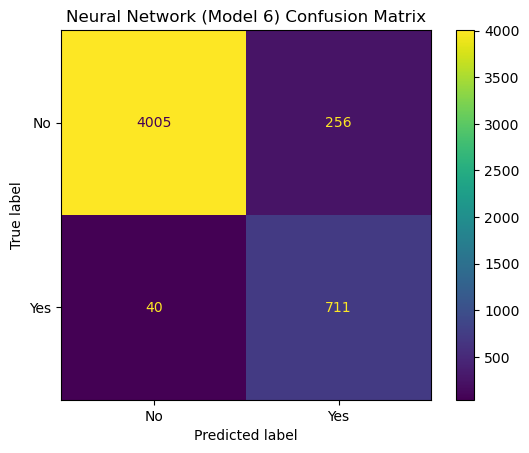

In [ ]:
# Plot confusion matrix.
xgb_6_cmfd = plot_confusion_matrix(xgb_6_confusion_matrix, title='Neural Network (Model 6) Confusion Matrix')

* **True Negatives** = 4005, the model correctly predicted 4005 cases of students not dropping out.
* **False Negatives** = 40, the model only missed 40 cases student drop out- this is the key factor to decrease so dropout cases are not missed.
* **False Positive** = 256, the model identified 256 cases where it predicted the student would drop out but they didn't.
* **True Positives** = 711, the model correctly predicted 711 cases of student drop out.

### **3.3.6 Neural Network Baseline vs Tuned Model Comparison (Stage 3)**

To evaluate the impact of hyperparameter tuning on model performance, the tuned neural network model (Model 6) was compared to its corresponding baseline version (Model 5) to determine if tuning led to meaningful improvements in model performance using the Stage 1 datasets.

**Models:**
* Neural Network Model 5 = Neural Network baseline model trained on stage 3 data
* Neural Network Model 6 = Neural Network tuned model (Recall optimised) trained on stage 3 data

In [ ]:
# View summary evaluation metrics for models 3 and 4 for comparison.
nn_comparison_stage_3 = pd.concat([nn_5_evaluation, nn_6_evaluation])
nn_comparison_stage_3

,Accuracy,AUC ROC,Recall,Precision,F1 Score
Neural Network (Model 5),0.954310,0.928157,0.890812,0.819853,0.853861
Neural Network (Model 6),0.947925,0.937564,0.922770,0.773438,0.841530


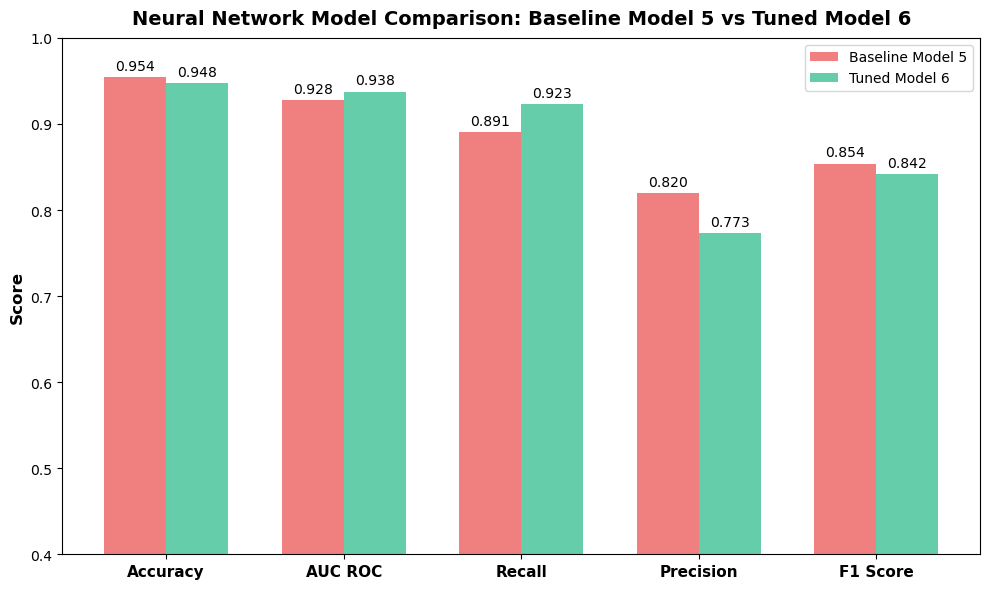

In [ ]:
# View summary evaluation metrics as a bar plot for comparison.
plot_bar_comparison(model= 'Neural Network',
                    model_1_name='Baseline Model 5',
                    model_1_evaluation=nn_5_evaluation,
                    model_2_name='Tuned Model 6',
                    model_2_evaluation=nn_6_evaluation)

* Model 6 achieved a higher recall (92.3% vs 89.1%) and a slight increase in AUC ROC (0.94 vs 0.93) indicating improved sensitivity and slightly better class separability.
* However, these gains came at a cost of reduced precision 77.3% vs 82.0% and a drop in F1 score (0.84 vs 0.85), as well as a small decrease in overall accuracy.
* While Model 6 maximises recall, Model 5 offers a more balanced approach with higher precision and reliability, whilst still having good recall.

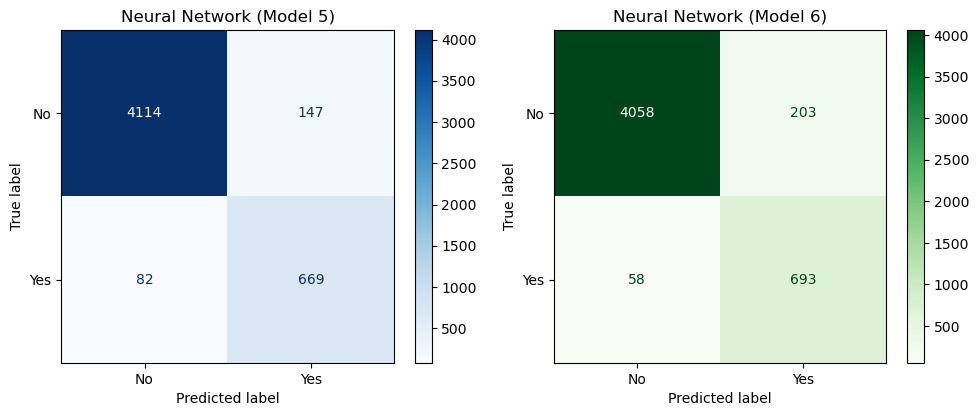

In [ ]:
# Compare confusion matrix for Neural Network models 5 (baseline) and 6 (tuned) for comparison.
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

ConfusionMatrixDisplay(
    confusion_matrix=nn_5_confusion_matrix,
    display_labels=['No', 'Yes']
).plot(ax=axes[0], cmap='Blues')
axes[0].set_title('Neural Network (Model 5)')

ConfusionMatrixDisplay(
    confusion_matrix=nn_6_confusion_matrix,
    display_labels=['No', 'Yes']
).plot(ax=axes[1], cmap='Greens')
axes[1].set_title('Neural Network (Model 6)')

plt.tight_layout()
plt.show()

* Model 6 gave fewer false negatives (58 vs 82) which was the key metric to reduce, however, the trade-off was more false positives (203 vs 147) than Model 5.

## **3.4 Stage 3 Conclusions**

The Stage 3 dataset, with additional academic performance features, enabled the highest level of predictive performance, resulting in a significant increase to model performance for both the XGBoost and Neural Network models.

Hyperparameter tuning only led to modest improvements in recall for the XGBoost and Neural network models and these small gains came at the cost of reduced precision and overall balance, reflected by lower F1 Scores. While tuning did help to optimise recall, its impact was less significant than the gains achieved through feature enhancement in Stage 3.

Overall Stage 3 provided the more accurate and reliable drop out predictions, confirming that the inclusion of strong predictor data features significantly enhance the model's ability to identify at-risk students, giving greater model performances than can be achieved by hyperparameter tuning with weaker predictive features.

# **4. Summary**

## **4.1 Baseline vs Tuned Models Compared across Stages Visualisations**

In [ ]:
# Create summary dataset of XGBoost and Neural Network evaluation metrics.
xgb_baseline_evaluations = [xgb_1_evaluation, xgb_3_evaluation, xgb_5_evaluation]
xgb_tuned_evaluations = [xgb_2_evaluation, xgb_4_evaluation, xgb_6_evaluation]
nn_baseline_evaluations = [nn_1_evaluation, nn_3_evaluation, nn_5_evaluation]
nn_tuned_evaluations = [nn_2_evaluation, nn_4_evaluation, nn_6_evaluation]

metrics = ['Recall', 'Precision', 'F1 Score', 'AUC ROC']
stages = ['Stage 1', 'Stage 2', 'Stage 3']

data = {'Stages': stages}

model_sets = {
    'XGB Baseline': xgb_baseline_evaluations,
    'XGB Tuned': xgb_tuned_evaluations,
    'NN Baseline': nn_baseline_evaluations,
    'NN Tuned': nn_tuned_evaluations
}

for model_label, eval_list in model_sets.items():
    for metric in metrics:
        col_name = f"{model_label} {metric}"
        data[col_name] = [eval[metric].item() for eval in eval_list]

xgb_nn_metrics_df = pd.DataFrame(data)
xgb_nn_metrics_df

,Stages,XGB Baseline Recall,XGB Baseline Precision,XGB Baseline F1 Score,XGB Baseline AUC ROC,XGB Tuned Recall,XGB Tuned Precision,XGB Tuned F1 Score,XGB Tuned AUC ROC,NN Baseline Recall,NN Baseline Precision,NN Baseline F1 Score,NN Baseline AUC ROC,NN Tuned Recall,NN Tuned Precision,NN Tuned F1 Score,NN Tuned AUC ROC
0,Stage 1,0.766977,0.515667,0.616702,0.820006,0.776298,0.469027,0.584754,0.810703,0.781625,0.481938,0.596242,0.816769,0.782956,0.481967,0.596651,0.817317
1,Stage 2,0.812250,0.567970,0.668493,0.851678,0.817577,0.520339,0.635940,0.842372,0.817577,0.526135,0.640250,0.843897,0.818908,0.499188,0.620272,0.837053
2,Stage 3,0.925433,0.842424,0.881980,0.947462,0.946738,0.735264,0.827707,0.943329,0.890812,0.819853,0.853861,0.928157,0.922770,0.773438,0.841530,0.937564


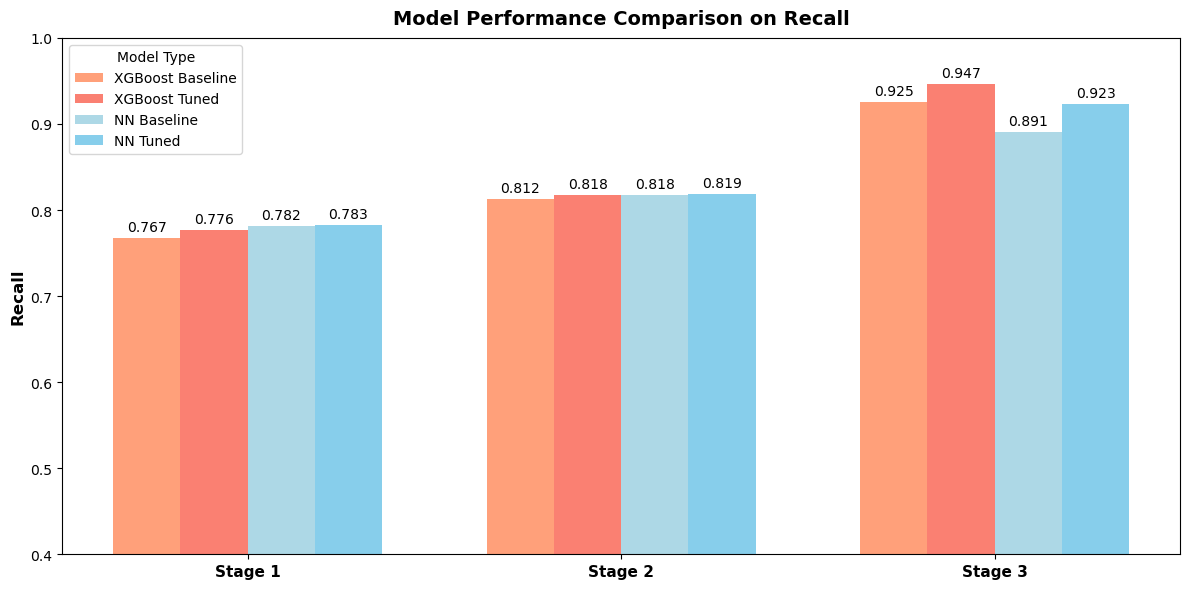

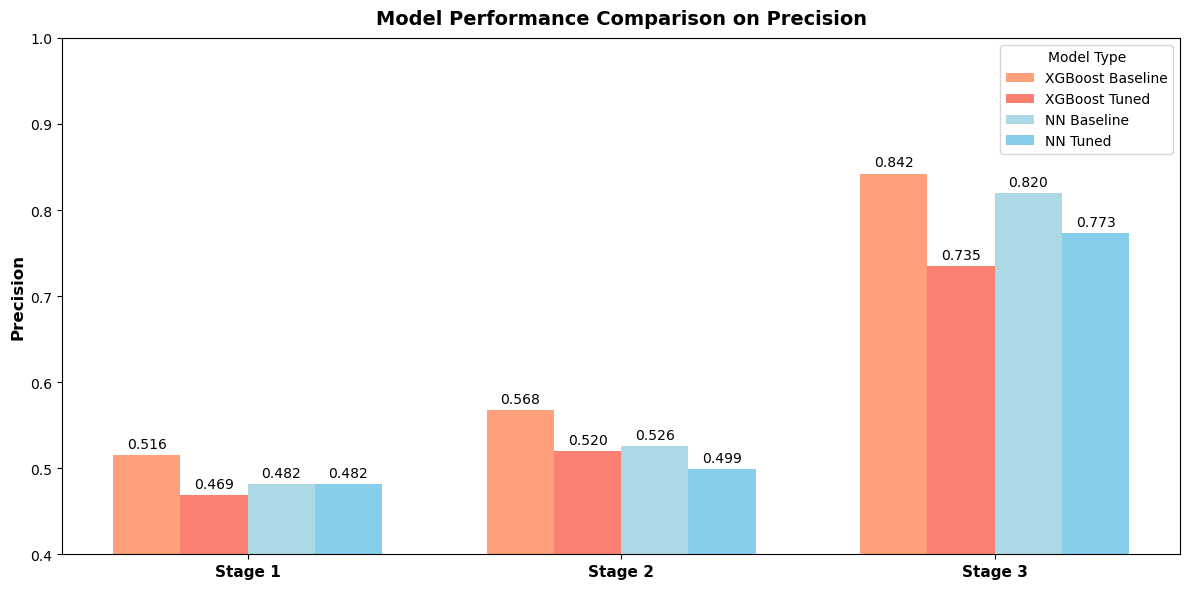

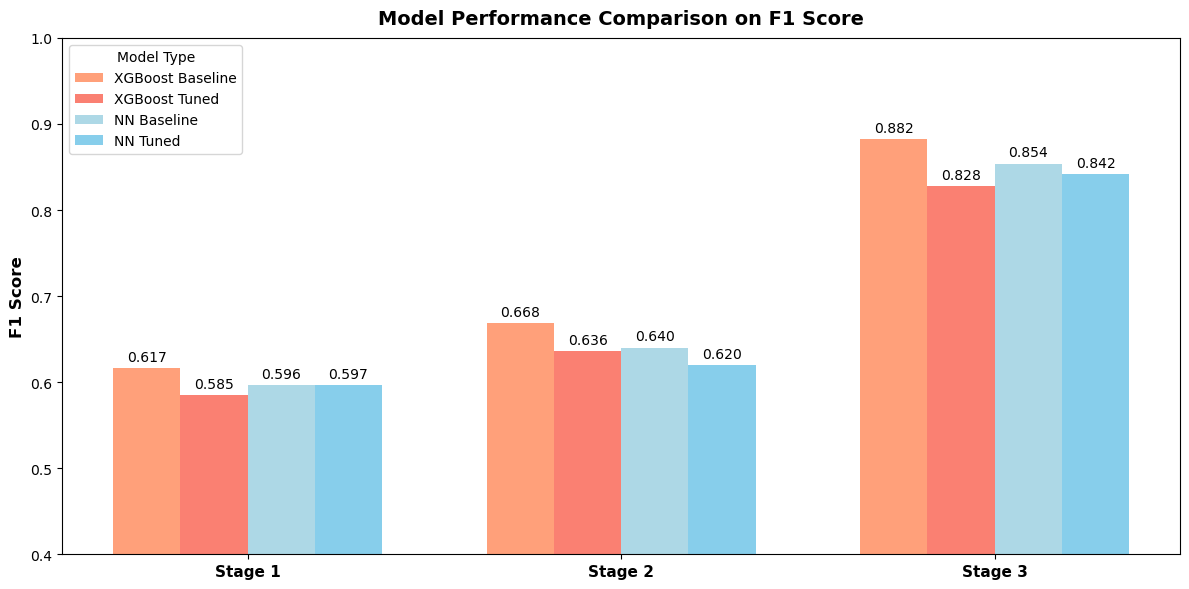

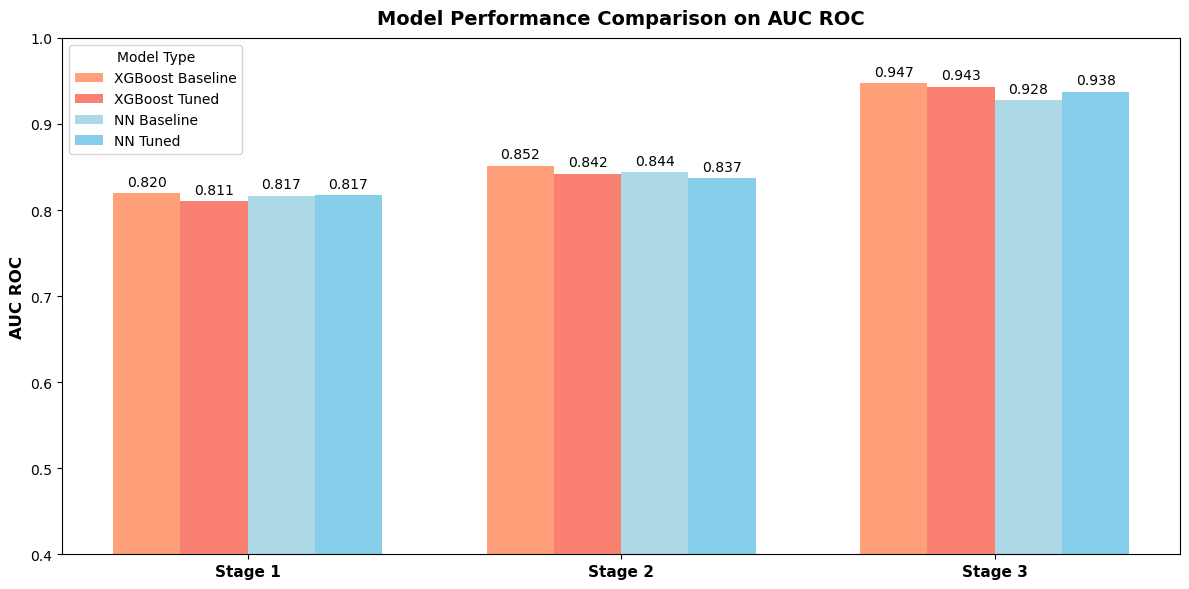

In [ ]:
# Define x axis.
x = np.arange(len(stages))
width = 0.18

# Plot grouped bar charts for each metric.
figures = []

for metric in metrics:
    fig, ax = plt.subplots(figsize=(12, 6))

    bar1 = ax.bar(x - 1.5 * width, xgb_nn_metrics_df[f'XGB Baseline {metric}'], width, label= 'XGBoost Baseline', color='lightsalmon')
    bar2 = ax.bar(x - 0.5 * width, xgb_nn_metrics_df[f'XGB Tuned {metric}'], width, label= 'XGBoost Tuned', color='salmon')
    bar3 = ax.bar(x + 0.5 * width, xgb_nn_metrics_df[f'NN Baseline {metric}'], width, label= 'NN Baseline', color='lightblue')
    bar4 = ax.bar(x + 1.5 * width, xgb_nn_metrics_df[f'NN Tuned {metric}'], width, label= 'NN Tuned', color='skyblue')

    ax.set_ylabel(metric, fontsize=12, fontweight='bold')
    ax.set_title(f'Model Performance Comparison on {metric}', fontsize=14, fontweight='bold', pad=10)
    ax.set_xticks(x)
    ax.set_xticklabels(stages, fontsize=11, fontweight='bold')
    ax.set_ylim(0.4, 1)
    ax.legend(title='Model Type')

    # Add data labels
    for bar in bar1 + bar2 + bar3 + bar4:
        height= bar.get_height()
        ax.annotate(f'{height:.3f}', xy=(bar.get_x() + bar.get_width()/2, height),
                    xytext=(0,3), textcoords='offset points',
                    ha='center', va='bottom')

    plt.tight_layout()
    figures.append(fig)

plt.show()


## **4.2 Best Model**

### **4.2.1 XGBoost**

In [ ]:
# View models for XGBoost
xgboost_models = pd.concat([xgb_1_evaluation, xgb_2_evaluation, xgb_3_evaluation, xgb_4_evaluation, xgb_5_evaluation, xgb_6_evaluation])
xgboost_models

,Accuracy,AUC ROC,Recall,Precision,F1 Score
XGBoost (Model 1),0.857143,0.820006,0.766977,0.515667,0.616702
XGBoost (Model 2),0.834796,0.810703,0.776298,0.469027,0.584754
XGBoost (Model 3),0.879290,0.851678,0.812250,0.567970,0.668493
XGBoost (Model 4),0.859737,0.842372,0.817577,0.520339,0.635940
XGBoost (Model 5),0.962889,0.947462,0.925433,0.842424,0.881980
XGBoost (Model 6),0.940942,0.943329,0.946738,0.735264,0.827707


* Model 6 (tuned, trained on stage 3 data) gave the highest recall value at 94.7% which indicates this model captures the most dropouts.
* Model 5 (baseline, trained on stage 3 data) however gives a better balance between recall (92.5%) and overall reliability (precision and F1) suggesting that Model 5 is the more balanced and stronger model overall.

### **4.2.2 Neural Network**

In [ ]:
# View models for XGBoost
nn_models = pd.concat([nn_1_evaluation, nn_2_evaluation, nn_3_evaluation, nn_4_evaluation, nn_5_evaluation, nn_6_evaluation])
nn_models

,Accuracy,AUC ROC,Recall,Precision,F1 Score
Neural Network (Model 1),0.841381,0.816769,0.781625,0.481938,0.596242
Neural Network (Model 2),0.841381,0.817317,0.782956,0.481967,0.596651
Neural Network (Model 3),0.862330,0.843897,0.817577,0.526135,0.640250
Neural Network (Model 4),0.849761,0.837053,0.818908,0.499188,0.620272
Neural Network (Model 5),0.954310,0.928157,0.890812,0.819853,0.853861
Neural Network (Model 6),0.947925,0.937564,0.922770,0.773438,0.841530


* Model 6 (tuned, trained on stage 3 data) gave the highest recall value at 92.3% which indicates this model captures the most dropouts.
* Model 5 (baseline, trained on stage 3 data) however gives a better balance between recall (89.1%) and overall reliability (precision and F1) suggesting that Model 5 is the more balanced and stronger model overall.

### **4.2.3 XGBoost vs Neural Network**

In [ ]:
# Comparison of XGBoost and Neural Network.
final_comparison = pd.concat([xgb_5_evaluation, nn_5_evaluation])
final_comparison

,Accuracy,AUC ROC,Recall,Precision,F1 Score
XGBoost (Model 5),0.962889,0.947462,0.925433,0.842424,0.881980
Neural Network (Model 5),0.954310,0.928157,0.890812,0.819853,0.853861


While both models are high performing, the XGBoost Model 5 is the superior model overall, offering the highest recall, better precision and stronger overall metrics. This makes it the most suitable choice for dropout prediction, especially in the context where maximising the identification of at-risk students is critical for early intervention. In addition the XGBoost model offers greater simplicity and interpretability over the Neural Network model.

Future work could include further hyperparamter tuning of the neural network model to improve performance.